#### Libraries

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import numpy as np
from numpy import expand_dims
import argparse
import os
import glob
import xmltodict
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET # copy of xml
from xml.etree.ElementTree import parse
import cv2
from skimage import io
from scipy.signal import convolve2d
from PIL import Image  
import PIL 
import urllib
from urllib.request import urlopen
from typing import Tuple, List, Dict
from bs4 import BeautifulSoup
import requests
from io import BytesIO
from keras.applications import MobileNetV2
from keras import layers
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import array_to_img
# from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator # load the image
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from keras.utils import to_categorical
from keras import backend as K
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import seaborn as sns 

##### Warnings #####

In [143]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Data preprocessing

#### URLs for images and annotations

In [144]:
prefix_url_imgs = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/"
number_of_imgs = 766 # +1 to include last one (765)

list_imgs = []

for i in range(0, number_of_imgs):
    i = str(i)
    var_imgs = "BikesHelmets" + i + ".png"
    var_imgs_url = prefix_url_imgs + var_imgs
    list_imgs.append(var_imgs_url)

In [145]:
prefix_url_xml = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/annotations/"
number_of_annt = 766 # +1 to include last one (765)

list_annotations= []

for i in range(0, number_of_annt):
    i = str(i)
    var_annt = "BikesHelmets" + i + ".xml"
    var_annt_url = prefix_url_xml + var_annt
    list_annotations.append(var_annt_url)

### Augmentantion functions

In [146]:
def picture_zoom(image):
   # to array
   array = expand_dims(image[1], 0)
   # create image data augmentation generator
   datagen_zoom= ImageDataGenerator(zoom_range=[0.8,1.5])
   # prepare iterator
   it_zoom = datagen_zoom.flow(array, batch_size=1)
   # generate batch of images
   batch_zoom = it_zoom.next()
   # convert to unsigned integers for viewing
   image_zoom = batch_zoom[0].astype('uint64')
   # returning list
   list = [image[0], image_zoom, image[2], image[3]]
   return list

In [147]:
def picture_rotation(image):
    # to array
    array = expand_dims(image[1], 0)
    # ImageDataGenerator rotation
    datagen_rotation=ImageDataGenerator(rotation_range=45, fill_mode='nearest')
    # prepare iterator
    it_rotation = datagen_rotation.flow(array, batch_size=1)
    # generate batch of images
    batch_rotation = it_rotation.next()
    # convert to unsigned integers for viewing
    image_rotation = batch_rotation[0].astype('uint64')
    # plot raw pixel 
    img_rotation=plt.imshow(image_rotation, interpolation ='None', filternorm=True) #spline36, antialiased
    # returning list
    list = [image[0], image_rotation, image[2], image[3]]
    return list

In [148]:
def picture_brightness(image):
    # to array
    array = expand_dims(image[1], 0)
    # create image data augmentation generator
    datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])
    # prepare iterator
    it_brightness = datagen_brightness.flow(array, batch_size=1)
    # generate batch of images
    batch_zoom = it_brightness.next()
    # convert to unsigned integers for viewing
    image_brightness = batch_zoom[0].astype('uint64')
    # plot raw pixel 
    img_brightness=plt.imshow(image_brightness, interpolation ='None')
    # returning list
    list = [image[0], image_brightness, image[2], image[3]]
    return list

### Images load
* Retrieving and labelling images from XML annotations
* No bounding box, multiple faces per image
* For images with multiple people, if and only if all people wear helmet the label would be 1, otherwise label would be 0.

In [149]:
full_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            a = 0
            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            resized = img_temp.resize((224,224)) # resize all images to 224x224
            image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
            
            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        if i['name'] == 'With Helmet':
                            a =+1
                        else:
                            a =+0
                    if a > 0 :
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else :
                        full_imgs.append([tags['filename'], image, 0, img_path])
                
                if isinstance(tags['object'], dict):
                    if tags['object']['name'] == 'With Helmet':
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else:
                        full_imgs.append([tags['filename'], image, 0, img_path])
            else:
                pass
    except:
        pass

* Augment full images

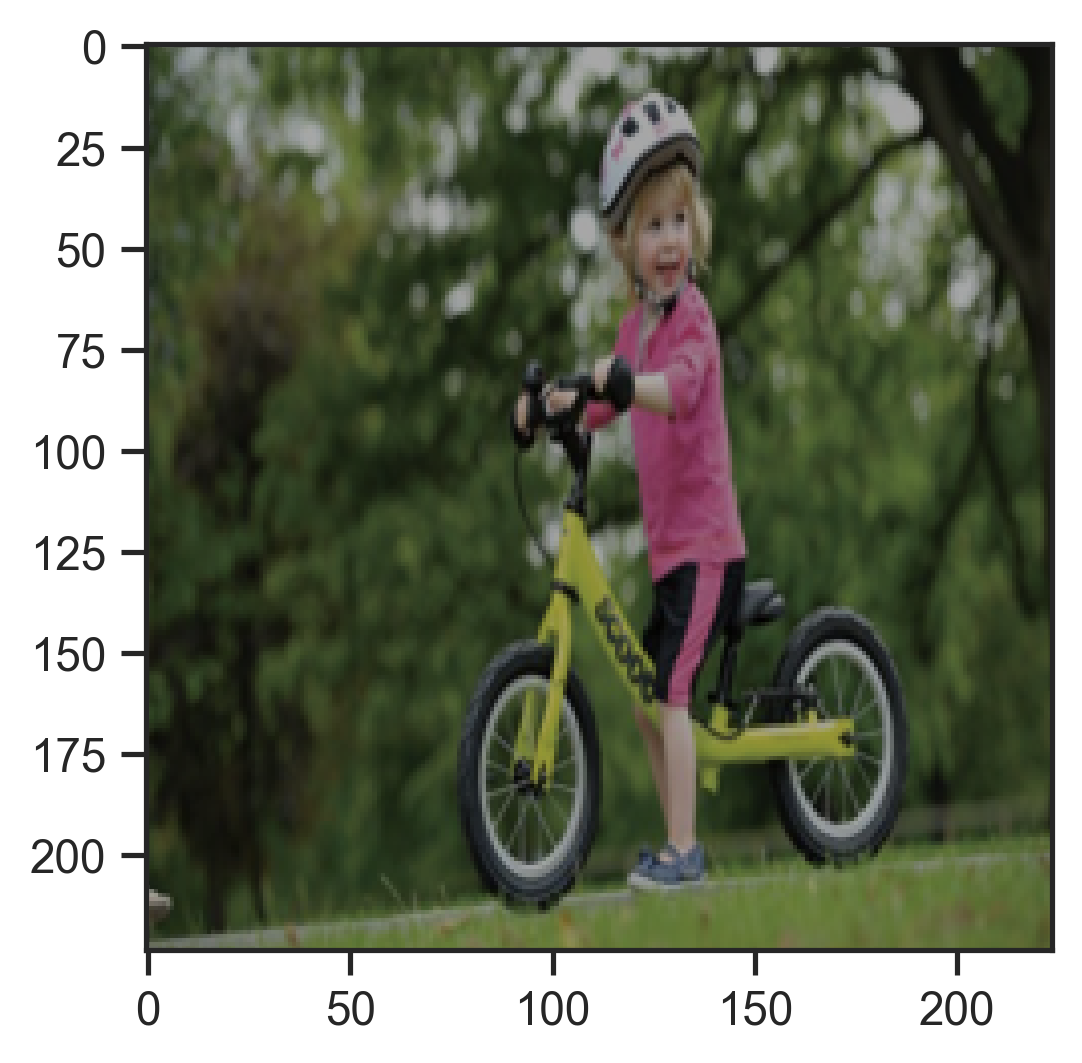

In [150]:
# Augmentantion of full images
augm_full_imgs = []
for i in range(0, len(full_imgs)):
    augm_full_imgs.append(picture_zoom(full_imgs[i]))
    augm_full_imgs.append(picture_rotation(full_imgs[i]))
    augm_full_imgs.append(picture_brightness(full_imgs[i]))

In [151]:
# consolidate initial with augmented images in one list
final_full_imgs = full_imgs + augm_full_imgs

print("Total full images:", len(final_full_imgs))
print("of which initial images:", len(full_imgs))
print("of which augmented images:", len(augm_full_imgs))

Total full images: 3044
of which initial images: 761
of which augmented images: 2283


Text(0, 0.5, 'Labels')

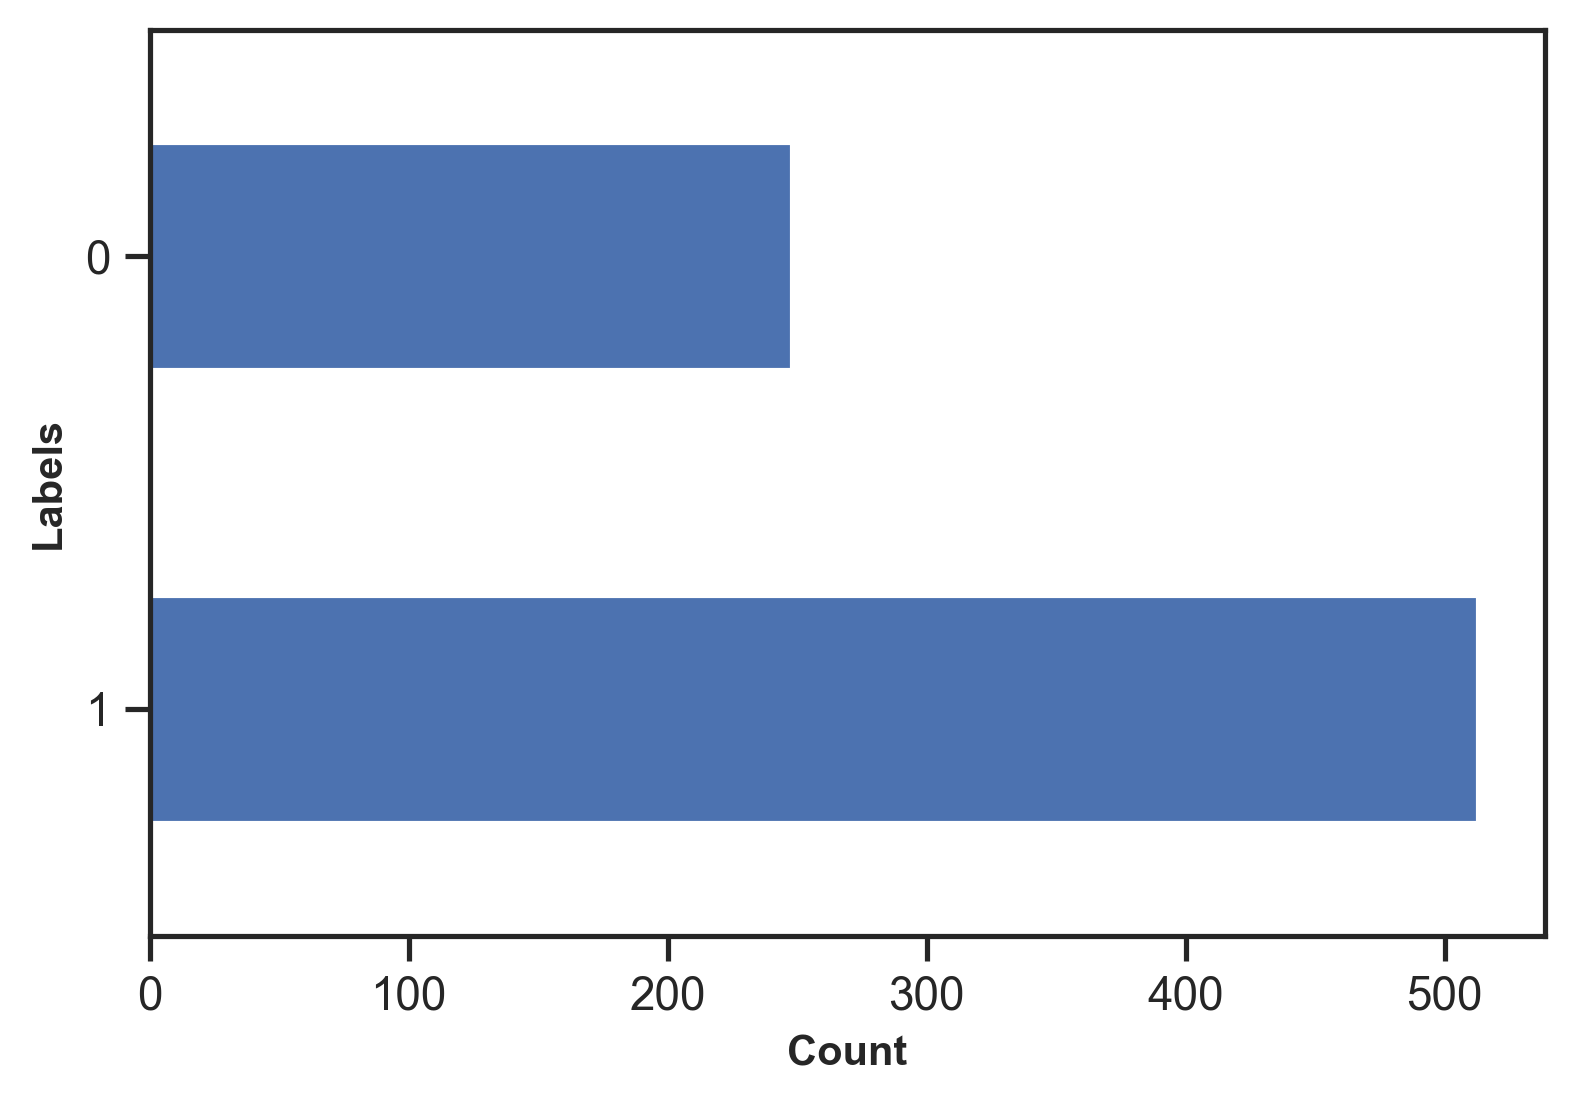

In [152]:
# Converts lists for images names and for the corresponding label names
list1=[]
list2=[]

for i in range(0,len(full_imgs)):
    list1.append(full_imgs[i][0])
    list2.append(full_imgs[i][2])
    
df=pd.DataFrame()
df=df.assign(Images=list1)
df=df.assign(Labels=list2)

df["Labels"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Labels', fontsize = 10, fontweight = 'bold')

* Transform full images to model inputs

In [153]:
# Transforming images in a proper array for model input
full_imgs_array = []
for i in range(0, len(final_full_imgs)):
    full_imgs_array.append(np.array(final_full_imgs[i][1]))
full_imgs_array = np.array(full_imgs_array, dtype='int')

In [154]:
# shape of new array
full_imgs_array.shape

(3044, 224, 224, 3)

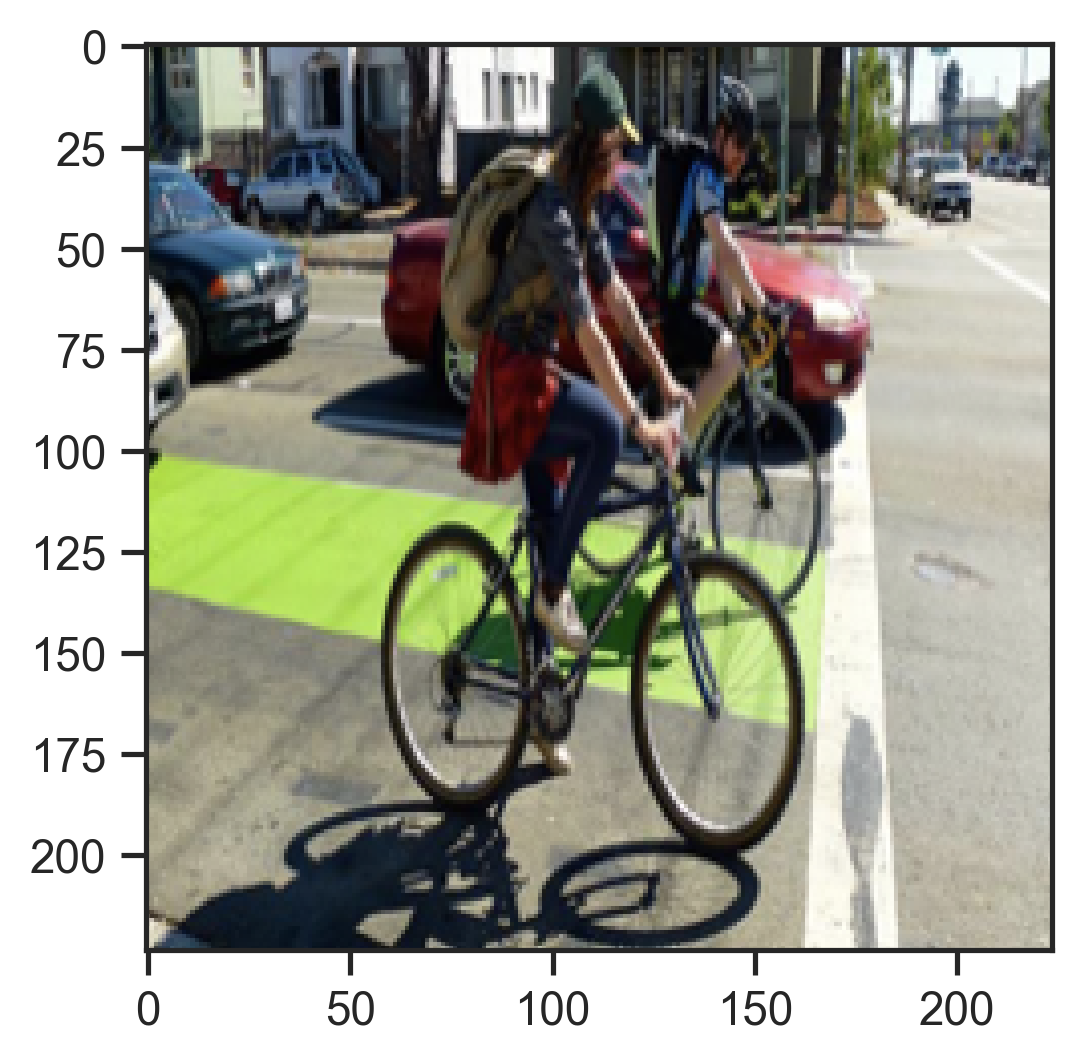

In [155]:
# testing that images appear correctly
plt.imshow(full_imgs_array[714])

In [156]:
# Creating an array with labels
labels_array = []
for i in range(0, len(final_full_imgs)):
    labels_array.append(np.array(final_full_imgs[i][2]))
labels_array = np.array(labels_array, dtype='int')

In [157]:
# Categorically encode the labels
full_imgs_labels = to_categorical(labels_array)

### Data reshaping

In [158]:
def reshape_img_input(x: np.ndarray,
                      img_rows: int = 224,
                      img_cols: int = 224,
                      normalize: bool = True) -> Tuple:
        
    print(f'Original shape of nd-array: {x.shape}')
    
    if K.image_data_format() == 'channels_first':
        
        # the channel dimension goes to the front
        x1 = x.reshape(x.shape[0], 3, img_rows, img_cols)

        input_shape = (3, img_rows, img_cols)

    else:
        # the channel dimension goes to the end. So we end up with the following 4-D tensor
        # (N-samples, Height, Width, N-channels)
        x1 = x.reshape(x.shape[0], img_rows, img_cols, 3)

        input_shape = (img_rows, img_cols, 3)

    x1 = x1.astype('float32')

    if normalize:
        x1 /= 255.
        
    return x1, input_shape

In [159]:
data, input_shape = reshape_img_input(x=full_imgs_array,
                                         img_rows=224, 
                                         img_cols=224,
                                         normalize=True)

Original shape of nd-array: (3044, 224, 224, 3)


### Train, Test & Validation split
* We now split the full dataset into train (75%) and test (25%) sets. 
* The test set is splitted again to test (25%) and validation (75%) sets.
* Random sampling is a very bad option for splitting. So, we tried stratified sampling. 
* This method splits your class proportionally between training and test set. Run oversampling, undersampling or hybrid techniques on training set.

In [160]:
#https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# split into train test sets
from sklearn.model_selection import train_test_split
X_train, X_test_1, y_train, y_test_1 = train_test_split(data, full_imgs_labels,
                                                    stratify=full_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test, X_val, y_test, y_val = train_test_split(X_test_1, y_test_1,
                                                    stratify=y_test_1, 
                                                    test_size=0.25, random_state=5)

## Models hyperparameters

#### Universal parameters
* Setting parameters to be used across models.

In [161]:
learning_Rate = 1e-3
num_Epochs = 50
batch_Size = 32
steps_per_Epoch = int(len(X_train) / batch_Size)

### Callbacks

#### Early Stopping
* Before training the network, we define an early stopping criterion, to avoid redundent epochs once the model has already converged.

In [162]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, restore_best_weights = True)

#### Reduce Learning Rate On Plateau
* We define a ReduceLROnPlateau callback to reduce the learning rate when the metric we chose (val_loss) has stopped improving.

In [163]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.1, min_lr = 1e-6)

## Models

### Model 1 - Simple CNN
* https://github.com/mohandandamudi/FaceMaskDetection/blob/master/Face%20Mask%20Detection.ipynb

In [164]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import Sequential
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

* Buliding Model 

In [165]:
# Adding model layers
CNN_few_Layers = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(2, activation='softmax')
])
CNN_few_Layers.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_478 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 394272)            0         
                                                                 
 dense_18 (Dense)            (None, 2)                 788546    
                                                                 
Total params: 789,442
Trainable params: 789,442
Non-trainable params: 0
_________________________________________________________________


* Compiling Model

In [166]:
opt = optimizers.Adam(learning_rate=learning_Rate) 
CNN_few_Layers.compile(optimizer=opt, 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy', 'Recall', 'Precision', 'AUC']) #categorical_crossentropy or binary_crossentropy

* Fitting Model

In [167]:
model_1 = CNN_few_Layers.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, # early stopping epoch: 10
                    steps_per_epoch = steps_per_Epoch, 
                    batch_size = batch_Size, 
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 46s 514ms/step - loss: 2.7596 - accuracy: 0.6272 - recall: 0.6272 - precision: 0.6272 - auc: 0.6249 - val_loss: 0.5390 - val_accuracy: 0.7487 - val_recall: 0.7487 - val_precision: 0.7487 - val_auc: 0.8318 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 32s 451ms/step - loss: 0.3942 - accuracy: 0.8418 - recall: 0.8418 - precision: 0.8418 - auc: 0.9150 - val_loss: 0.5067 - val_accuracy: 0.7539 - val_recall: 0.7539 - val_precision: 0.7539 - val_auc: 0.8393 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 31s 438ms/step - loss: 0.1768 - accuracy: 0.9538 - recall: 0.9538 - precision: 0.9538 - auc: 0.9856 - val_loss: 0.4538 - val_accuracy: 0.7801 - val_recall: 0.7801 - val_precision: 0.7801 - val_auc: 0.8712 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 31s 438ms/step - loss: 0.1273 - accuracy: 0.9751 - recall: 0.9751 - precision: 0.9751 - auc: 0.9901 - val_loss: 0.4903 - val_accuracy: 0.8

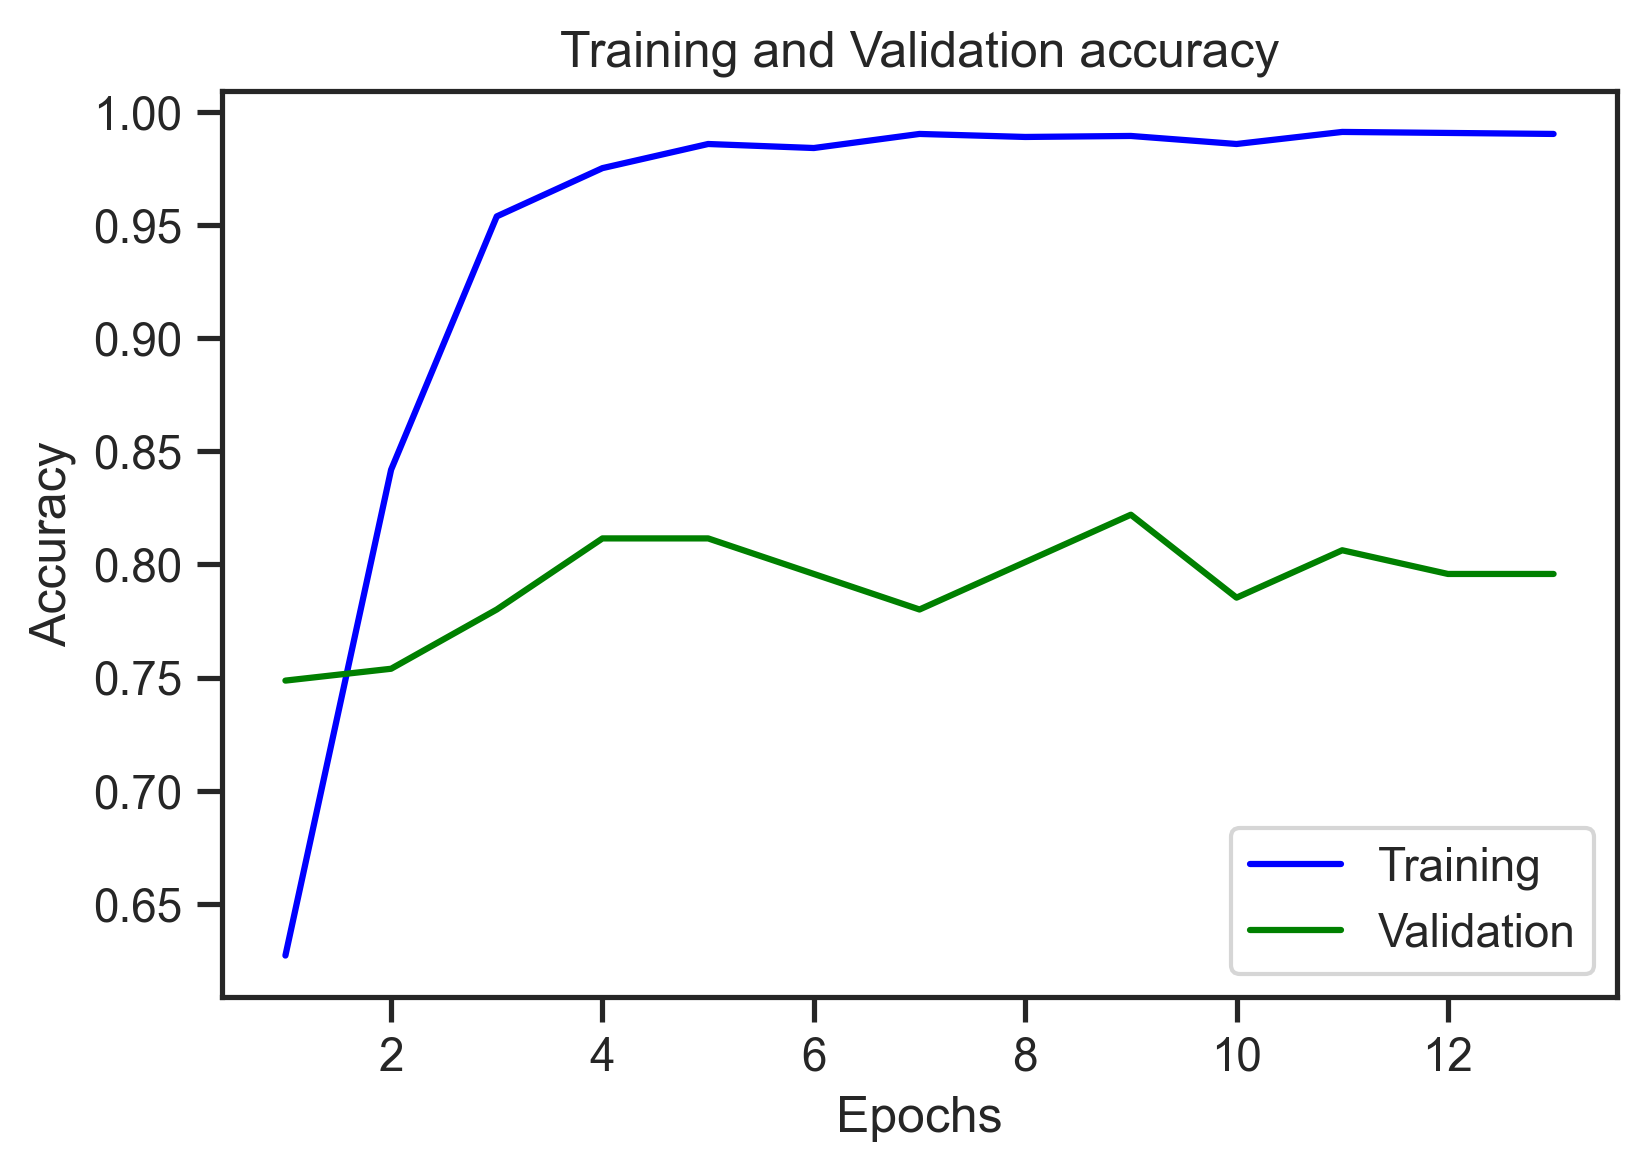

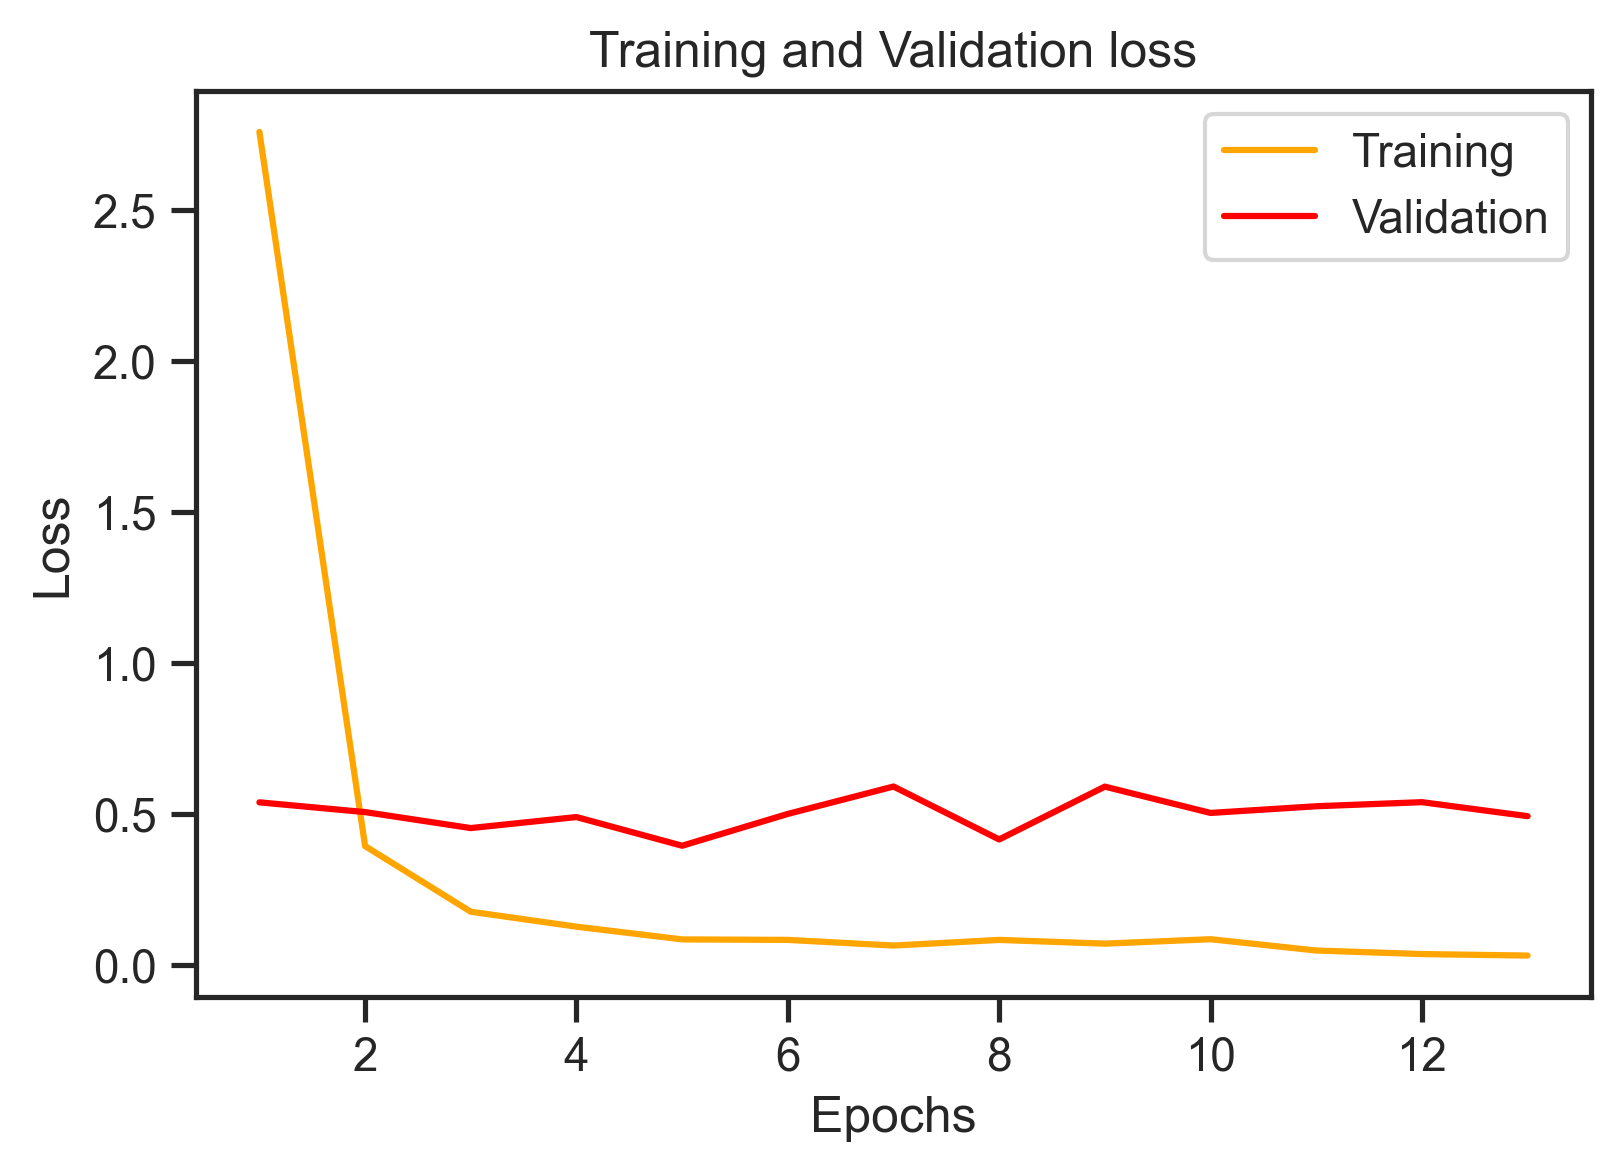

In [168]:
loss = model_1.history['loss']
val_loss = model_1.history['val_loss']
acc = model_1.history['accuracy']
val_acc = model_1.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 - Custom CNN

* Building Model

In [169]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [170]:
CNN_adjusted_v1 = Sequential()
CNN_adjusted_v1.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (224, 224, 3)))
CNN_adjusted_v1.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v1.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
CNN_adjusted_v1.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v1.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
CNN_adjusted_v1.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v1.add(Dropout(0.3))
CNN_adjusted_v1.add(Flatten())
CNN_adjusted_v1.add(Dense(units = 500, activation = 'relu'))
CNN_adjusted_v1.add(Dropout(0.4))
CNN_adjusted_v1.add(Dense(units = 2, activation = 'softmax'))
CNN_adjusted_v1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_479 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_480 (Conv2D)         (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_481 (Conv2D)         (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 28, 28, 64)      

* Compiling Model

In [171]:
opt = optimizers.Adam(learning_rate=learning_Rate) 
CNN_adjusted_v1.compile(optimizer=opt,
                    loss="categorical_crossentropy",
                    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

* Fitting Model

In [172]:
model_2 = CNN_adjusted_v1.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, #>=30 / Early stopping: 15 epochs
                    steps_per_epoch = steps_per_Epoch, 
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 61s 759ms/step - loss: 0.9195 - accuracy: 0.6637 - recall: 0.6637 - precision: 0.6637 - auc: 0.6713 - val_loss: 0.6074 - val_accuracy: 0.6754 - val_recall: 0.6754 - val_precision: 0.6754 - val_auc: 0.7544 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 50s 707ms/step - loss: 0.5606 - accuracy: 0.7183 - recall: 0.7183 - precision: 0.7183 - auc: 0.7829 - val_loss: 0.5558 - val_accuracy: 0.7382 - val_recall: 0.7382 - val_precision: 0.7382 - val_auc: 0.7899 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 50s 703ms/step - loss: 0.4719 - accuracy: 0.7837 - recall: 0.7837 - precision: 0.7837 - auc: 0.8600 - val_loss: 0.5349 - val_accuracy: 0.7120 - val_recall: 0.7120 - val_precision: 0.7120 - val_auc: 0.8028 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 50s 702ms/step - loss: 0.3409 - accuracy: 0.8530 - recall: 0.8530 - precision: 0.8530 - auc: 0.9313 - val_loss: 0.5256 - val_accuracy: 0.7

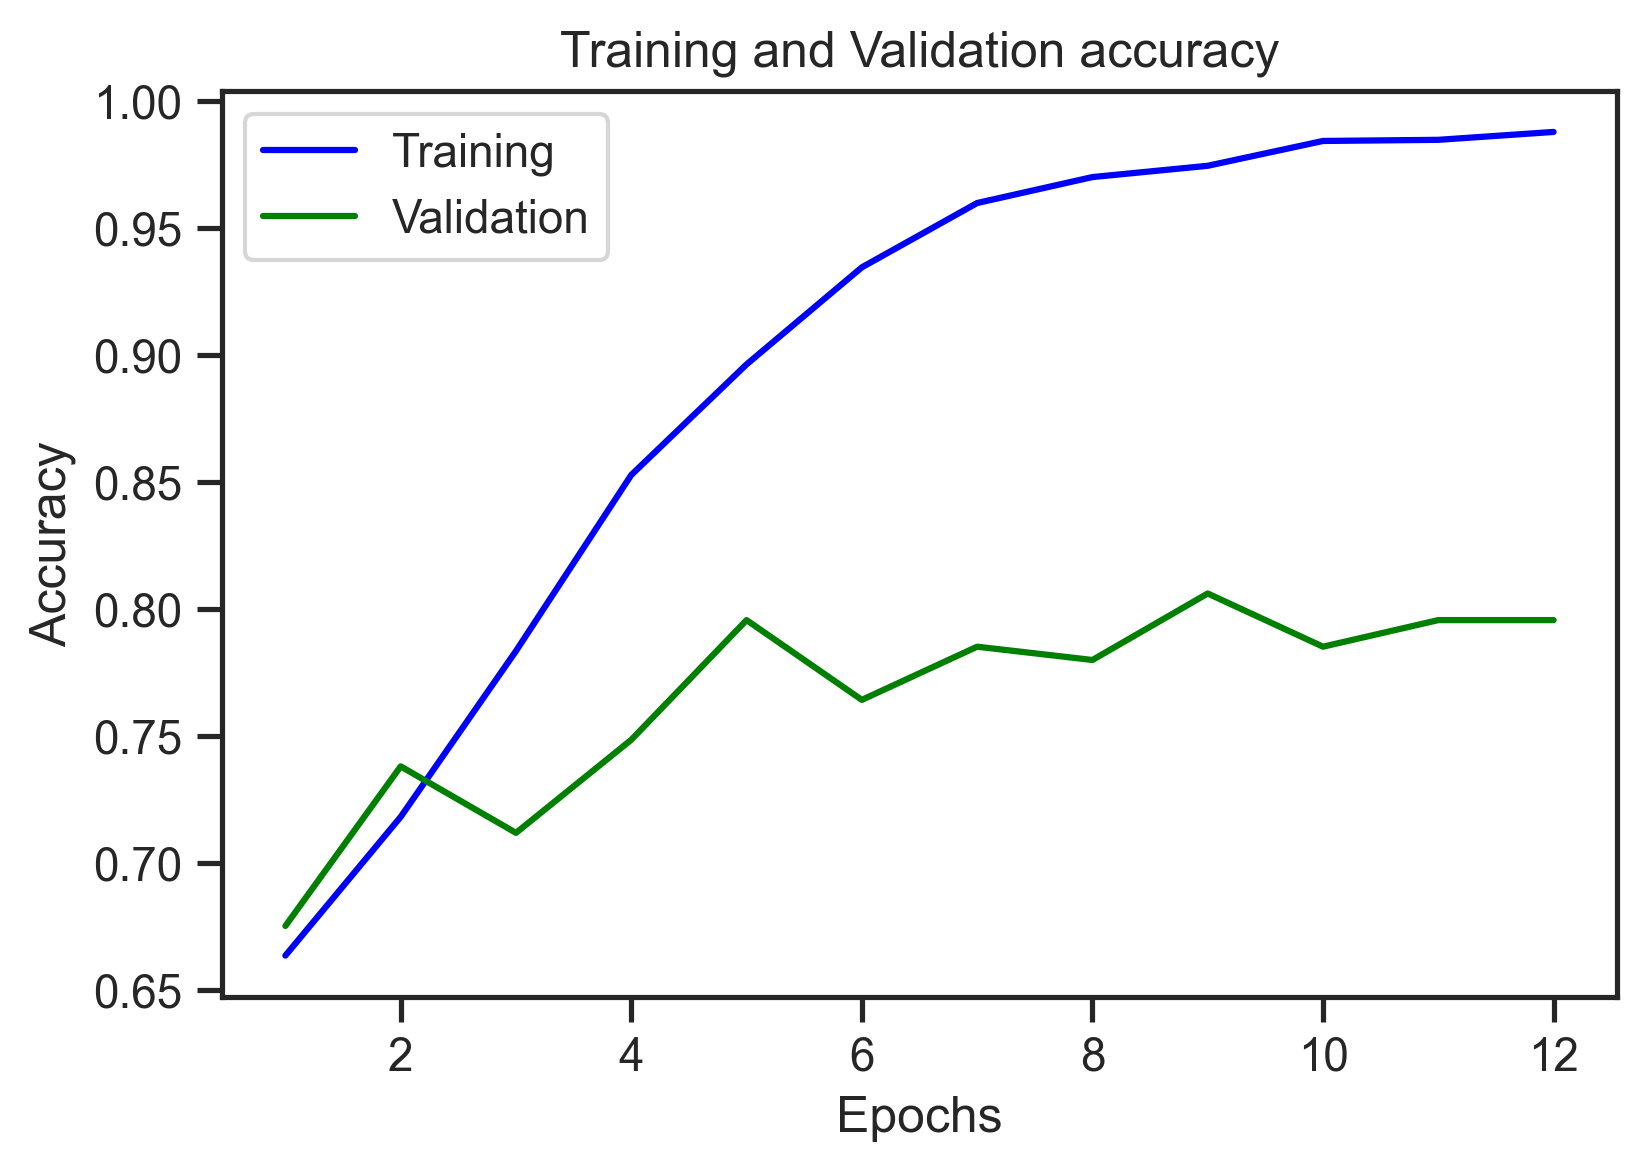

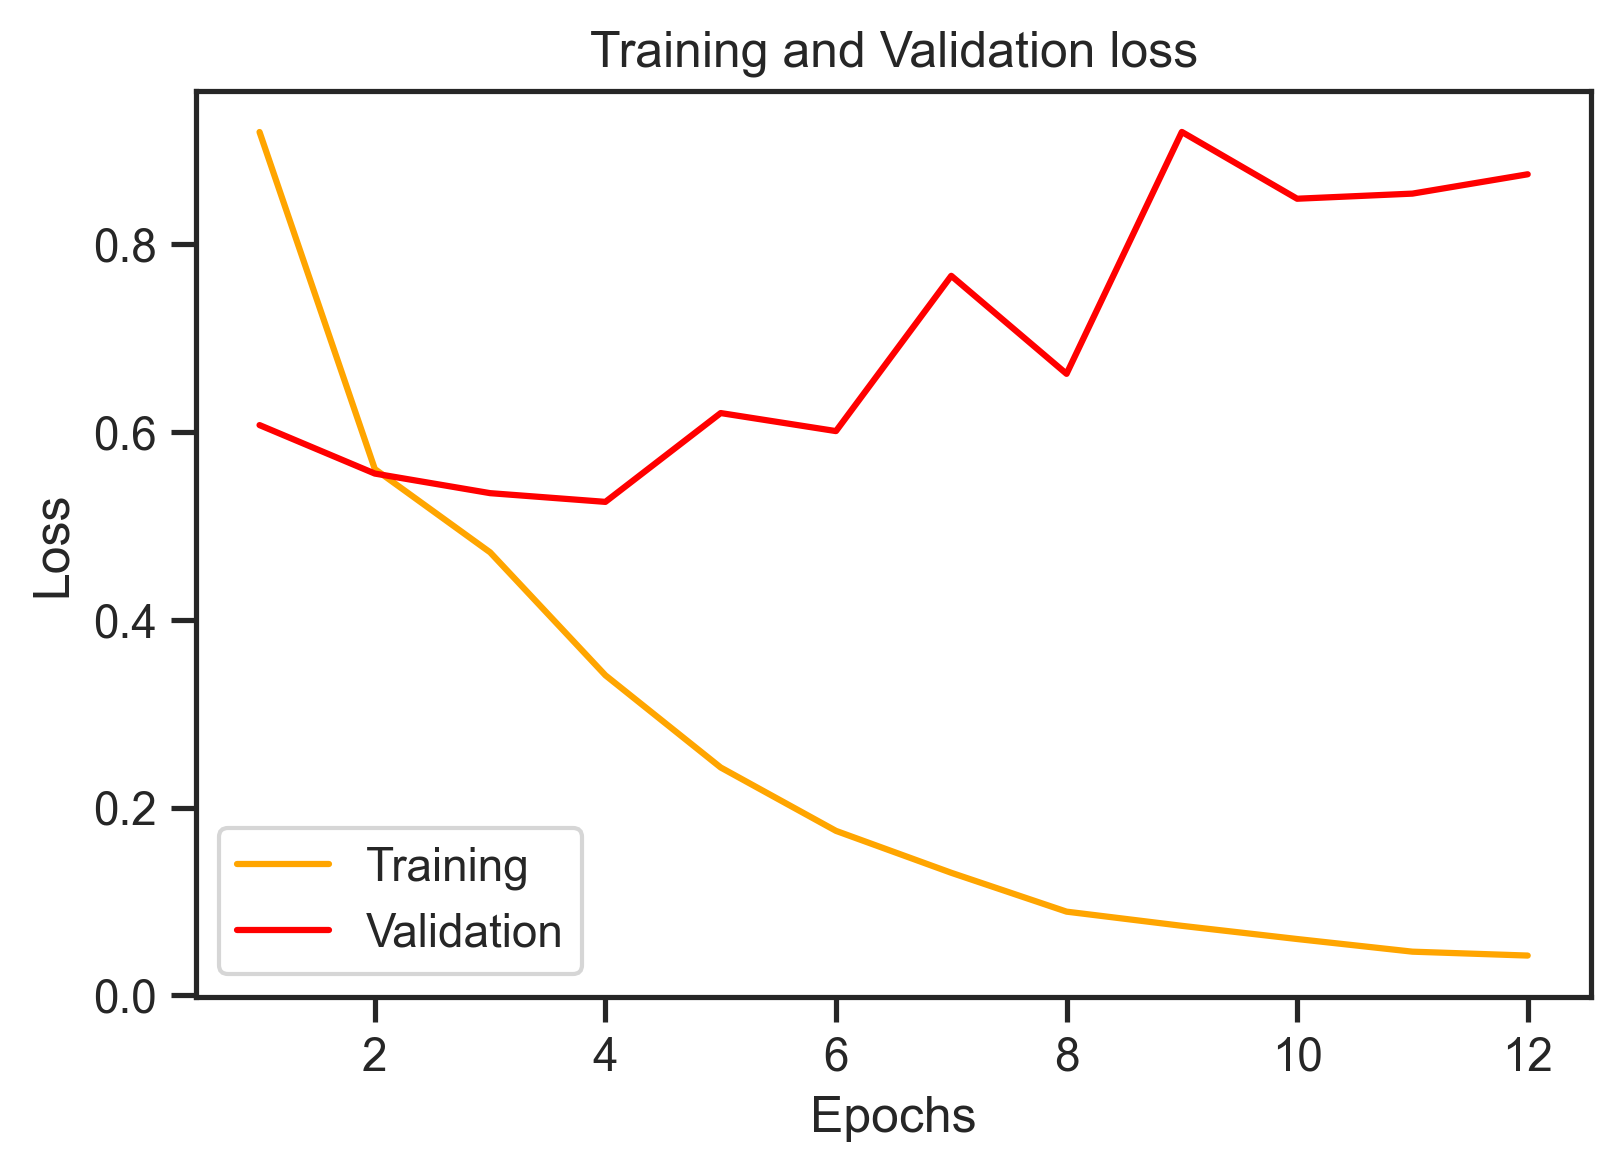

In [173]:
loss = model_2.history['loss']
val_loss = model_2.history['val_loss']
acc = model_2.history['accuracy']
val_acc = model_2.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 3 - Adjusted Custom CNN

In [174]:
# placeholder for comments regarding differences with model 2

In [175]:
#Model CNN with RmsProp Optimizer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout

* Building Model

In [176]:
CNN_adjusted_v2=Sequential()
CNN_adjusted_v2.add(Conv2D(filters = 16, kernel_size = 3, padding='same', activation = 'relu', input_shape = (224, 224, 3)))
CNN_adjusted_v2.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v2.add(Conv2D(filters = 32, kernel_size=3,padding='same', activation='relu'))
CNN_adjusted_v2.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v2.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu'))
CNN_adjusted_v2.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v2.add(Conv2D(filters = 128, kernel_size = 3, padding='same', activation = 'relu'))
CNN_adjusted_v2.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v2.add(Flatten())
CNN_adjusted_v2.add(Dense(units = 500, activation = 'relu'))
CNN_adjusted_v2.add(Dropout(0.3))
CNN_adjusted_v2.add(Dense(units = 50, activation = 'relu'))
CNN_adjusted_v2.add(Dense(units = 2, activation ='softmax'))
CNN_adjusted_v2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_482 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_483 (Conv2D)         (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_484 (Conv2D)         (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 28, 28, 64)      

* Compiling Model

In [177]:
CNN_adjusted_v2.compile(
    optimizer = "rmsprop",
    loss = "categorical_crossentropy",
    metrics = ['accuracy', 'Recall', 'Precision', 'AUC']
)

* Fitting Model

In [178]:
model_3 = CNN_adjusted_v2.fit(
                    x = X_train,
                    y = y_train,
                    steps_per_epoch = steps_per_Epoch,
                    epochs = num_Epochs,
                    batch_size = batch_Size,
                    verbose = 1, 
                    shuffle = True,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                )

Epoch 1/50
71/71 [==============================] - 58s 773ms/step - loss: 0.7944 - accuracy: 0.6527 - recall: 0.6527 - precision: 0.6527 - auc: 0.6676 - val_loss: 0.6334 - val_accuracy: 0.6754 - val_recall: 0.6754 - val_precision: 0.6754 - val_auc: 0.7209 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 54s 758ms/step - loss: 0.6517 - accuracy: 0.6770 - recall: 0.6770 - precision: 0.6770 - auc: 0.6936 - val_loss: 0.8382 - val_accuracy: 0.6754 - val_recall: 0.6754 - val_precision: 0.6754 - val_auc: 0.6759 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 53s 752ms/step - loss: 0.6012 - accuracy: 0.6926 - recall: 0.6926 - precision: 0.6926 - auc: 0.7457 - val_loss: 0.5903 - val_accuracy: 0.7120 - val_recall: 0.7120 - val_precision: 0.7120 - val_auc: 0.7904 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 54s 764ms/step - loss: 0.5727 - accuracy: 0.7246 - recall: 0.7246 - precision: 0.7246 - auc: 0.7954 - val_loss: 0.5304 - val_accuracy: 0.7

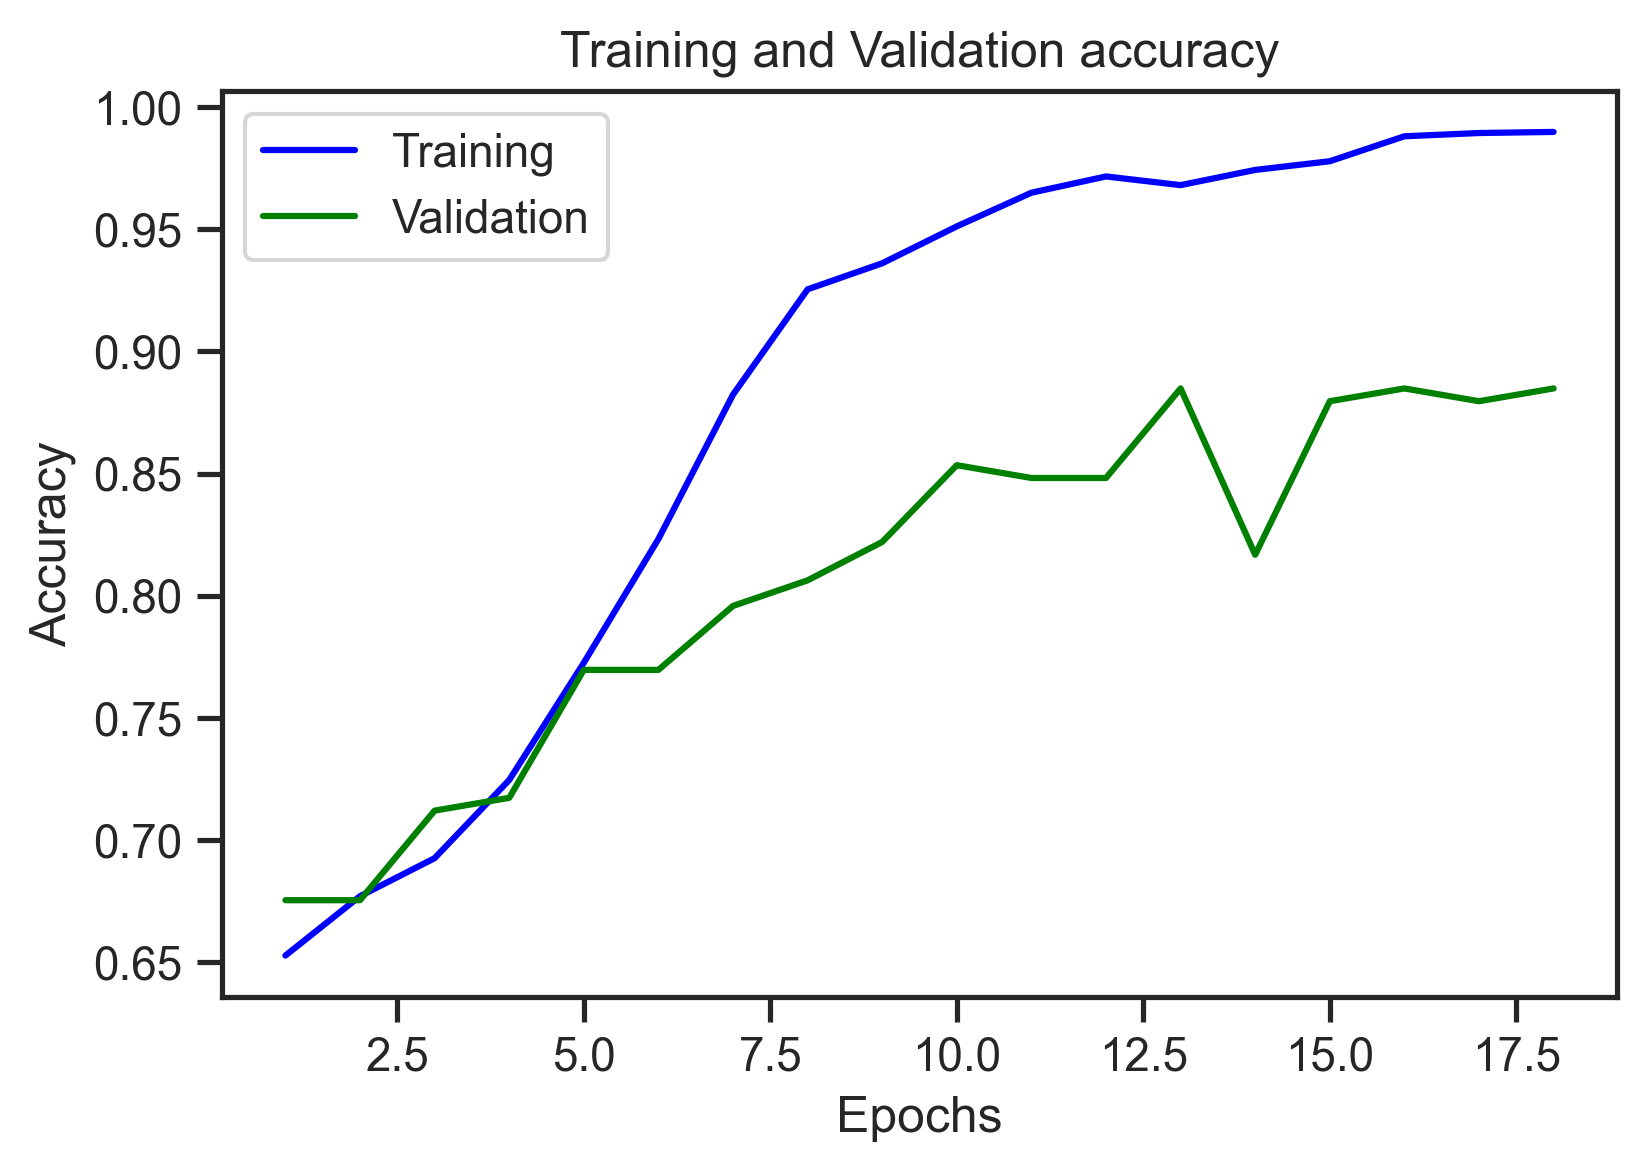

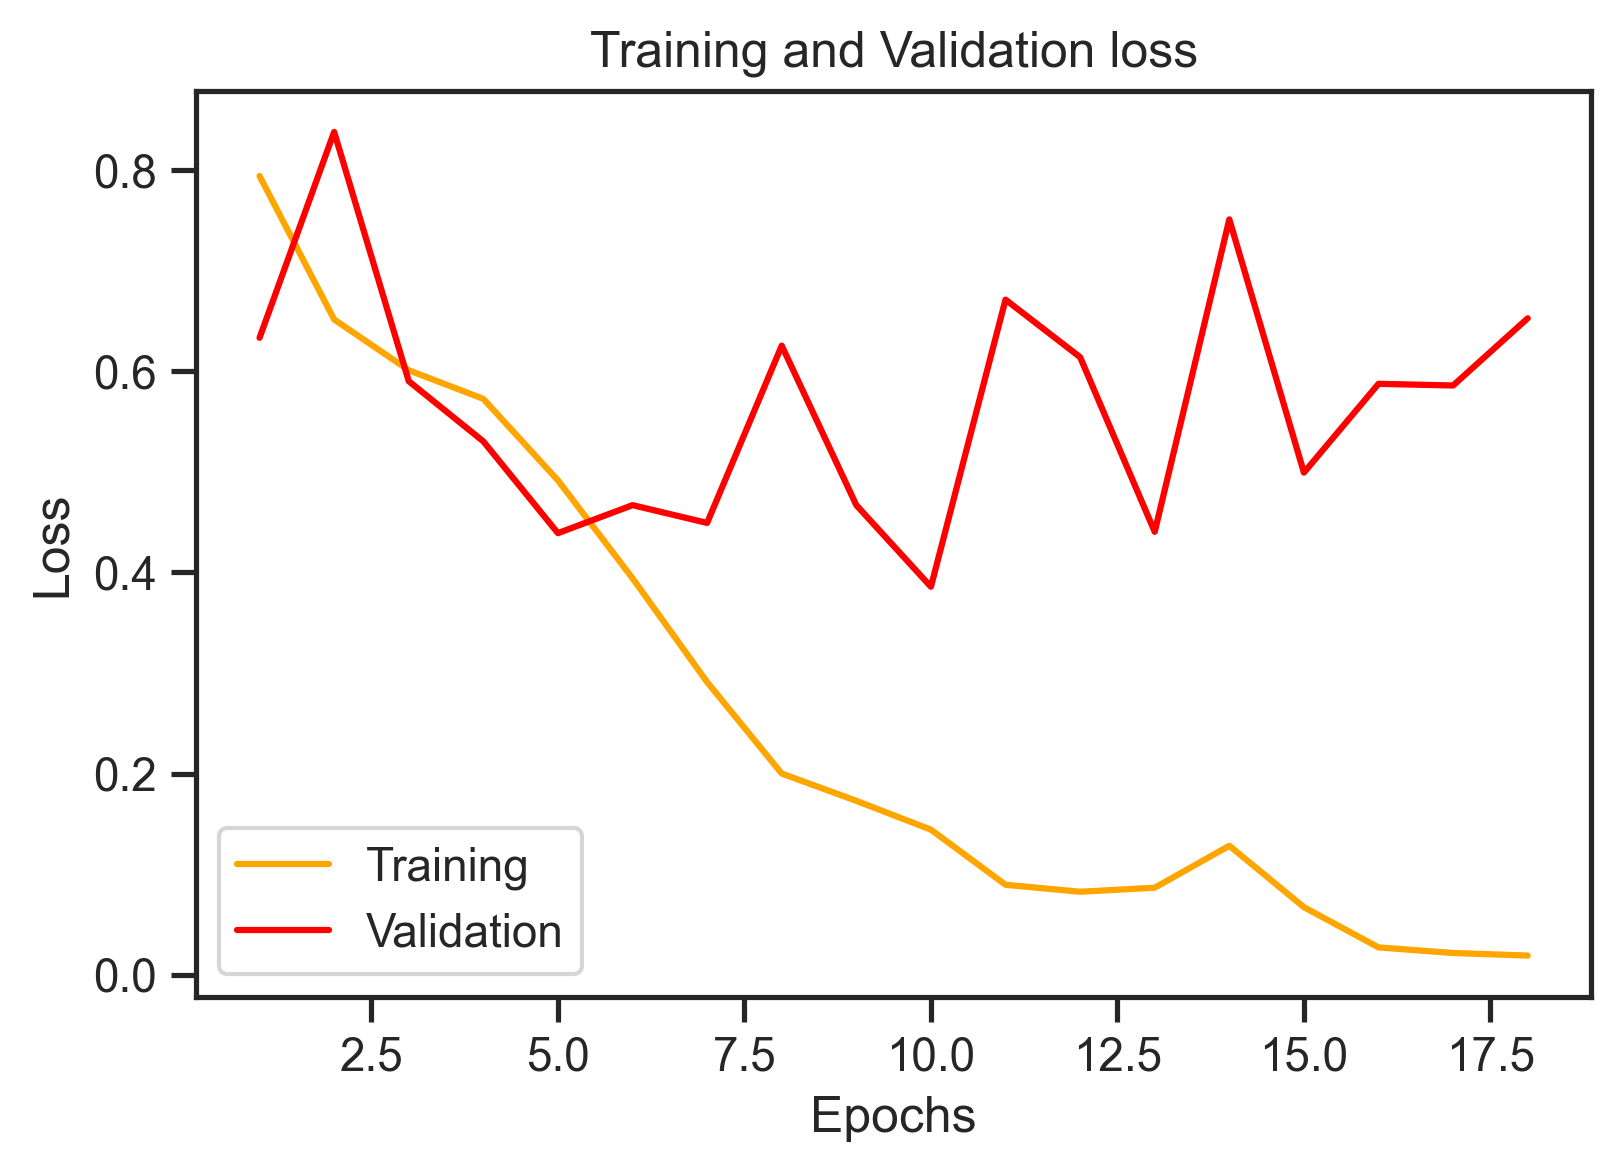

In [179]:
loss = model_3.history['loss']
val_loss = model_3.history['val_loss']
acc = model_3.history['accuracy']
val_acc = model_3.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 4 - InceptionV3

In [180]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
import tensorflow as tf
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

* Bulding Model

In [181]:
inceptv3 = InceptionV3(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False 
)

for layer in inceptv3.layers:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = inceptv3(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
inception_v3 = Model(inputs, outputs)

inception_v3.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_24 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


* Compiling Model

In [182]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
inception_v3.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

* Fitting Model

In [183]:
model_4 = inception_v3.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 61s 804ms/step - loss: 1.4501 - accuracy: 0.6717 - recall: 0.6717 - precision: 0.6717 - auc: 0.7283 - val_loss: 1.4900 - val_accuracy: 0.6963 - val_recall: 0.6963 - val_precision: 0.6963 - val_auc: 0.7831 - lr: 0.0100
Epoch 2/50
71/71 [==============================] - 54s 768ms/step - loss: 0.6122 - accuracy: 0.7690 - recall: 0.7690 - precision: 0.7690 - auc: 0.8556 - val_loss: 0.4745 - val_accuracy: 0.7592 - val_recall: 0.7592 - val_precision: 0.7592 - val_auc: 0.8818 - lr: 0.0100
Epoch 3/50
71/71 [==============================] - 55s 779ms/step - loss: 0.3925 - accuracy: 0.8250 - recall: 0.8250 - precision: 0.8250 - auc: 0.9142 - val_loss: 0.5196 - val_accuracy: 0.7958 - val_recall: 0.7958 - val_precision: 0.7958 - val_auc: 0.8707 - lr: 0.0100
Epoch 4/50
71/71 [==============================] - 54s 762ms/step - loss: 0.6170 - accuracy: 0.7916 - recall: 0.7916 - precision: 0.7916 - auc: 0.8743 - val_loss: 0.5226 - val_accuracy: 0.7

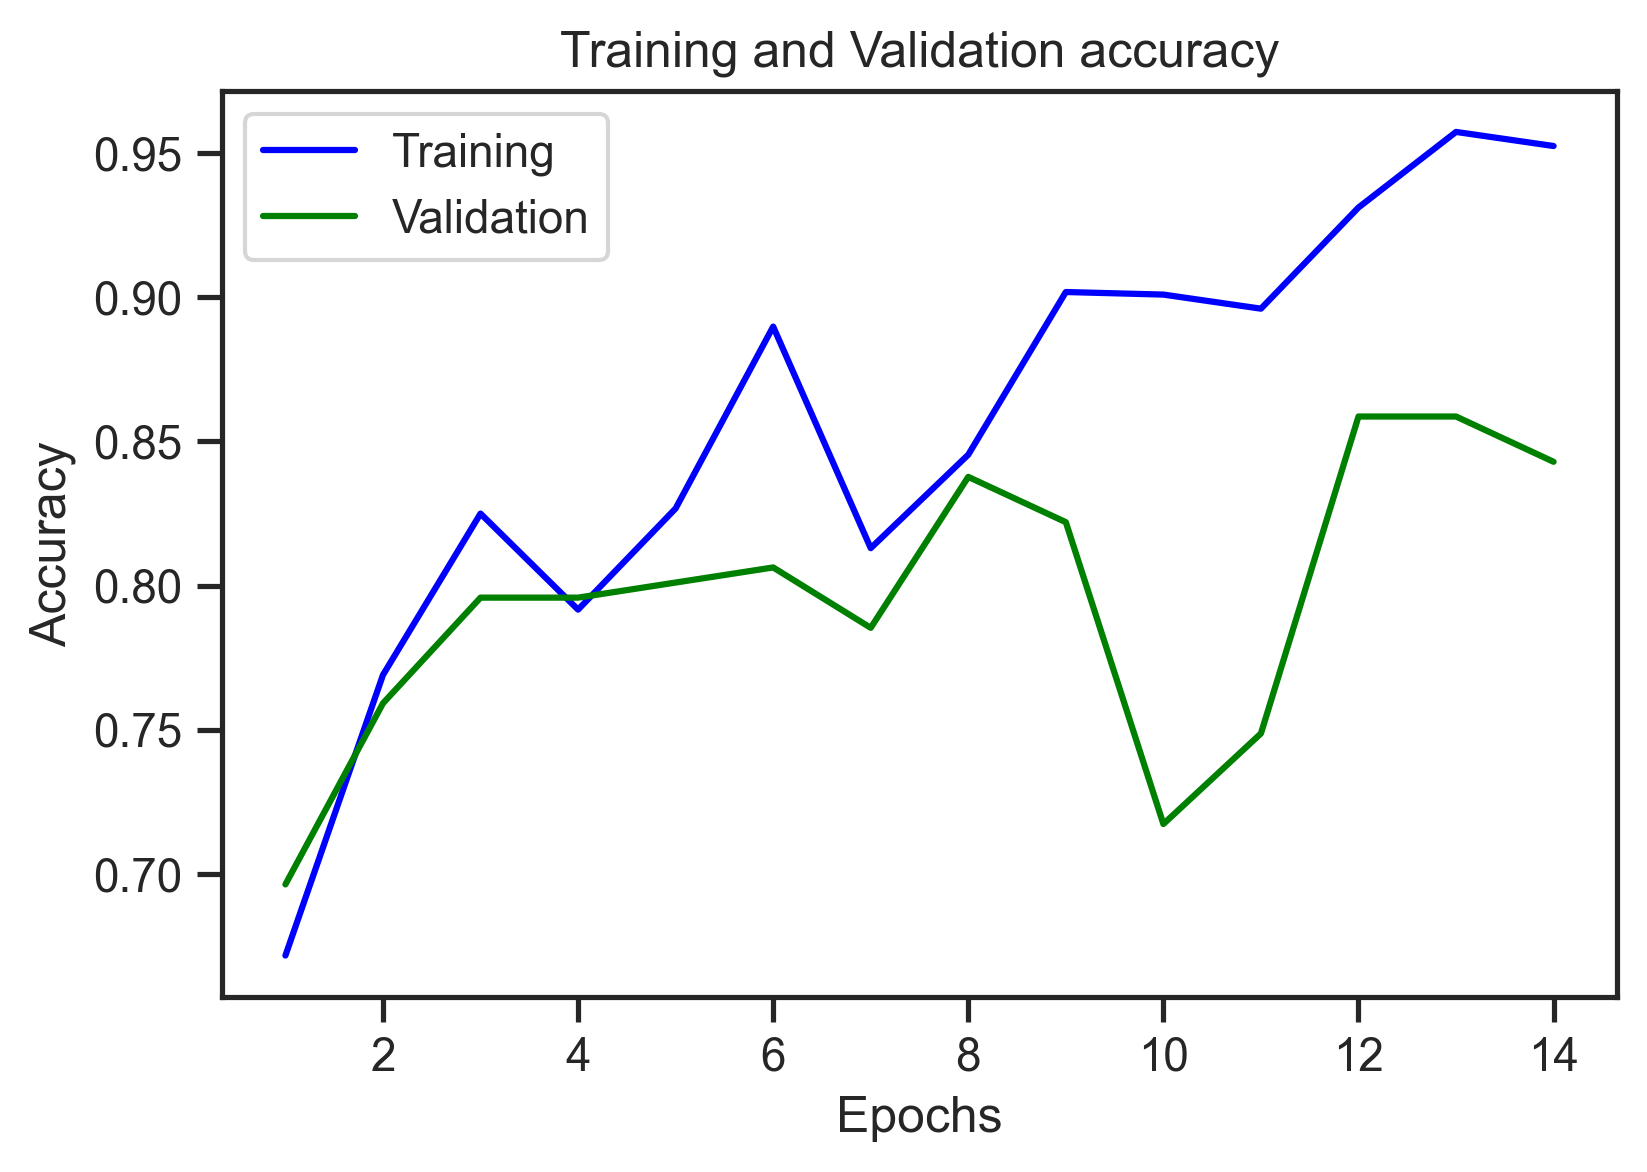

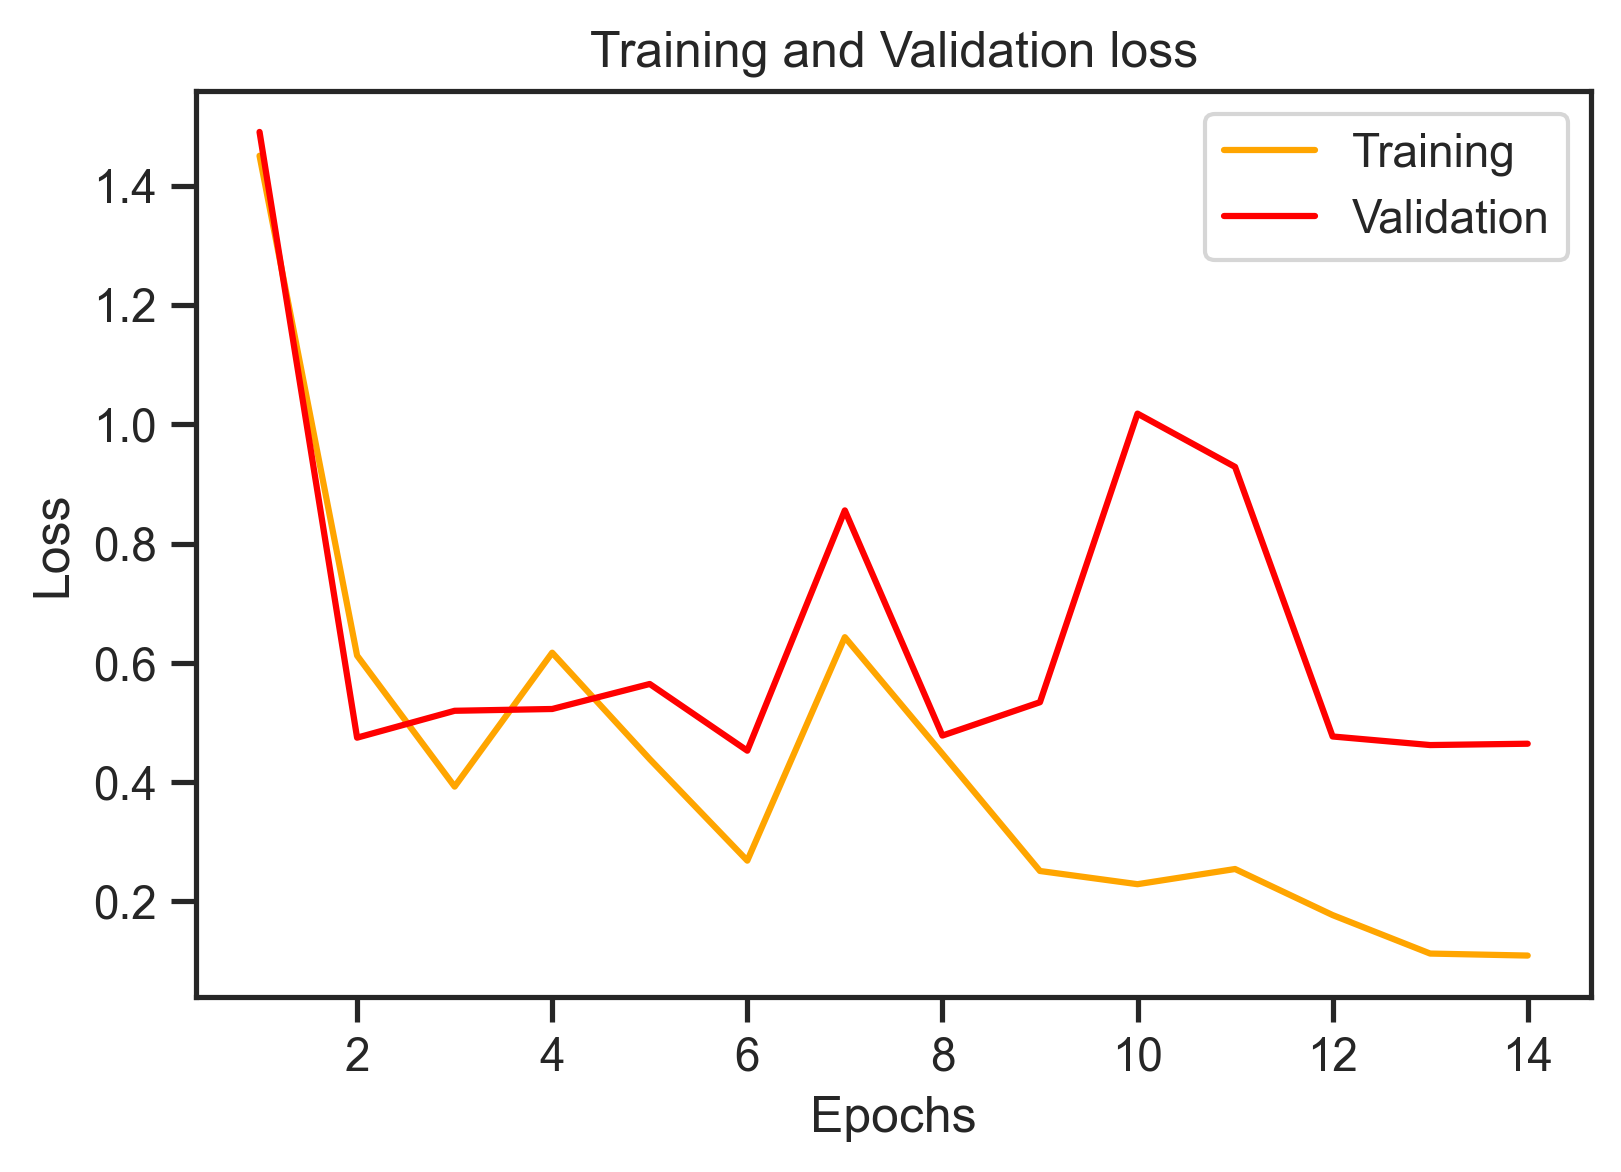

In [184]:
loss = model_4.history['loss']
val_loss = model_4.history['val_loss']
acc = model_4.history['accuracy']
val_acc = model_4.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Fine-tuning of the entire model
* Now that InceptionV3 model has converged on the new data, we unfreeze all the layers and retrain the whole model end-to-end with a very low learning rate.
* We use a very low learning rate at this stage, because we are training a much larger model than in the first round of training, on a dataset that is very small. So we are at risk of overfitting very quickly if we apply large weight updates. <br>
Source: https://www.tensorflow.org/guide/keras/transfer_learning#do_a_round_of_fine-tuning_of_the_entire_model

In [185]:
inceptv3.trainable = True
inception_v3.summary()

opt = optimizers.Adam(learning_rate=learning_Rate/100) #very low learning rate: 1e-5
inception_v3.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_24 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [186]:
model_4_v2 = inception_v3.fit(
                    x = X_train,
                    y = y_train,
                    epochs = int(num_Epochs/5), #for 10 epochs only
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    )

Epoch 1/10
71/71 [==============================] - 381s 5s/step - loss: 0.2479 - accuracy: 0.9023 - recall: 0.9023 - precision: 0.9023 - auc: 0.9636 - val_loss: 0.3234 - val_accuracy: 0.8796 - val_recall: 0.8796 - val_precision: 0.8796 - val_auc: 0.9450
Epoch 2/10
71/71 [==============================] - 363s 5s/step - loss: 0.0849 - accuracy: 0.9760 - recall: 0.9760 - precision: 0.9760 - auc: 0.9937 - val_loss: 0.3110 - val_accuracy: 0.8848 - val_recall: 0.8848 - val_precision: 0.8848 - val_auc: 0.9497
Epoch 3/10
71/71 [==============================] - 373s 5s/step - loss: 0.0455 - accuracy: 0.9884 - recall: 0.9884 - precision: 0.9884 - auc: 0.9971 - val_loss: 0.3302 - val_accuracy: 0.8796 - val_recall: 0.8796 - val_precision: 0.8796 - val_auc: 0.9558
Epoch 4/10
71/71 [==============================] - 381s 5s/step - loss: 0.0419 - accuracy: 0.9876 - recall: 0.9876 - precision: 0.9876 - auc: 0.9980 - val_loss: 0.3358 - val_accuracy: 0.8901 - val_recall: 0.8901 - val_precision: 0.890

### Model 5 - MobileNet2

* Building Model

In [187]:
# transform to appropriate MobileNet2 input / normalize to (-1, 1)
data_mn2 = tf.keras.applications.mobilenet_v2.preprocess_input(full_imgs_array)

In [188]:
# split into train test sets
X_train_mn, X_test_1_mn, y_train_mn, y_test_1_mn = train_test_split(data_mn2, full_imgs_labels,
                                                    stratify = full_imgs_labels, 
                                                    test_size = 0.25, random_state = 5)

X_test_mn, X_val_mn, y_test_mn, y_val_mn = train_test_split(X_test_1_mn, y_test_1_mn,
                                                    stratify = y_test_1_mn, 
                                                    test_size = 0.25, random_state = 5)

In [189]:
mob_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

for layer in mob_net.layers:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = mob_net(inputs, training=False) # added
x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x) #dense layer 2
#x = Dense(512, activation='relu')(x) #dense layer 3
preds = Dense(2, activation='softmax')(x) #final layer with softmax activation
mob_net2 = Model(inputs, preds)

mob_net2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [190]:
# for i,layer in enumerate(mob_net2.layers):
#   print(i,layer.name)

* Compiling Model

In [191]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
mob_net2.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

* Fitting Model

In [192]:
model_5 = mob_net2.fit(
                    x = X_train_mn,
                    y = y_train_mn,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size, 
                    verbose = 1,
                    validation_data = (X_val_mn, y_val_mn),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 52s 683ms/step - loss: 0.7999 - accuracy: 0.7174 - recall: 0.7174 - precision: 0.7174 - auc: 0.7755 - val_loss: 0.5595 - val_accuracy: 0.7435 - val_recall: 0.7435 - val_precision: 0.7435 - val_auc: 0.8125 - lr: 0.0100
Epoch 2/50
71/71 [==============================] - 45s 639ms/step - loss: 0.4102 - accuracy: 0.8139 - recall: 0.8139 - precision: 0.8139 - auc: 0.9023 - val_loss: 0.5059 - val_accuracy: 0.7906 - val_recall: 0.7906 - val_precision: 0.7906 - val_auc: 0.8812 - lr: 0.0100
Epoch 3/50
71/71 [==============================] - 45s 635ms/step - loss: 0.3541 - accuracy: 0.8450 - recall: 0.8450 - precision: 0.8450 - auc: 0.9271 - val_loss: 0.4379 - val_accuracy: 0.8325 - val_recall: 0.8325 - val_precision: 0.8325 - val_auc: 0.8892 - lr: 0.0100
Epoch 4/50
71/71 [==============================] - 45s 637ms/step - loss: 0.2872 - accuracy: 0.8783 - recall: 0.8783 - precision: 0.8783 - auc: 0.9506 - val_loss: 0.3892 - val_accuracy: 0.8

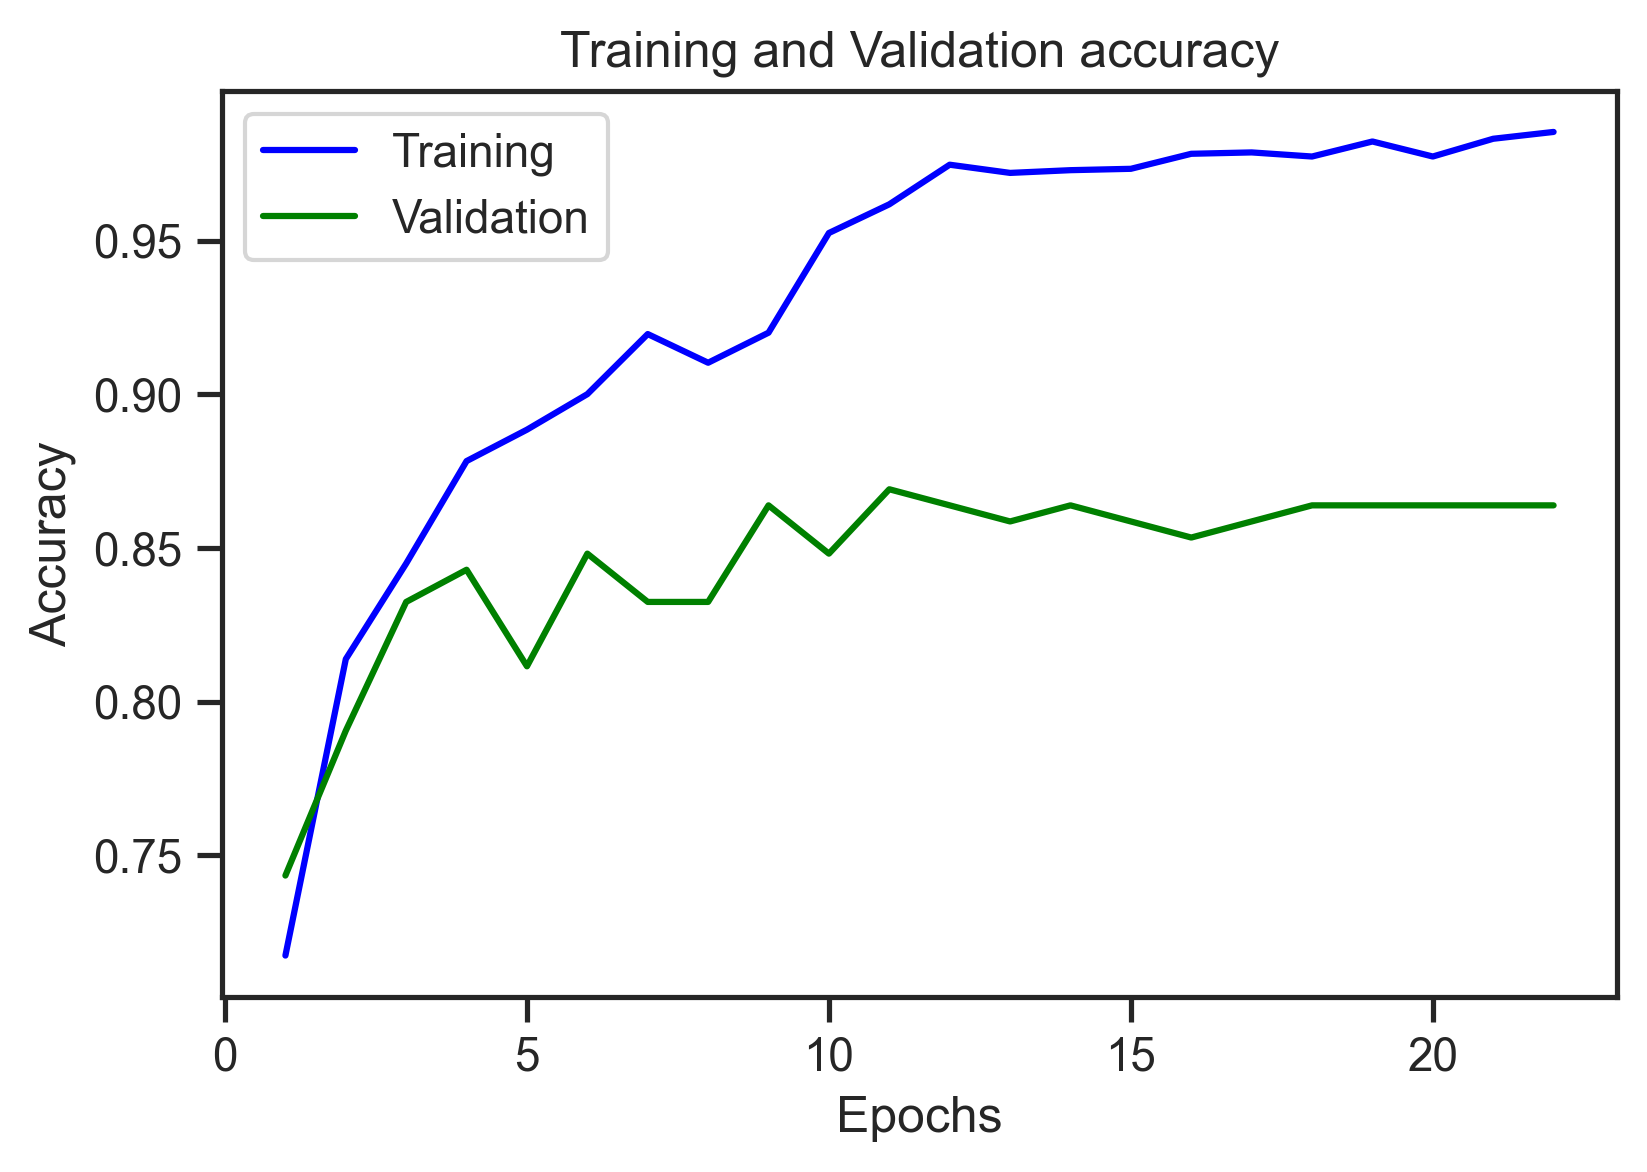

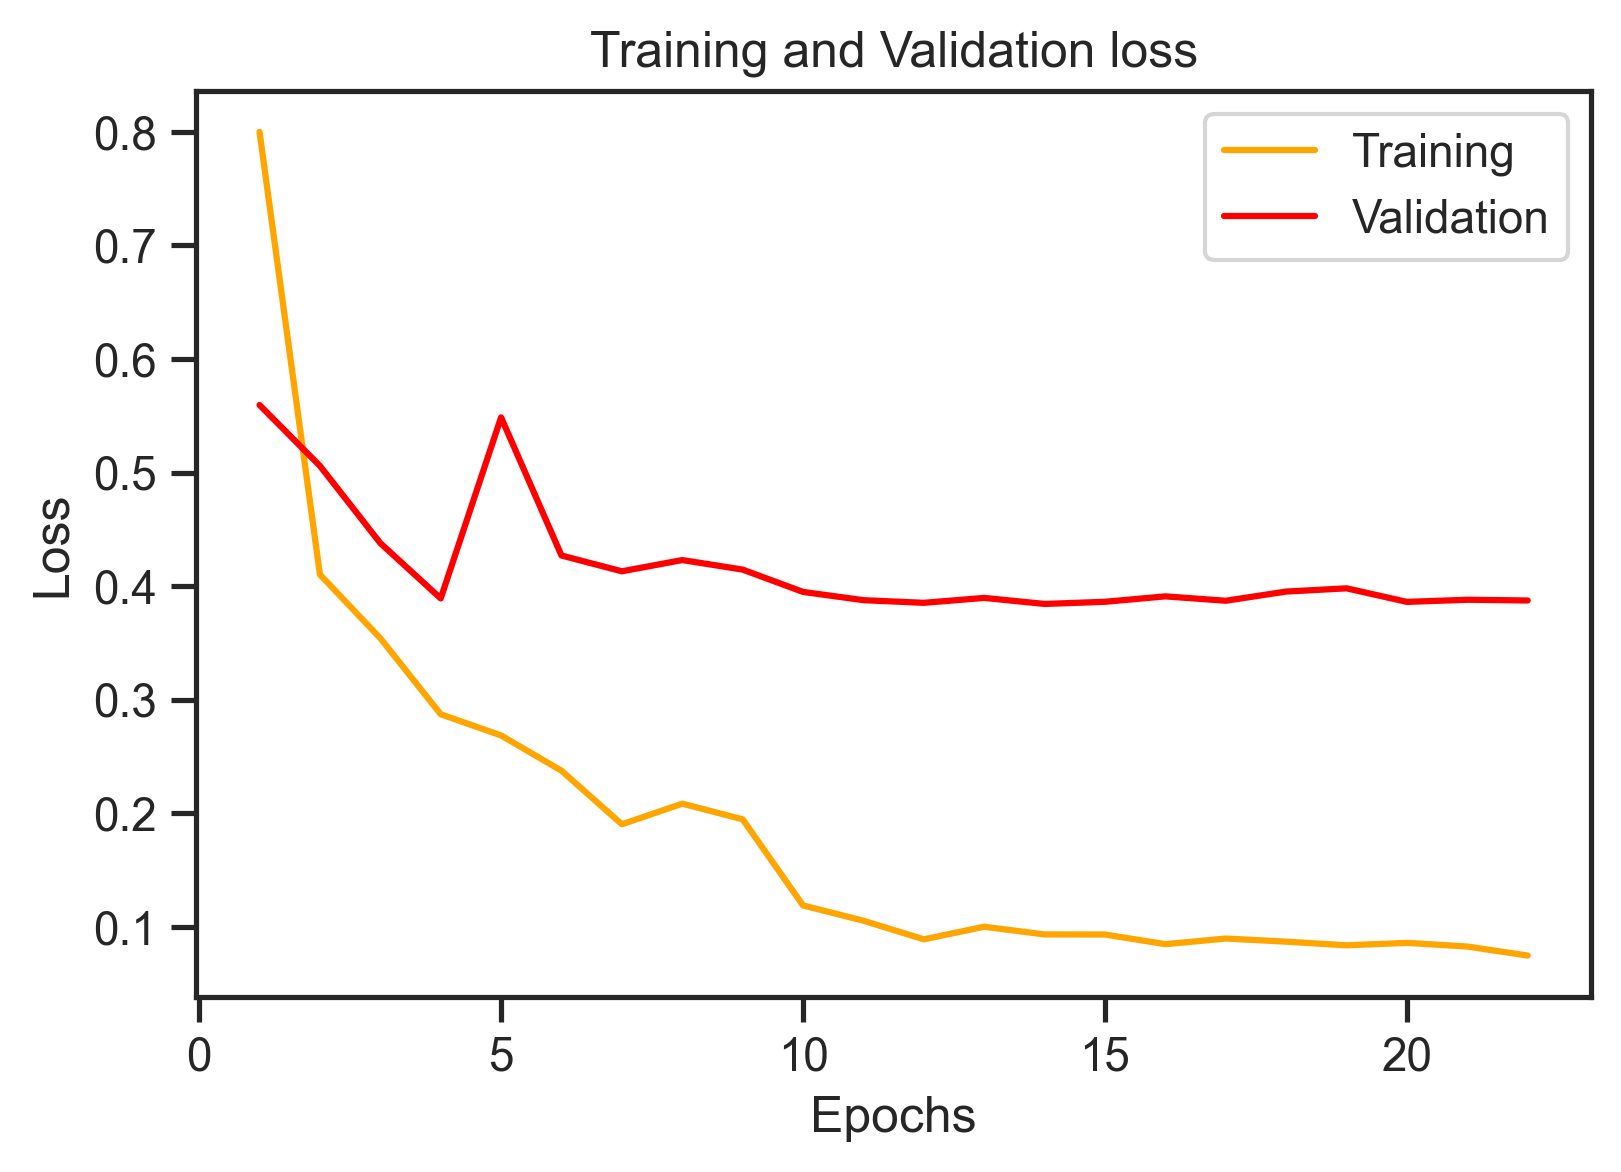

In [193]:
loss = model_5.history['loss']
val_loss = model_5.history['val_loss']
acc = model_5.history['accuracy']
val_acc = model_5.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Fine-tuning of the entire model

In [194]:
mob_net.trainable = True
mob_net2.summary()

opt = optimizers.Adam(learning_rate=learning_Rate/100) #very low learning rate: 1e-5
mob_net2.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [195]:
model_5_v2 = mob_net2.fit(
                    x = X_train_mn,
                    y = y_train_mn,
                    epochs = int(num_Epochs/5), #for 10 epochs only
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val_mn, y_val_mn),
                    )

Epoch 1/10
71/71 [==============================] - 213s 3s/step - loss: 0.1405 - accuracy: 0.9445 - recall: 0.9445 - precision: 0.9445 - auc: 0.9882 - val_loss: 0.4183 - val_accuracy: 0.8429 - val_recall: 0.8429 - val_precision: 0.8429 - val_auc: 0.9294
Epoch 2/10
71/71 [==============================] - 192s 3s/step - loss: 0.0706 - accuracy: 0.9818 - recall: 0.9818 - precision: 0.9818 - auc: 0.9963 - val_loss: 0.3701 - val_accuracy: 0.8796 - val_recall: 0.8796 - val_precision: 0.8796 - val_auc: 0.9390
Epoch 3/10
71/71 [==============================] - 191s 3s/step - loss: 0.0496 - accuracy: 0.9876 - recall: 0.9876 - precision: 0.9876 - auc: 0.9978 - val_loss: 0.3408 - val_accuracy: 0.8691 - val_recall: 0.8691 - val_precision: 0.8691 - val_auc: 0.9548
Epoch 4/10
71/71 [==============================] - 191s 3s/step - loss: 0.0460 - accuracy: 0.9871 - recall: 0.9871 - precision: 0.9871 - auc: 0.9980 - val_loss: 0.4103 - val_accuracy: 0.8639 - val_recall: 0.8639 - val_precision: 0.863

### Saving best model's weights

In [196]:
best_model = inception_v3
best_model.save_weights(r'.\team_quebec_results\best_model_weights')

## Models Comparison 


### Functions for plots

In [197]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

In [198]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

### Compare classifiers

In [199]:
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.datasets import make_classification
from sklearn import model_selection

In [200]:
# * Precision: The model precision score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value. Precision Score = TP / (FP + TP)
# * Accuracy: Tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.  Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)
# * Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values.
# * F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively. 
#   F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)

In [201]:
classifiers = [CNN_few_Layers,
    CNN_adjusted_v1,
    CNN_adjusted_v2,
    inception_v3,
    mob_net2
    ]
name_of_model = ["CNN_few_Layers",
    "CNN_adjusted_v1",
    "CNN_adjusted_v2",
    "inception_v3",
    "mob_net2"
    ]

In [202]:
# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy", "Precision", "Recall", "F1", "AUC"]

log = pd.DataFrame(columns=log_cols)
i = 0

for clf in classifiers:

    name=name_of_model[i]
    i+=1    

    # if statamenet to use rescaled (-1, 1) test dataset for MobileNet2
    if name == name_of_model[-1]:
        y_true = np.argmax(y_test_mn, axis = 1)[:]
        pred = clf.predict(X_test_mn, verbose = 0) # Predict prob and get Class Indices
        y_pred= np.argmax(pred, axis = 1)[:]
    else:
        # calculate y_pred
        y_true = np.argmax(y_test, axis = 1)[:]
        pred = clf.predict(X_test, verbose = 0) # Predict prob and get Class Indices
        y_pred= np.argmax(pred, axis = 1)[:]

    # calculate accuracy
    acc = accuracy_score(y_pred[:], y_true[:])
    
    # calculate precision	
    pre = precision_score(y_pred[:], y_true[:])

    # calculate Recall	
    rec = recall_score(y_pred[:], y_true[:])

    # calculate F1-score
    f1 = f1_score(y_pred[:], y_true[:])

    # calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    # pass them in a dataframe for visualization
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100, f1*100, auc*100]], columns=log_cols)
    log = pd.concat([log, log_entry], axis = 0)
    
    # Print the results
    # print("="*30)   
    # print('**** Results ' + name + '****')
    # print("Accuracy: {:.4%}".format(acc))
    # print("Precision: {:.4%}".format(pre) )
    # print("Recall: {:.4%}".format(rec) )
    # print("F1-score: {:.4%}".format(f1) )
    # print( name + ": ROC AUC: {:.4%}".format(auc))

# print("="*15 + " End " + "="*15)

In [203]:
round(log.set_index('Classifier').sort_values(by='Accuracy', ascending = False), 1)

Accuracy  Precision  Recall    F1   AUC
Classifier                                              
mob_net2             88.6       91.1    91.9  91.5  87.2
CNN_adjusted_v2      88.1       93.0    89.7  91.3  85.5
inception_v3         87.2       95.8    86.6  91.0  82.6
CNN_few_Layers       79.8       85.4    84.8  85.1  76.8
CNN_adjusted_v1      75.8       83.1    81.4  82.2  71.9

### Evaluation Plots

In [204]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

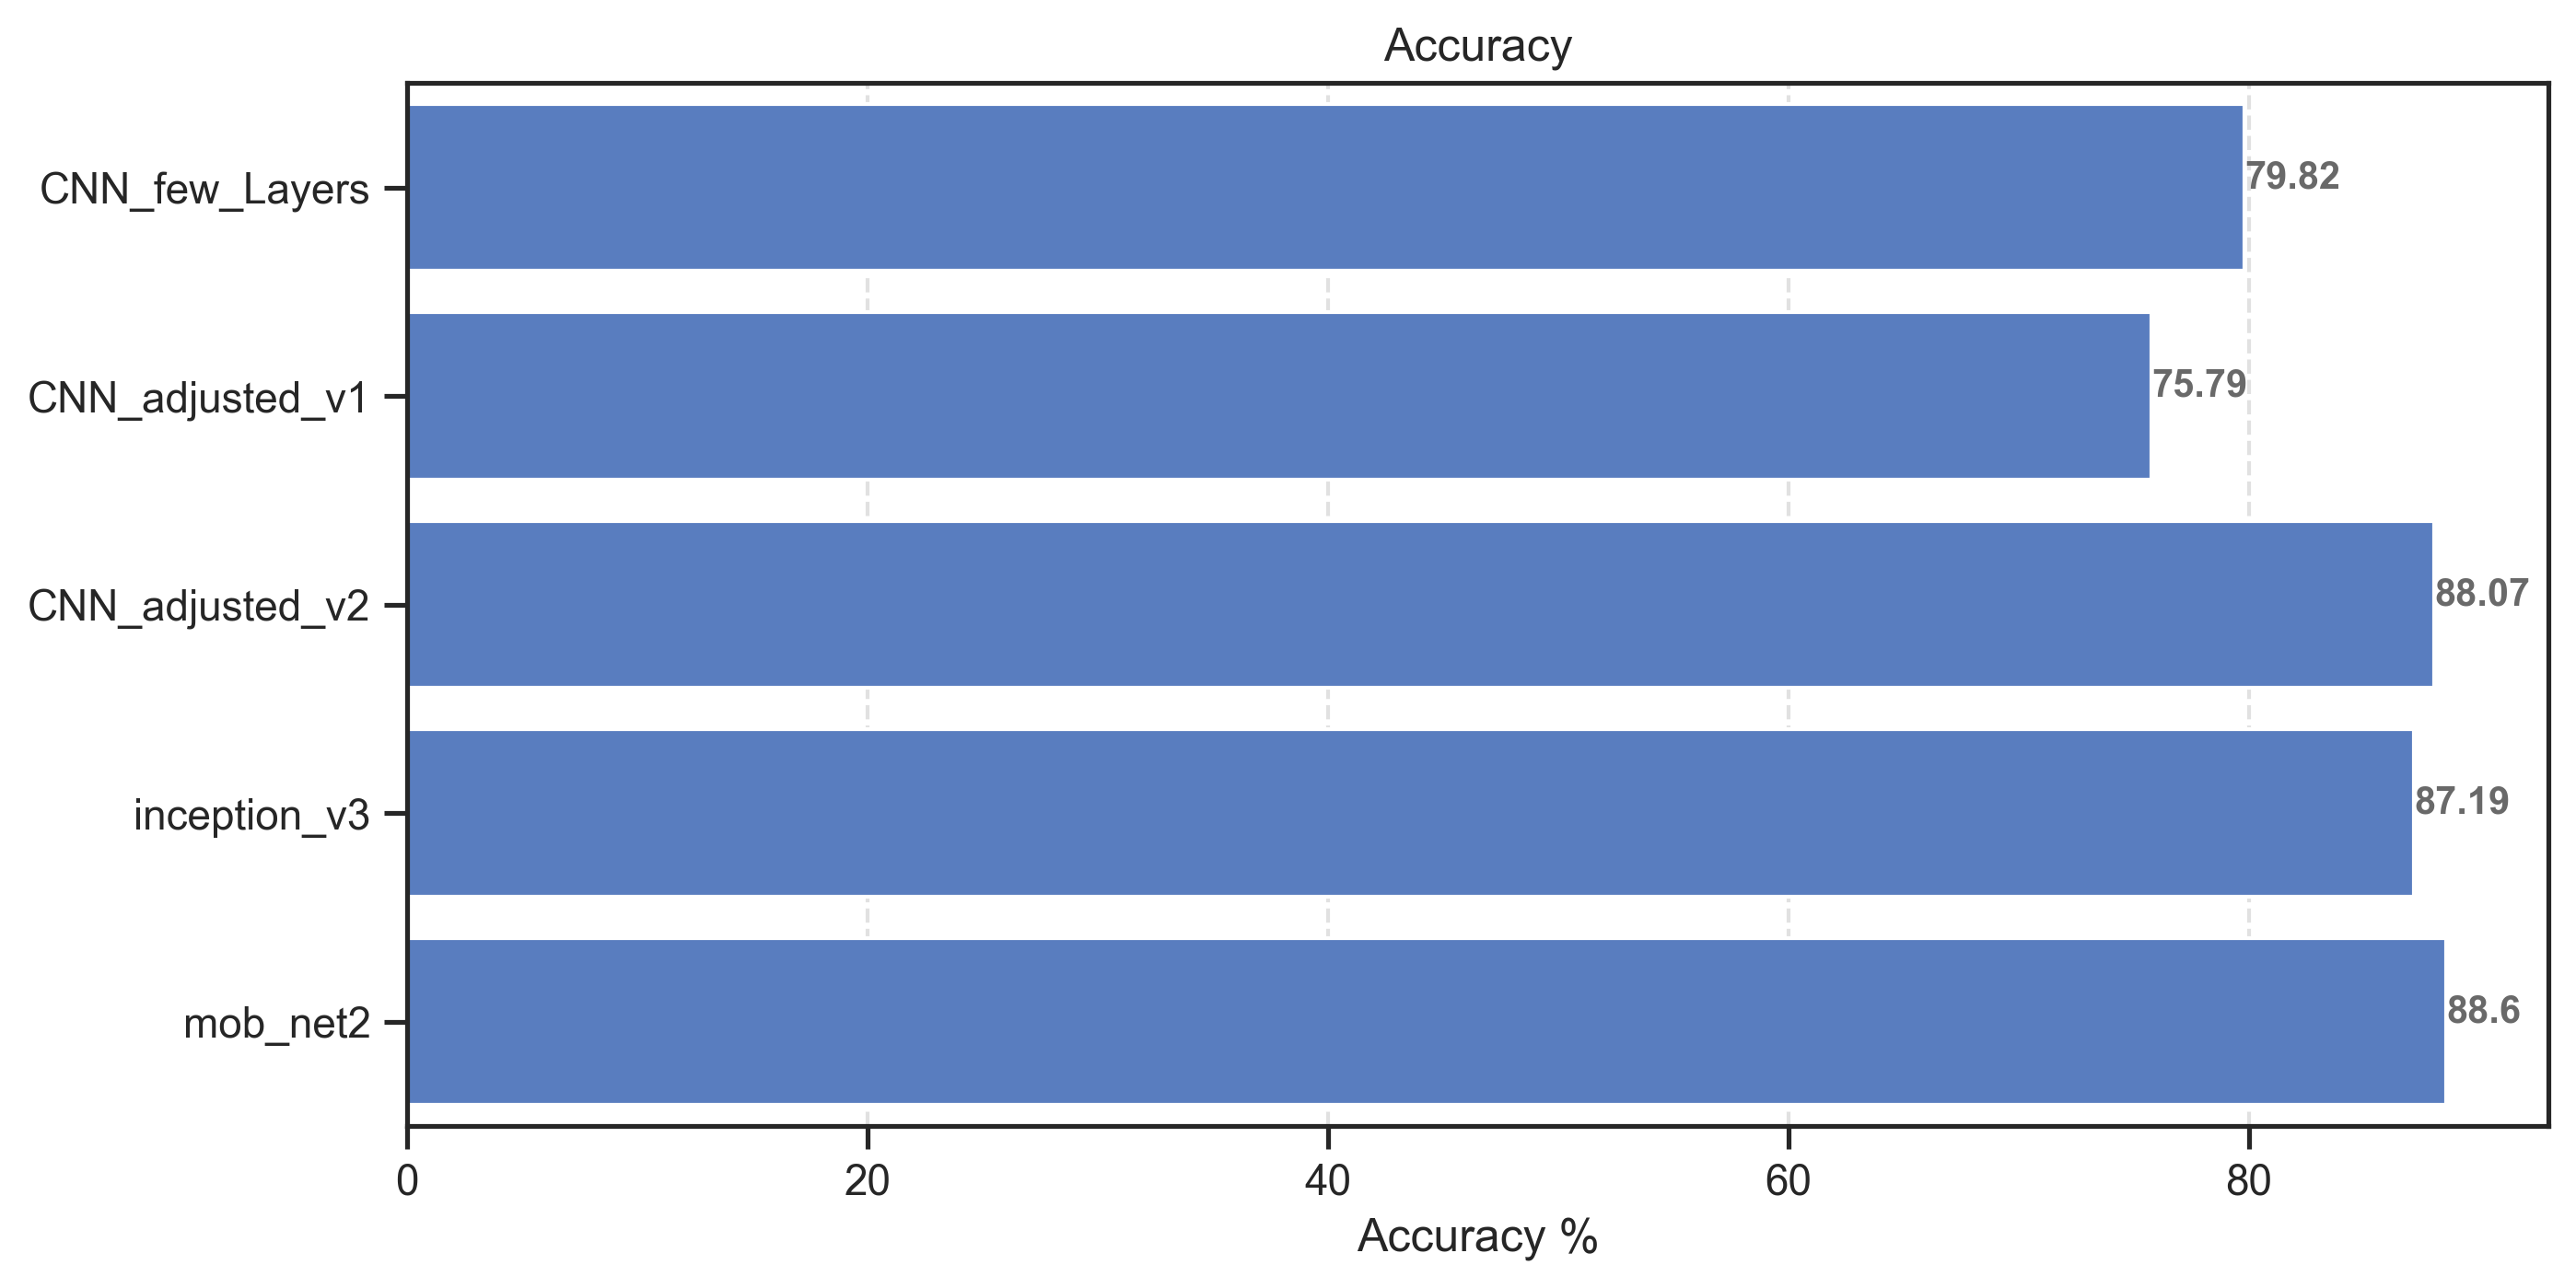

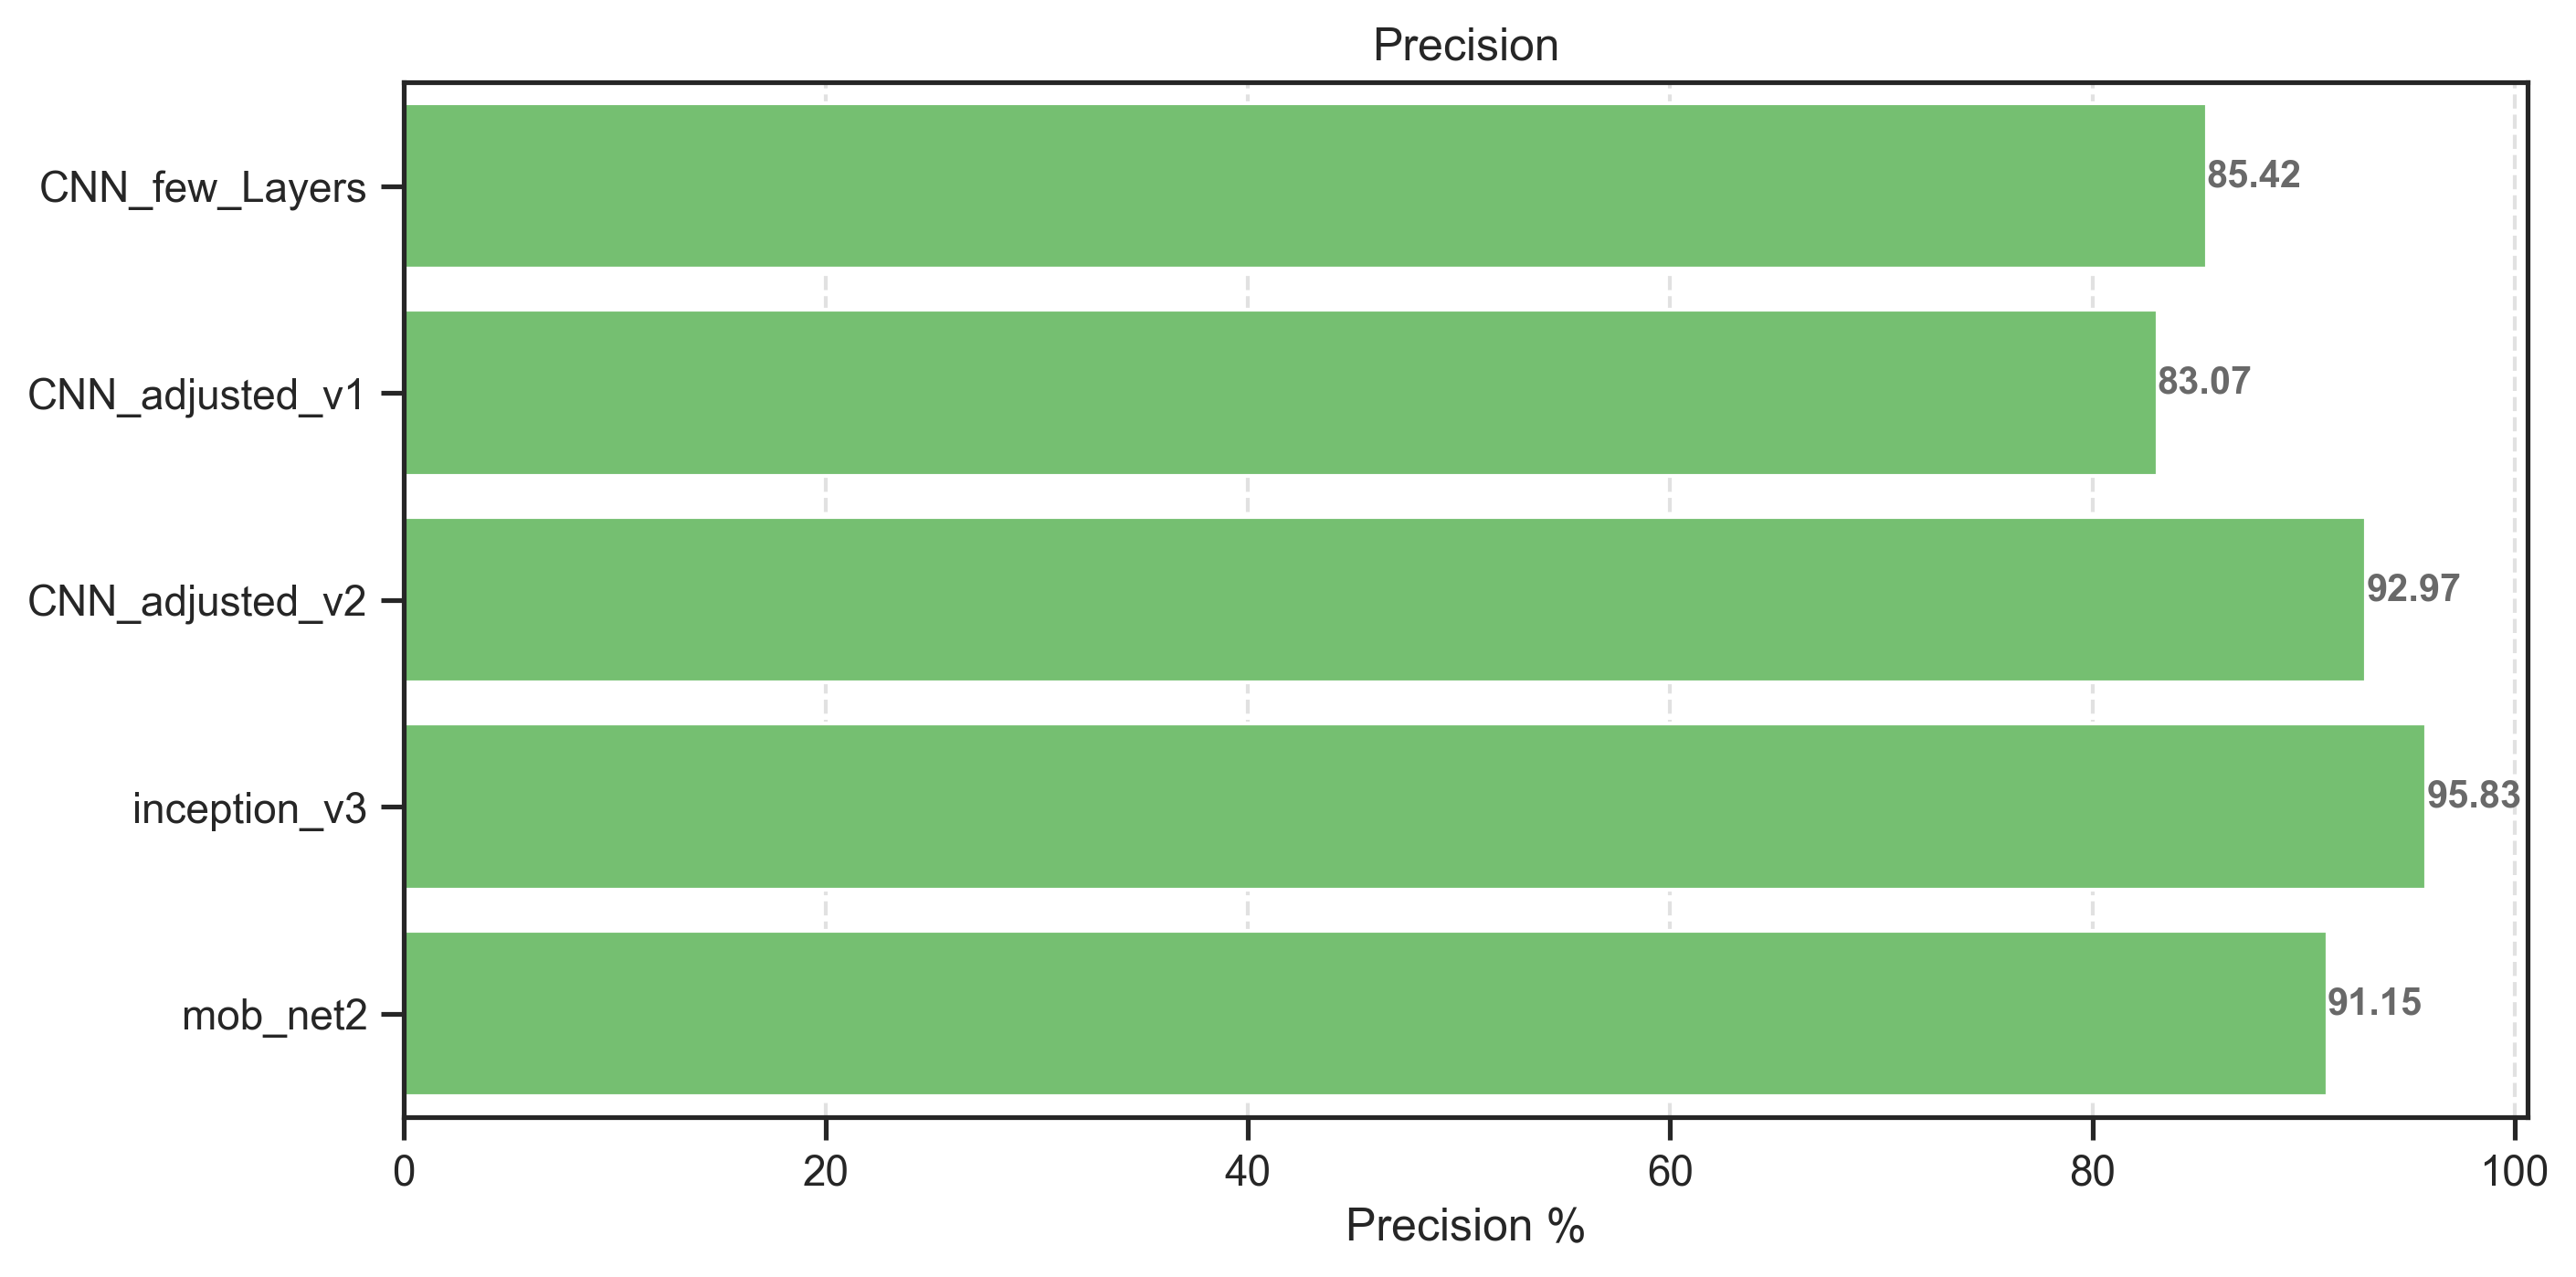

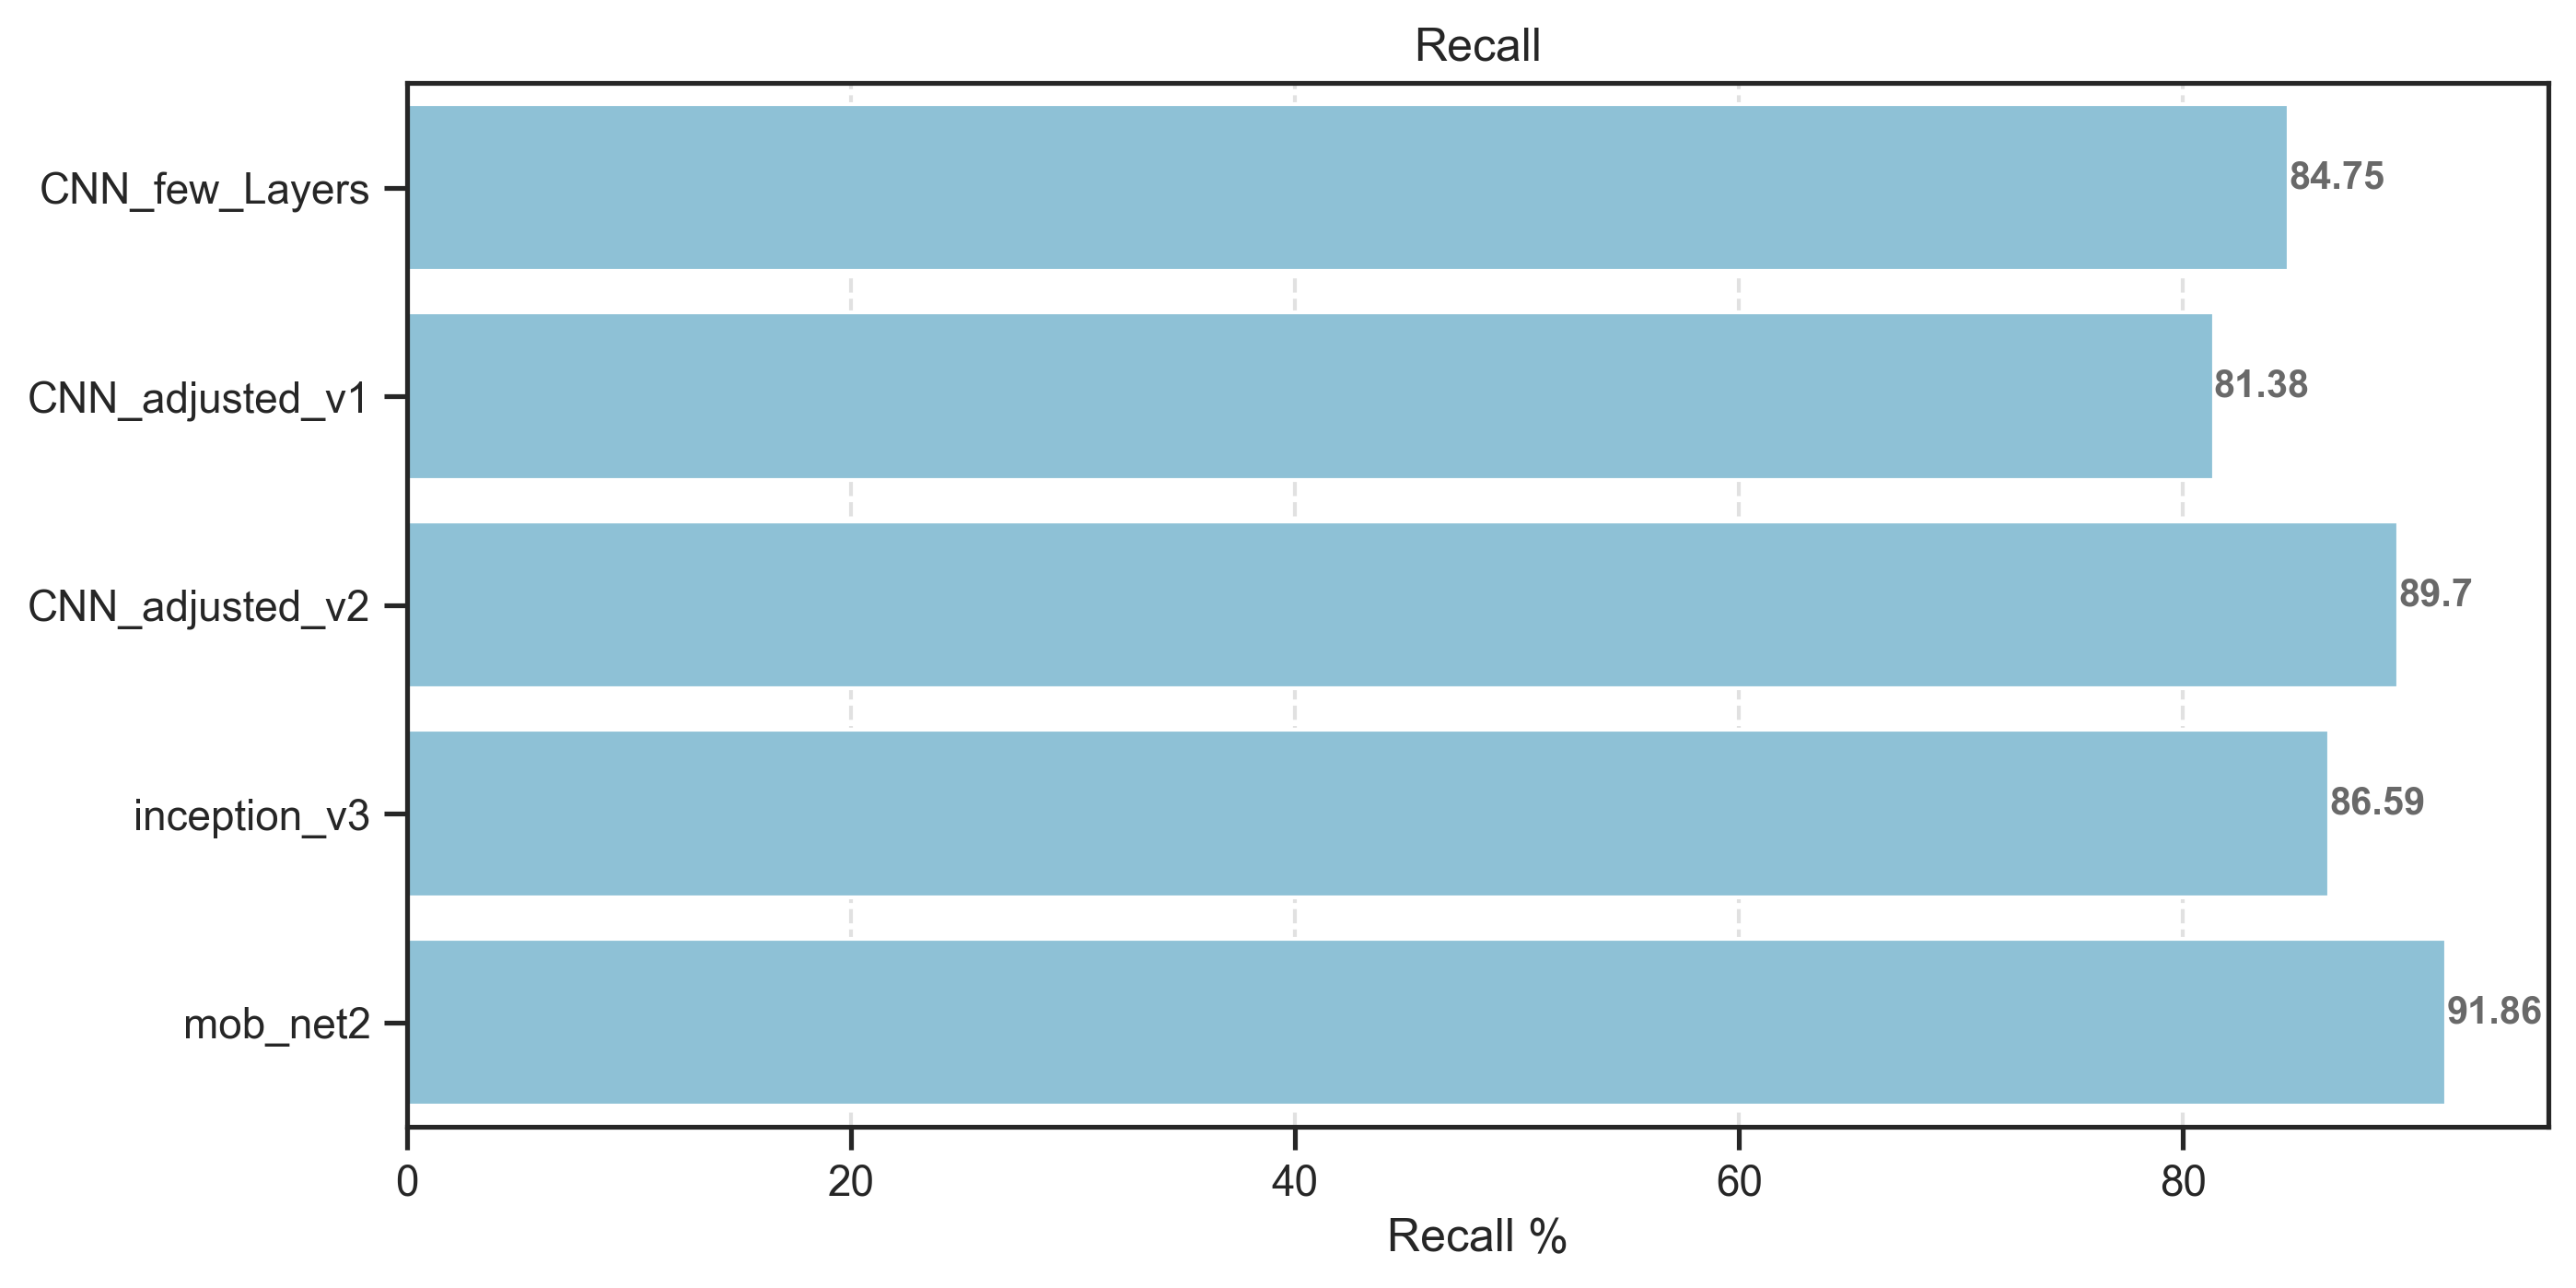

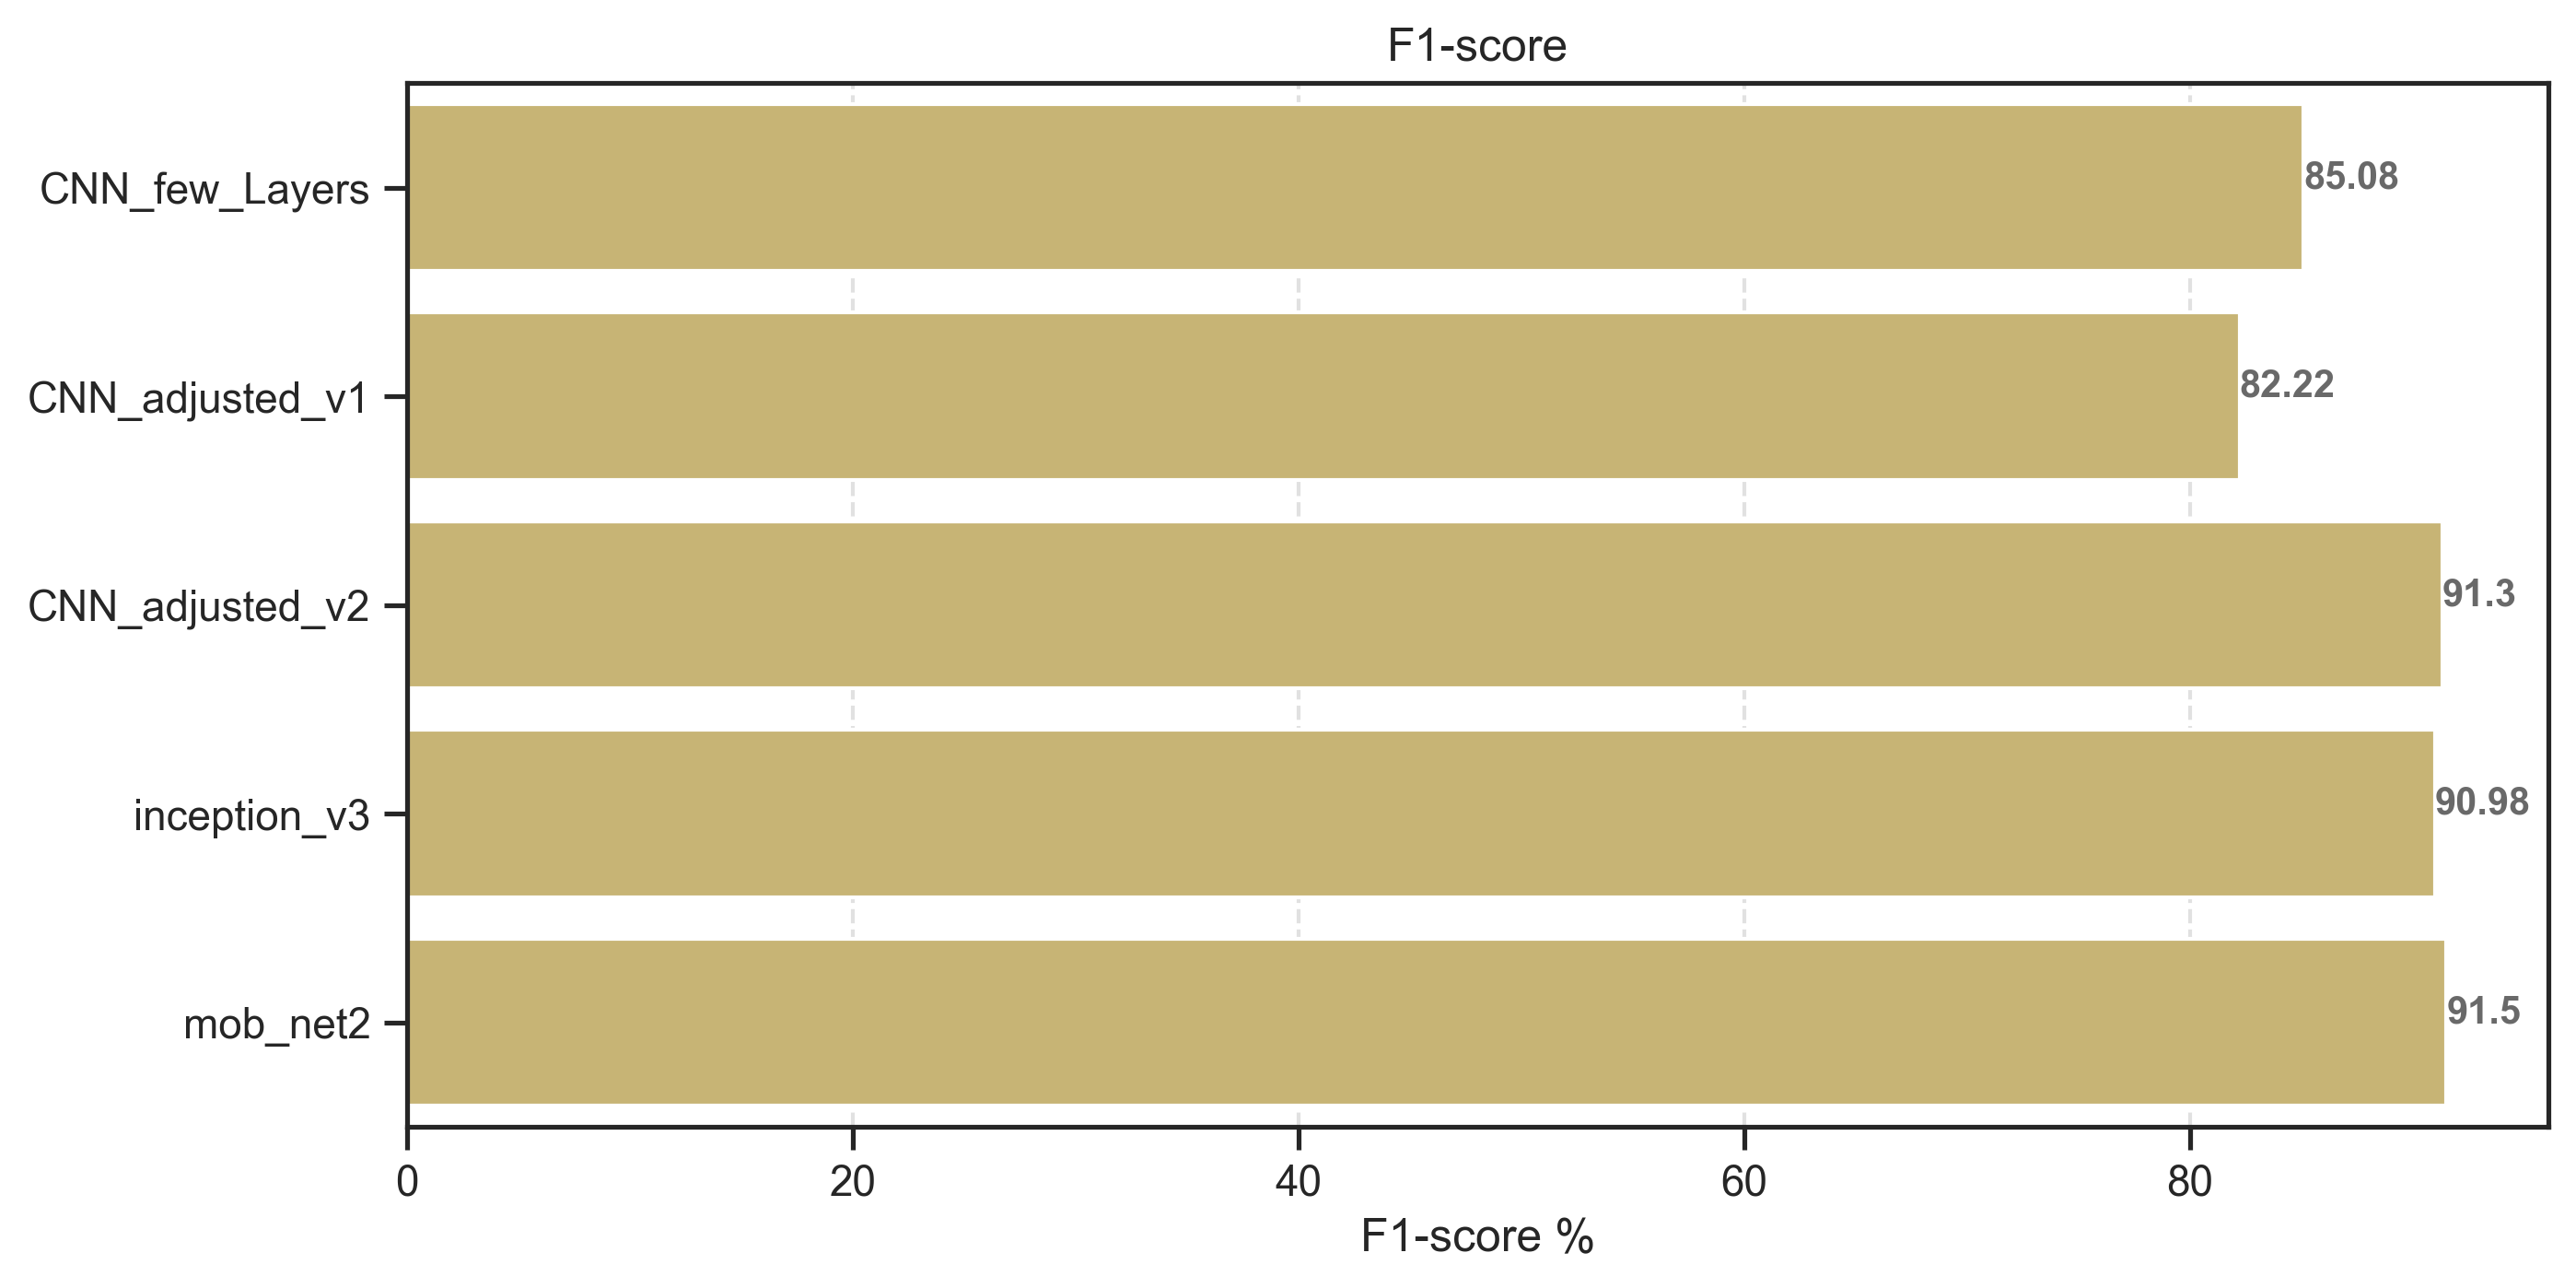

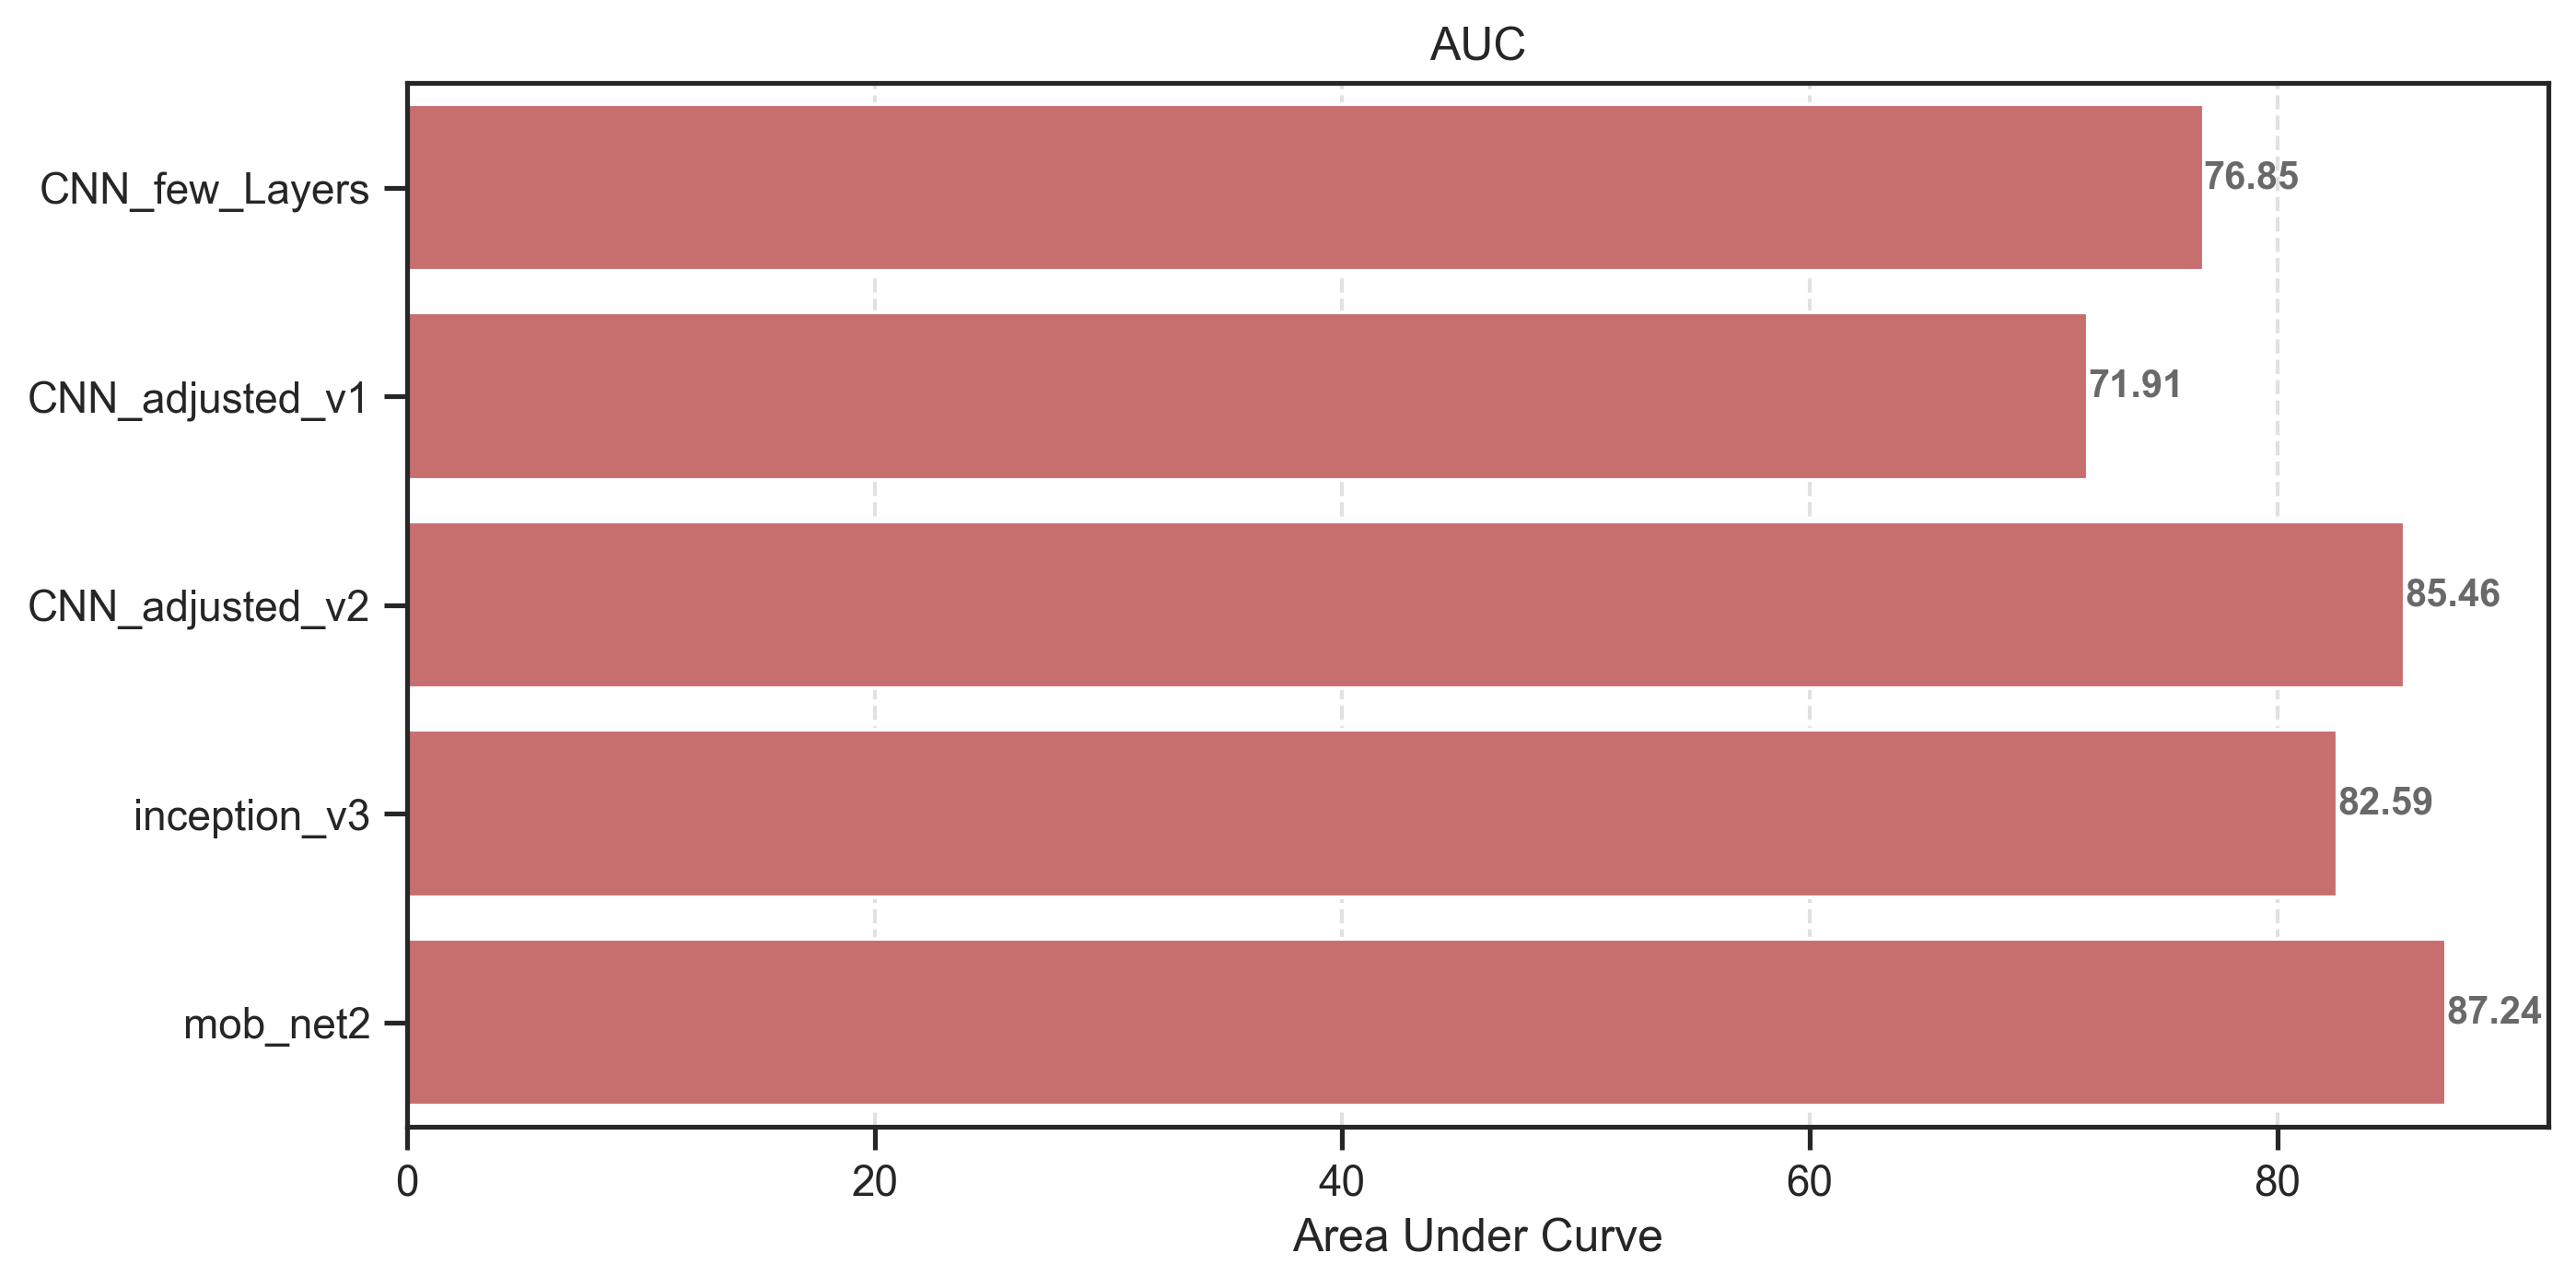

In [205]:
## Accuracy
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Accuracy %')
plt.ylabel('')
plt.title('Accuracy')
plt.show()

## Precision

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="g")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Precision %')
plt.ylabel('')
plt.title('Precision')
plt.show()

## Recall

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color='c')

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Recall %')
plt.ylabel('')
plt.title('Recall')
plt.show()

## F1

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=log, color="y")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('F1-score %')
plt.ylabel('')
plt.title('F1-score')
plt.show()

## AUC
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Classifier', data=log, color="r")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Area Under Curve')
plt.ylabel('')
plt.title('AUC')
plt.show()

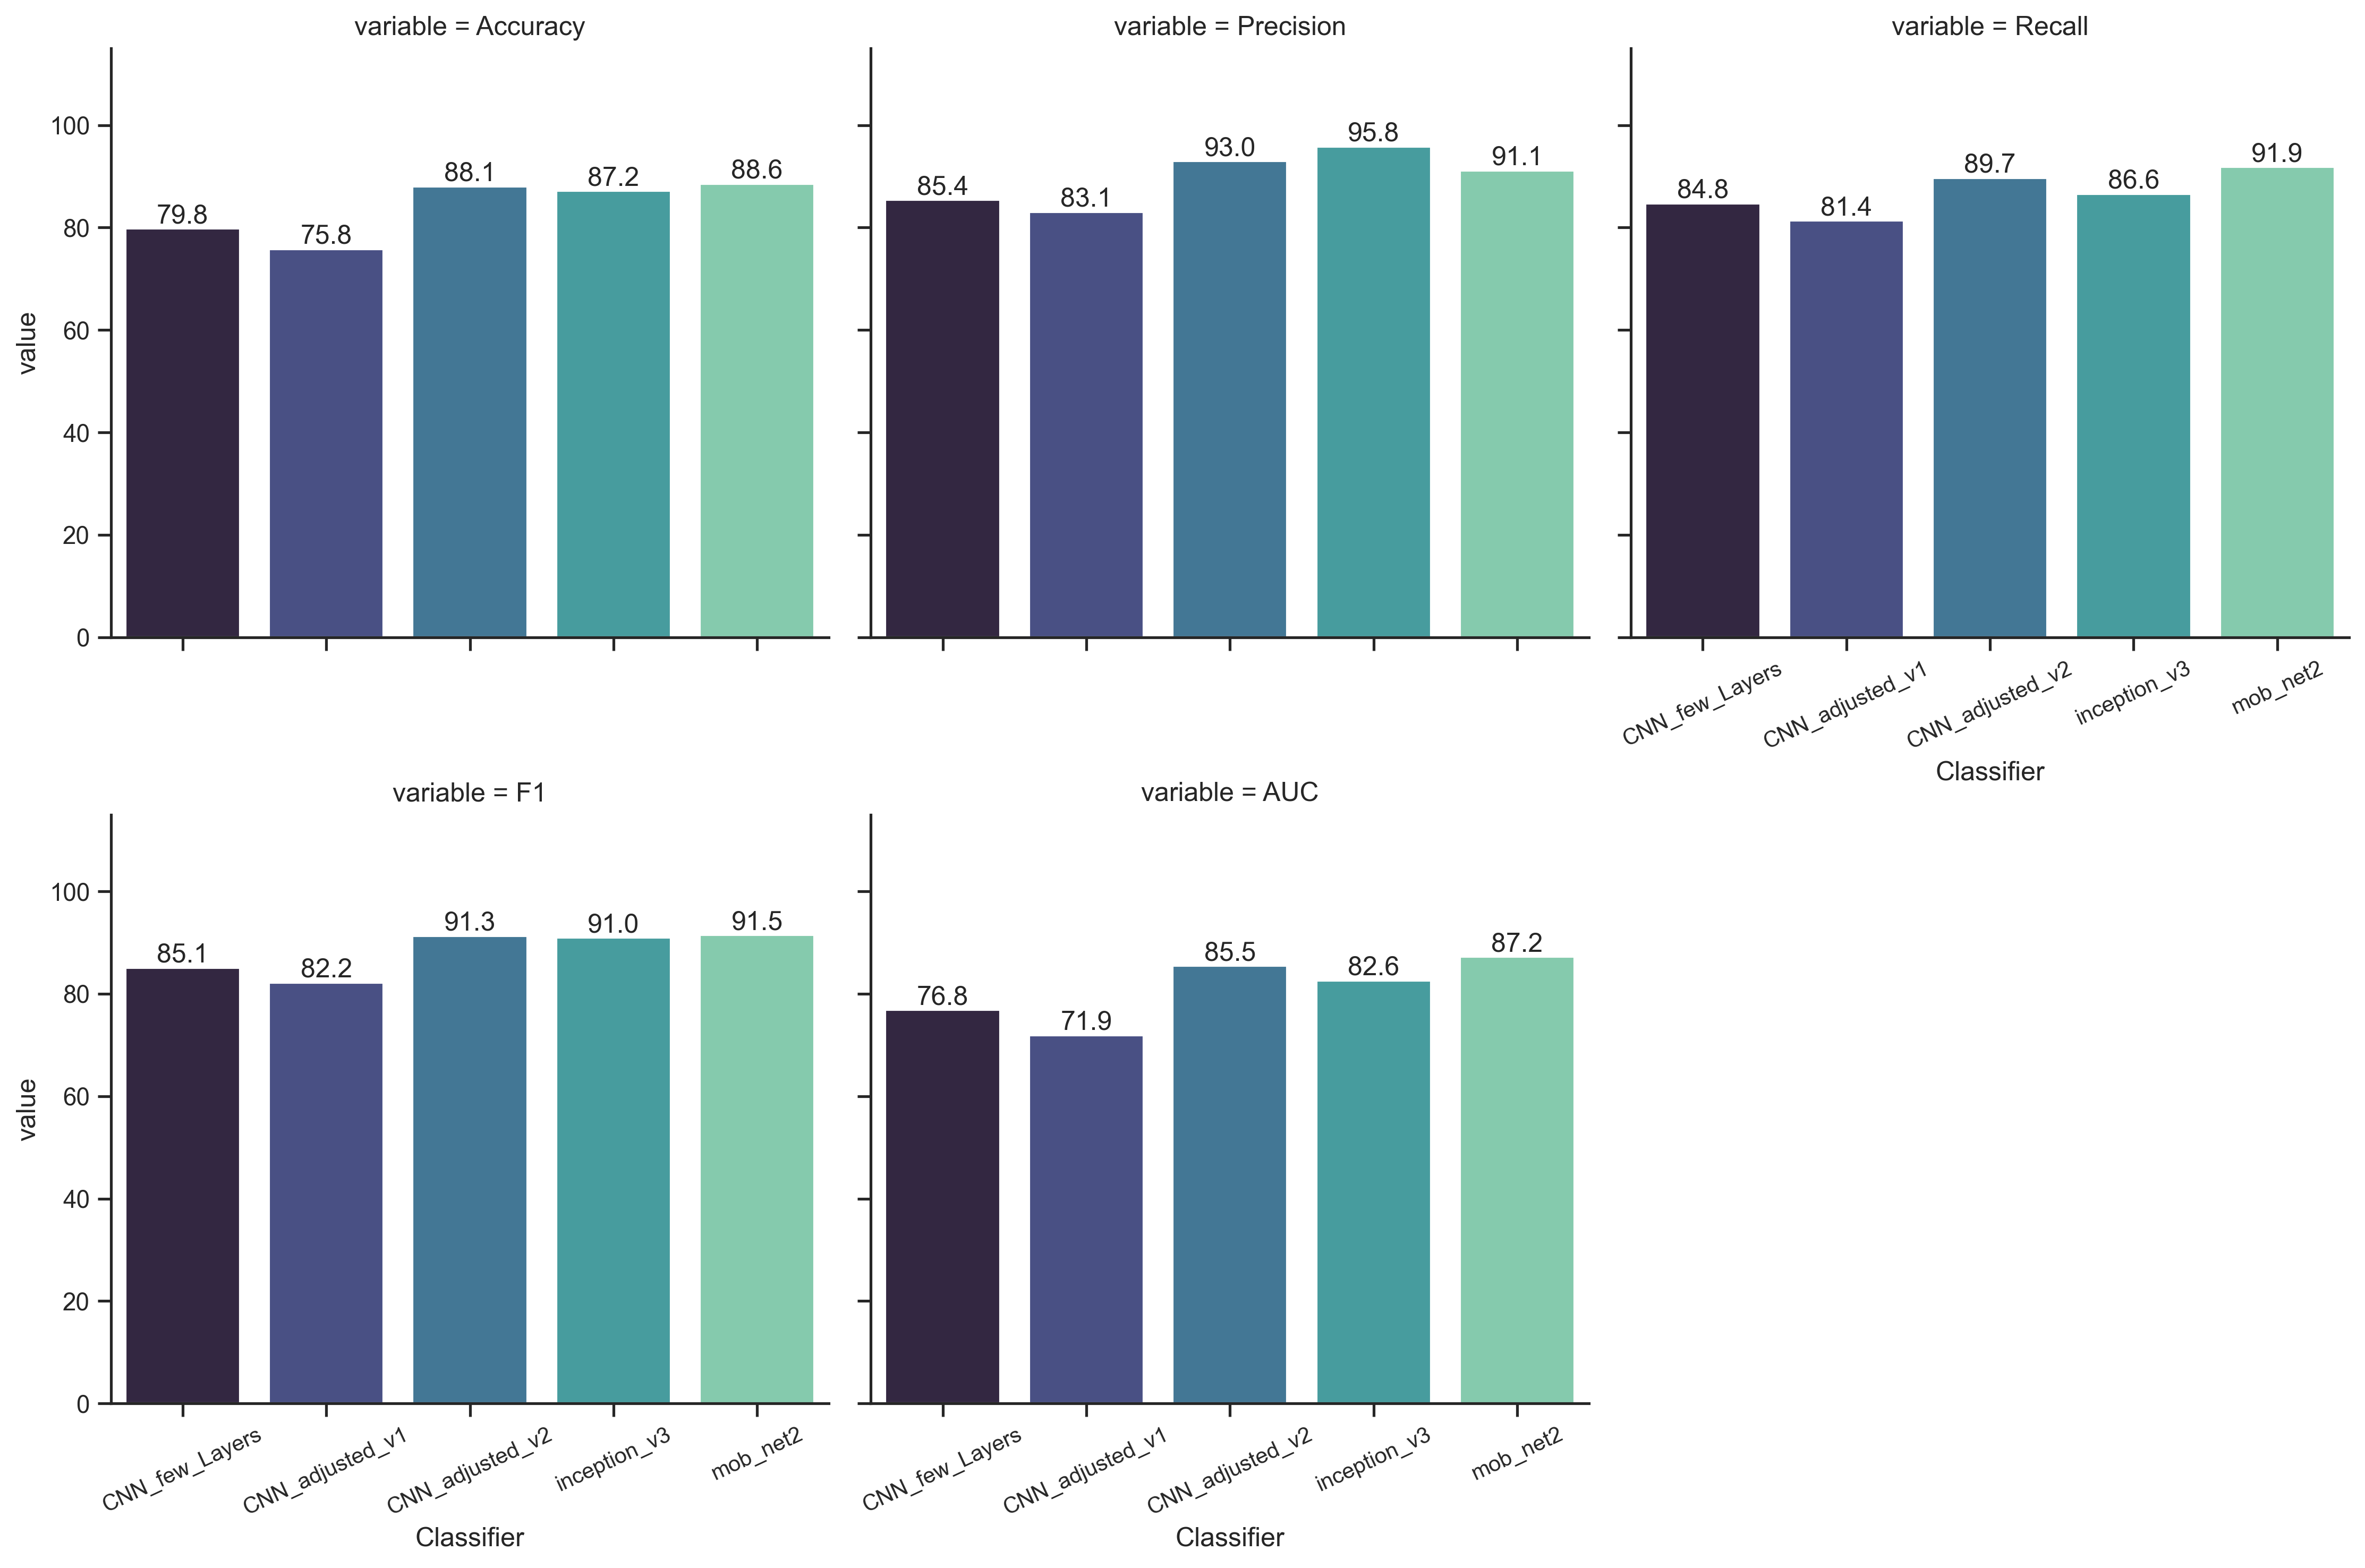

In [206]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

df2 = pd.melt(log, value_vars=[ "Accuracy", "Precision", "Recall", "F1", "AUC"], id_vars="Classifier")

#sns.set(style="ticks")

g = sns.catplot(data=df2,
                   kind="bar",
                   col="variable", # we have 1 plot per variable, forming 1 line and 5 columns (5 different variables)
                   x="Classifier", # in each plot the x-axis will be the name
                   y="value", # the height of the bar
                   col_wrap=3,# we actually want your line of plots to contain 3 plots maximum 
                   palette="mako", #Set2,Paired
                  )

# adding labels to bars
for ax in g.axes.ravel():
    for c in ax.containers:
        labels = [f'{(v.get_height()):.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

plt.ylabel('')
g.set_xticklabels(fontsize=10, rotation=25) # rotate the labels so they don't overlap
plt.tight_layout() # fit everything into the figure


### Plot Area Under Curve

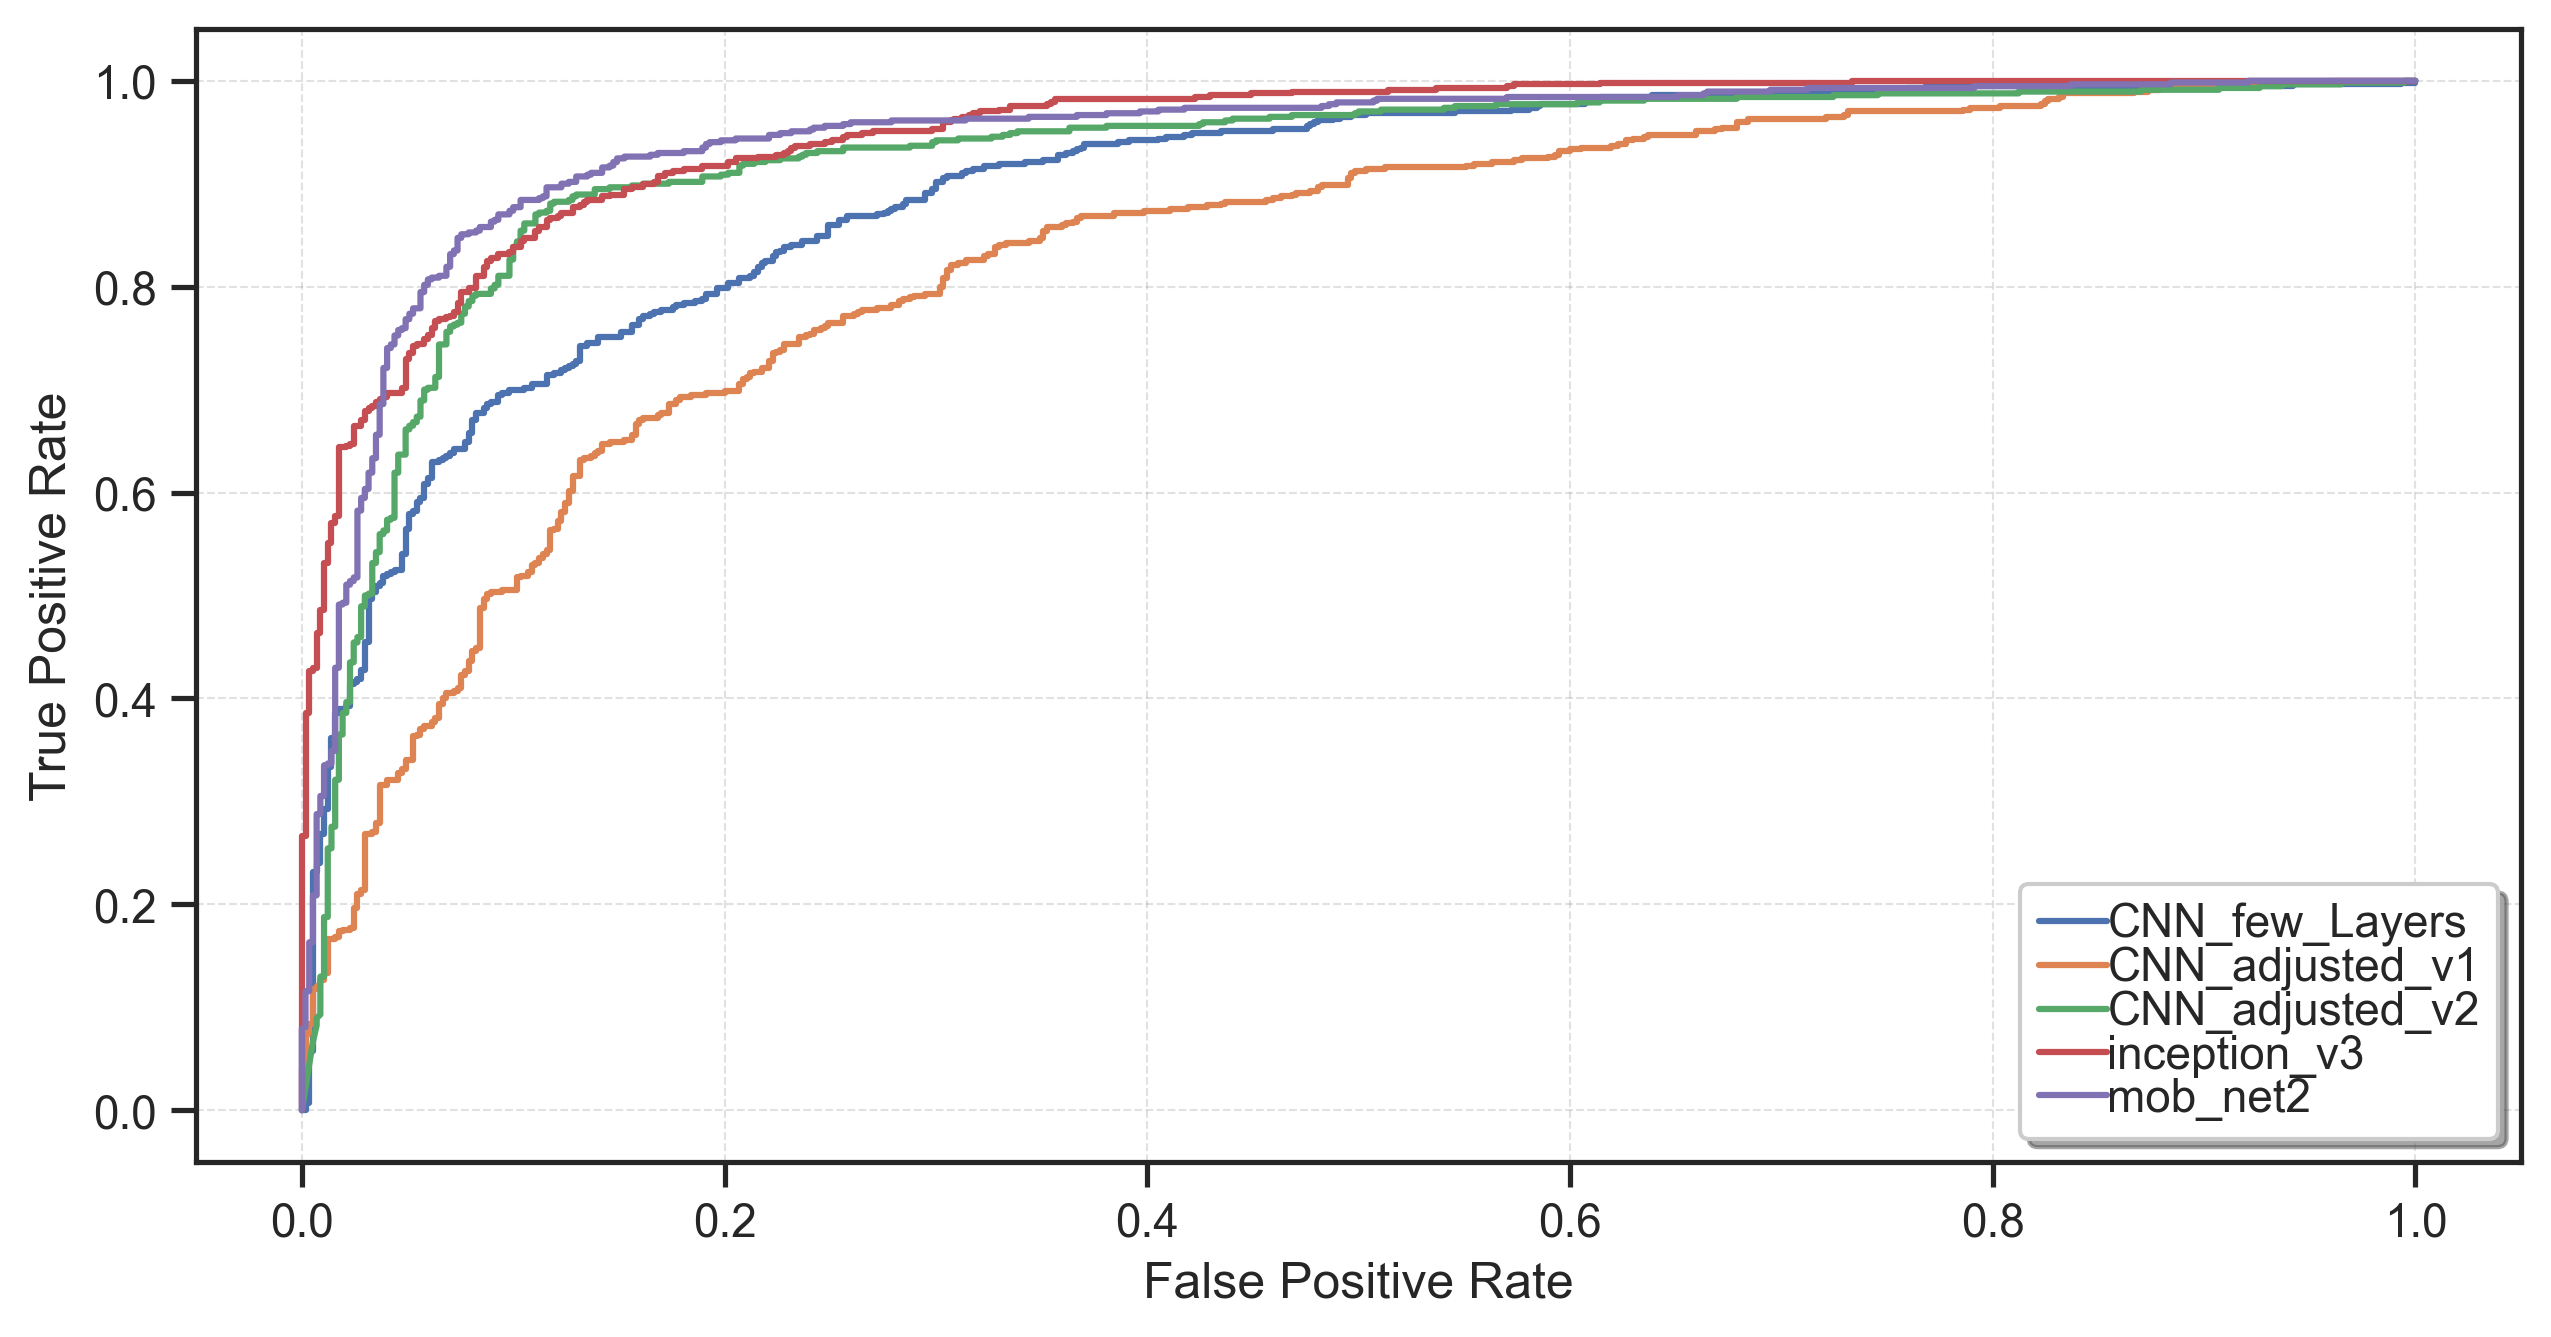

In [207]:
from sklearn import metrics

i=0
labels=[]

# Figure Size
plt.subplots(figsize =(10, 5))
# Add x, y gridlines
plt.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 0.5,
        alpha = 0.2)

# Plot models' ROC curves
for clf in classifiers:
  name = name_of_model[i]
  i+=1
  
  # if statement to select scaled data(-1, 1) for MobileNet2
  if name == name_of_model[-1]:
    pred = clf.predict(X_test_mn, verbose = 0).ravel() # Predict prob and get Class Indices
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test_mn.ravel(), pred) # Calculate ROC curves
  else:
    pred = clf.predict(X_test, verbose = 0).ravel()
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test.ravel(), pred)
  
  # plot the roc curve of the model
  plt.plot(ns_fpr, ns_tpr, linestyle='-', label=name)
  labels.append(name)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(labels, 
          columnspacing=1.0, 
          labelspacing=0.0,
          handletextpad=0.0, 
          handlelength=1.5,
          fancybox=True,
          shadow=True)
   
# show the plot
plt.show()

### Accuracy vs False Negative Rate

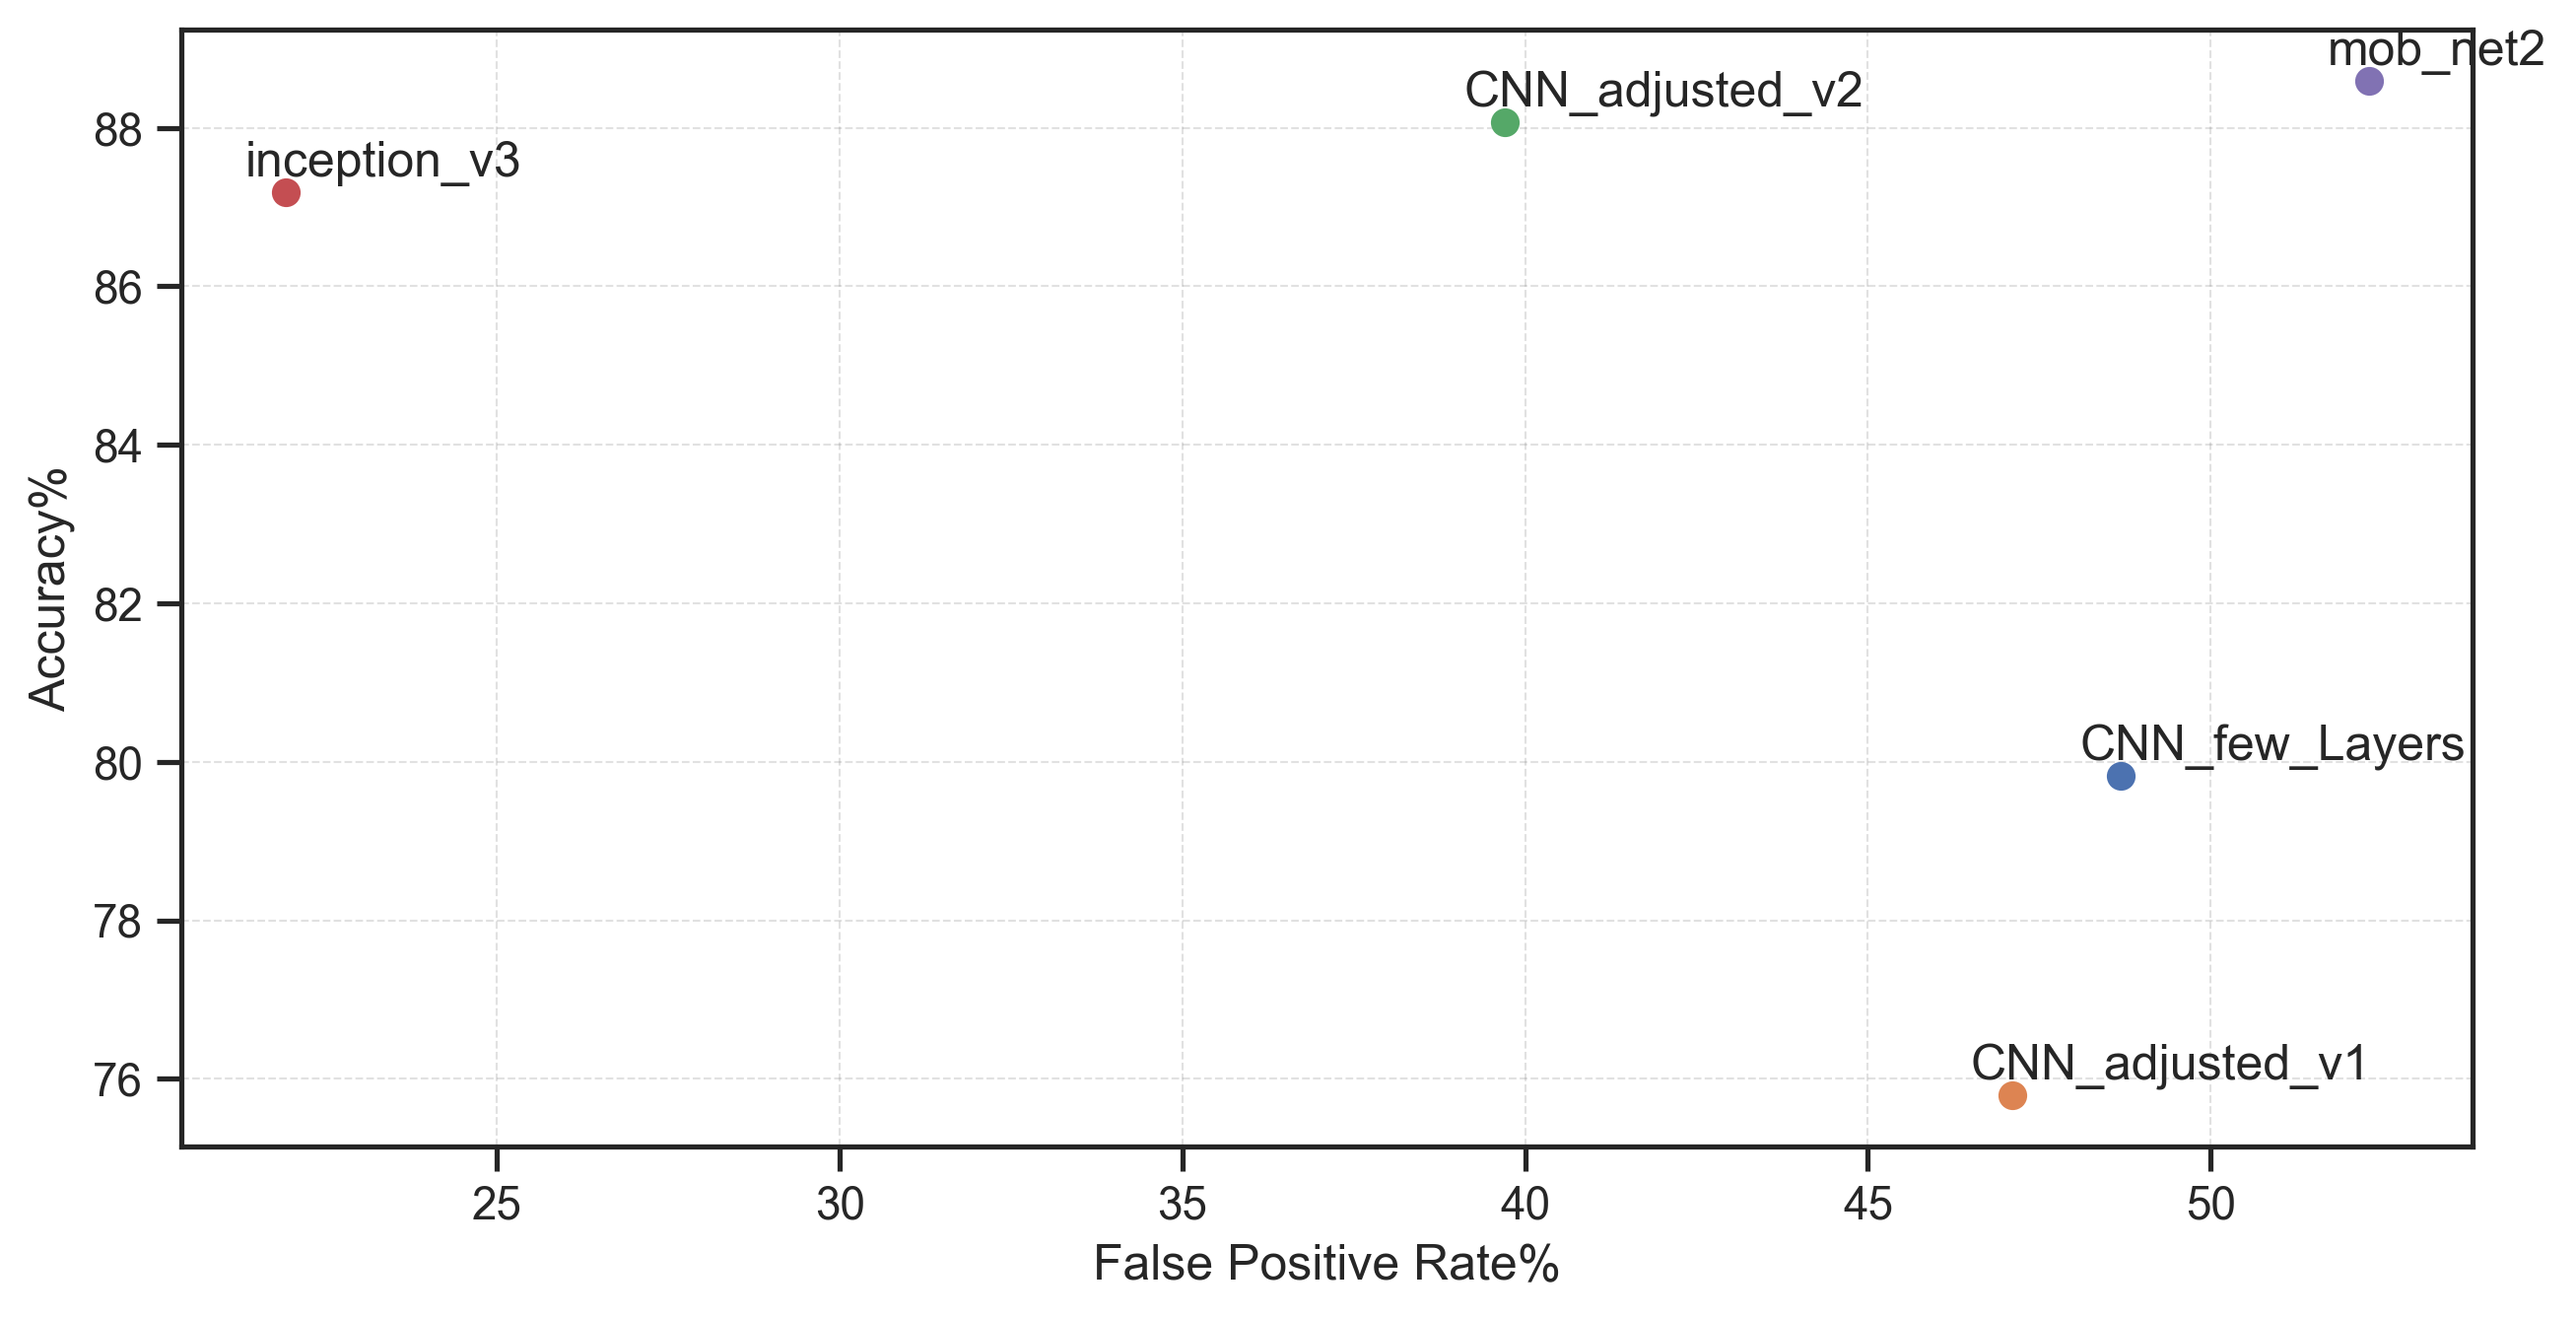

In [208]:
i=0
labels=[]

# Figure Size
plt.subplots(figsize =(10, 5))

# Add x, y gridlines
plt.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 0.5,
        alpha = 0.2)

# Plot several different AUC
for clf in classifiers:
  name = name_of_model[i]
  i+=1    
  
  # if statement to select scaled data(-1, 1) for MobileNet2
  if name == name_of_model[-1]:
    y_true = np.argmax(y_test_mn, axis = 1)[:]
    pred = clf.predict(X_test_mn, verbose = 0) # Predict prob and get Class Indices
    y_pred= np.argmax(pred, axis = 1)[:]
  else:
    y_true = np.argmax(y_test, axis = 1)[:]
    pred = clf.predict(X_test, verbose = 0)
    y_pred= np.argmax(pred, axis = 1)[:]
  
  cf = confusion_matrix(y_true, y_pred)
  fpr = (cf[1][0] / ( cf[1][0] + cf[0][1] ))*100
  acc = log.loc[log['Classifier']==name,'Accuracy']
  
  plt.scatter(fpr, acc)#, label=name)
  #labels.append(name)

  plt.annotate(name, (fpr-0.6, acc+0.2))
  
# axis labels
plt.xlabel('False Positive Rate%')
plt.ylabel('Accuracy%')
#plt.legend(labels, 
          # columnspacing=1.0, 
          # labelspacing=0.0,
          # handletextpad=0.0, 
          # handlelength=1.5,
          # fancybox=True,
          # shadow=True)
   
# show the plot
plt.show()

## Appendix

### Images with bounding box on head

In [209]:
cropped_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            image = cv2.cvtColor(np.array(img_temp), cv2.INPAINT_TELEA)
            helmet = np.zeros(image.shape, dtype = 'int32')

            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        xmin = int(i['bndbox']['xmin'])
                        ymin = int(i['bndbox']['ymin'])
                        xmax = int(i['bndbox']['xmax'])
                        ymax = int(i['bndbox']['ymax'])
                        if i['name'] == 'With Helmet':
                            helmet = cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3) #with helmet -> 1
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                            #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                            
                        else:
                            cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                            
                            #plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                if isinstance(tags['object'], dict):
                    xmin = int(tags['object']['bndbox']['xmin'])
                    ymin = int(tags['object']['bndbox']['ymin'])
                    xmax = int(tags['object']['bndbox']['xmax'])
                    ymax = int(tags['object']['bndbox']['ymax'])
                    if tags['object']['name'] == 'With Helmet':
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path]) #with helmet -> 1
                        #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                    else:
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                    # plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
            else:
                pass
    except:
        pass

### Data preprocessing

#### Data reshaping

In [210]:
from tensorflow.keras.preprocessing.image import array_to_img
all_cropped_imgs_v2 = []
for i in range(1, len(cropped_imgs)):
    try:
        img_temp = array_to_img(cropped_imgs[i][1])
        resized = img_temp.resize((120,120)) # resize all images to 40x40
        image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
        all_cropped_imgs_v2.append([cropped_imgs[i][0], image, cropped_imgs[i][2], cropped_imgs[i][3]])
    except:
        pass

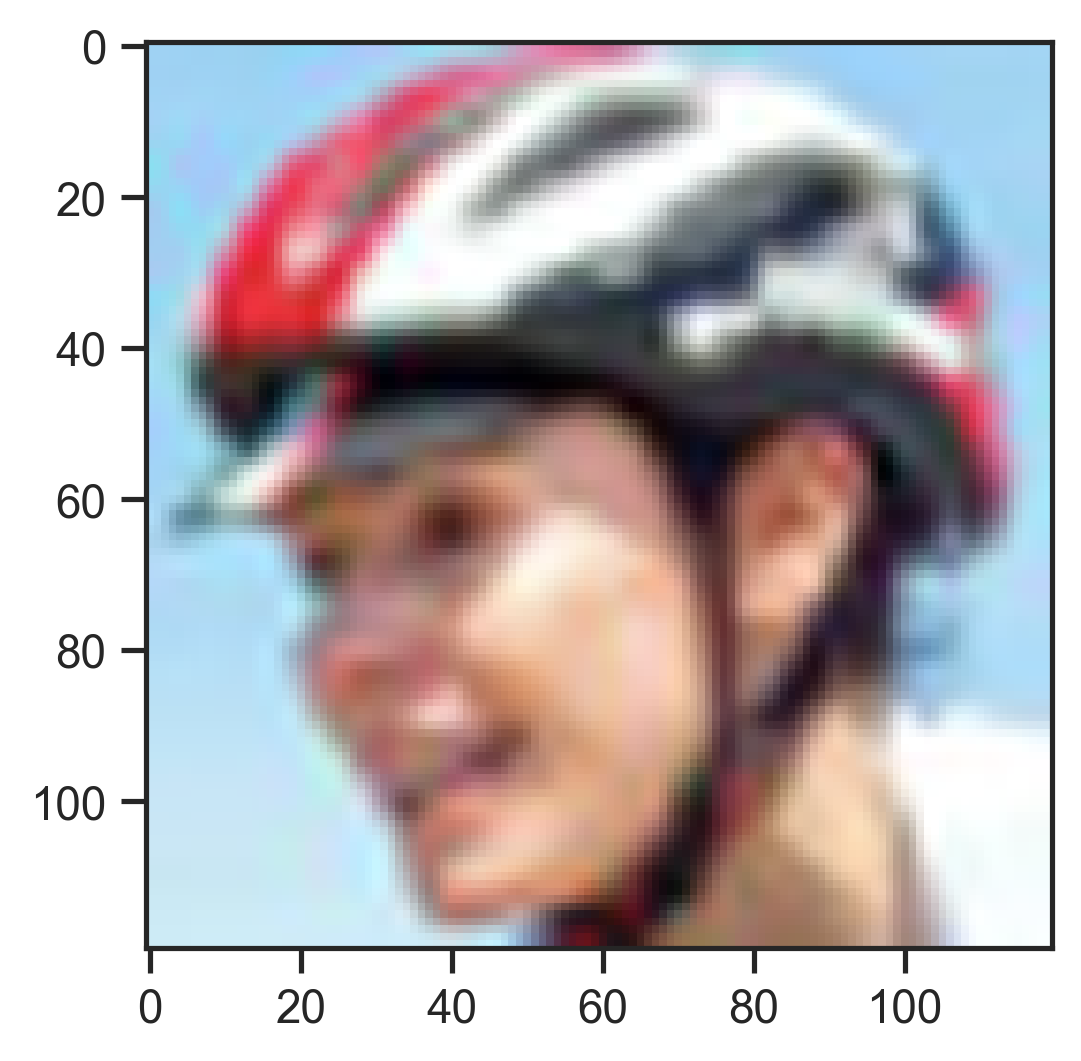

In [211]:
plt.imshow(all_cropped_imgs_v2[1110][1], interpolation='nearest')

In [212]:
# Transforming images in a proper array for model input
cropped_imgs_array = []
for i in range(0, len(all_cropped_imgs_v2)):
    cropped_imgs_array.append(np.array(all_cropped_imgs_v2[i][1]))
    
cropped_imgs_array = np.array(cropped_imgs_array, dtype='int')

# Creating an array with labels
labels_array_cropped = []
for i in range(0, len(all_cropped_imgs_v2)):
    labels_array_cropped.append(np.array(all_cropped_imgs_v2[i][2]))
  
labels_array_cropped = np.array(labels_array_cropped, dtype='int')

# Categorically encode the labels
cropped_imgs_labels = to_categorical(labels_array_cropped)

In [213]:
data_cropped, input_shape_cr = reshape_img_input(x=cropped_imgs_array,
                                         img_rows=120, 
                                         img_cols=120,
                                         normalize=True)

Original shape of nd-array: (1433, 120, 120, 3)


#### Train, Test & Validation split

In [214]:
from sklearn.model_selection import train_test_split
X_train_cr, X_test_1_cr, y_train_cr, y_test_1_cr = train_test_split(data_cropped, cropped_imgs_labels,
                                                    stratify=cropped_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test_cr, X_val_cr, y_test_cr, y_val_cr = train_test_split(X_test_1_cr, y_test_1_cr,
                                                    stratify=y_test_1_cr, 
                                                    test_size=0.25, random_state=5)

In [215]:

X_test_cr[1].shape

(120, 120, 3)

### Fitting InceptionV3 on cropped images

In [216]:
inceptv3_cropped = InceptionV3(
    weights = "imagenet",
    input_shape = (120, 120, 3),
    include_top = False 
)

for layer in inceptv3_cropped.layers:
    layer.trainable = False

inputs = Input(shape=(120, 120, 3))
x = inceptv3_cropped(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
inception_v3_cropped = Model(inputs, outputs)

inception_v3_cropped.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 120, 120, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_11  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [217]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
inception_v3_cropped.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

In [218]:
model_cropped = inception_v3_cropped.fit(
                    x = X_train_cr,
                    y = y_train_cr,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val_cr, y_val_cr),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 55s 719ms/step - loss: 2.6552 - accuracy: 0.8387 - recall: 0.8387 - precision: 0.8387 - auc: 0.8679 - val_loss: 0.9821 - val_accuracy: 0.8556 - val_recall: 0.8556 - val_precision: 0.8556 - val_auc: 0.8967 - lr: 0.0100
Epoch 2/50
71/71 [==============================] - 49s 688ms/step - loss: 0.4363 - accuracy: 0.9381 - recall: 0.9381 - precision: 0.9381 - auc: 0.9672 - val_loss: 0.3286 - val_accuracy: 0.9111 - val_recall: 0.9111 - val_precision: 0.9111 - val_auc: 0.9752 - lr: 0.0100
Epoch 3/50
71/71 [==============================] - 48s 677ms/step - loss: 0.3067 - accuracy: 0.9349 - recall: 0.9349 - precision: 0.9349 - auc: 0.9754 - val_loss: 0.6278 - val_accuracy: 0.8889 - val_recall: 0.8889 - val_precision: 0.8889 - val_auc: 0.9425 - lr: 0.0100
Epoch 4/50
71/71 [==============================] - 48s 672ms/step - loss: 0.1031 - accuracy: 0.9728 - recall: 0.9728 - precision: 0.9728 - auc: 0.9922 - val_loss: 0.0857 - val_accuracy: 0.9

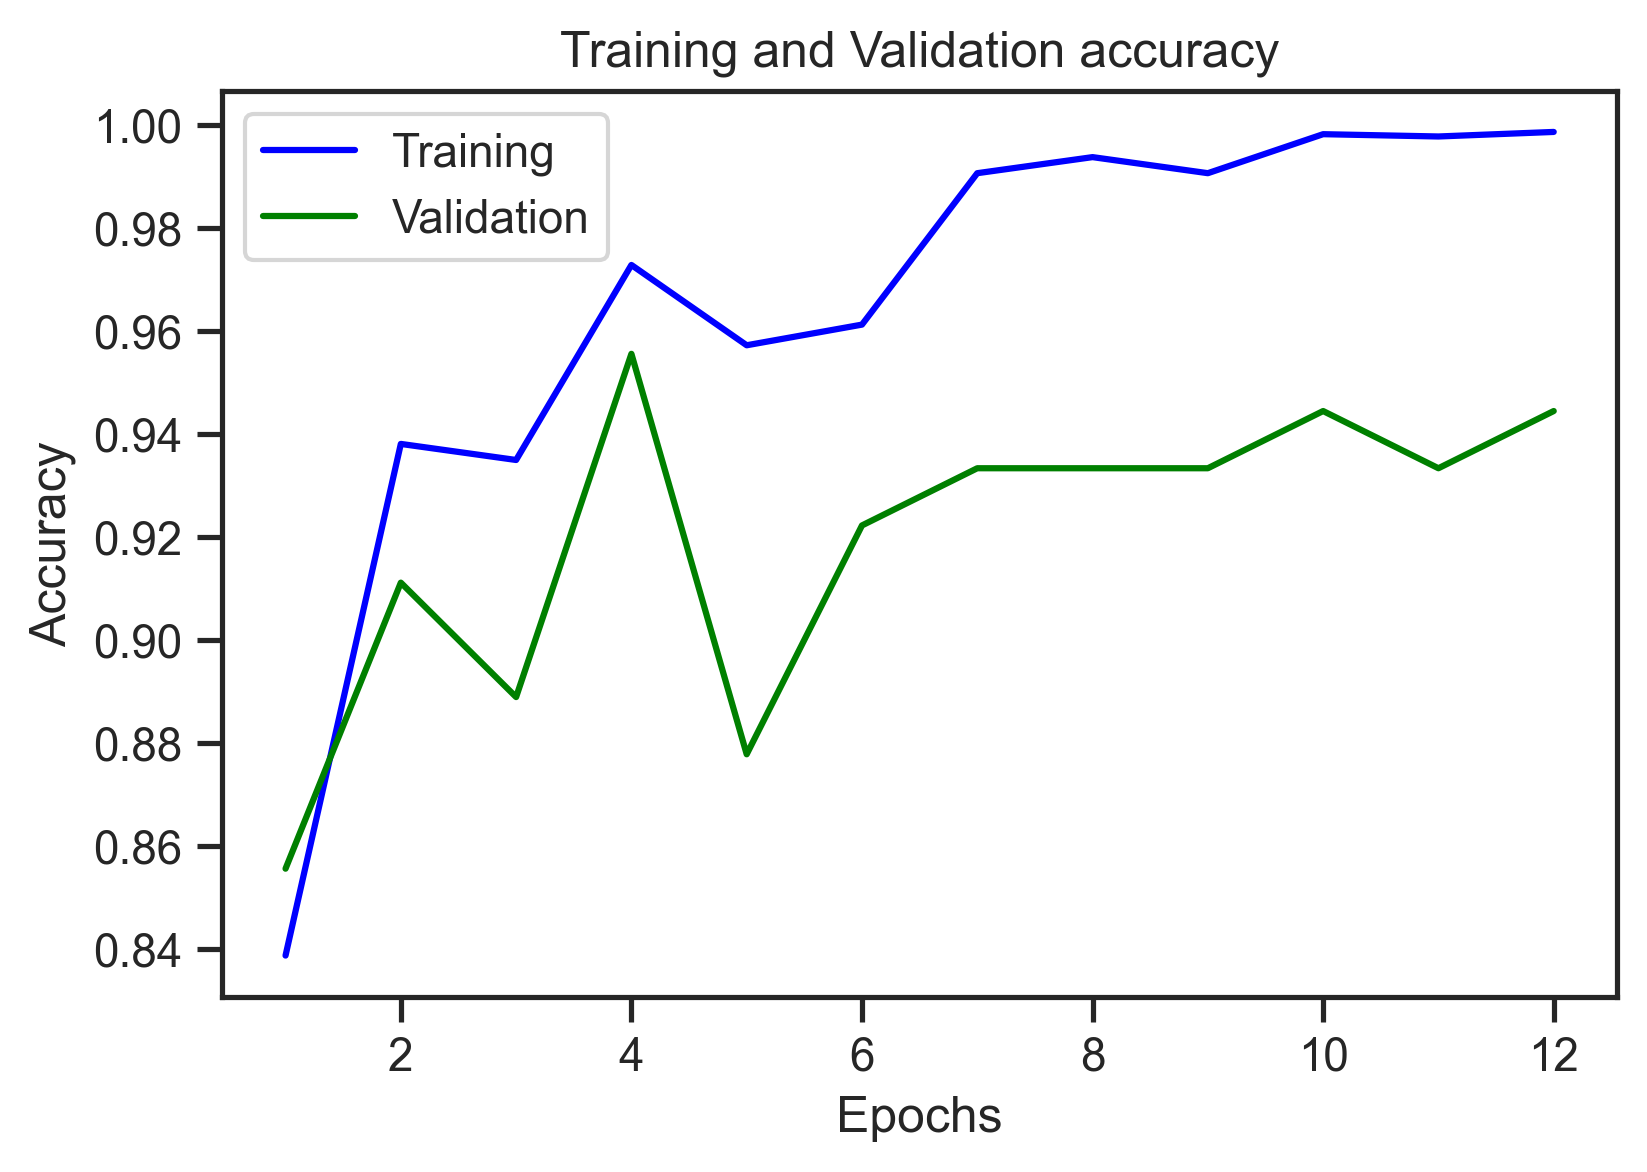

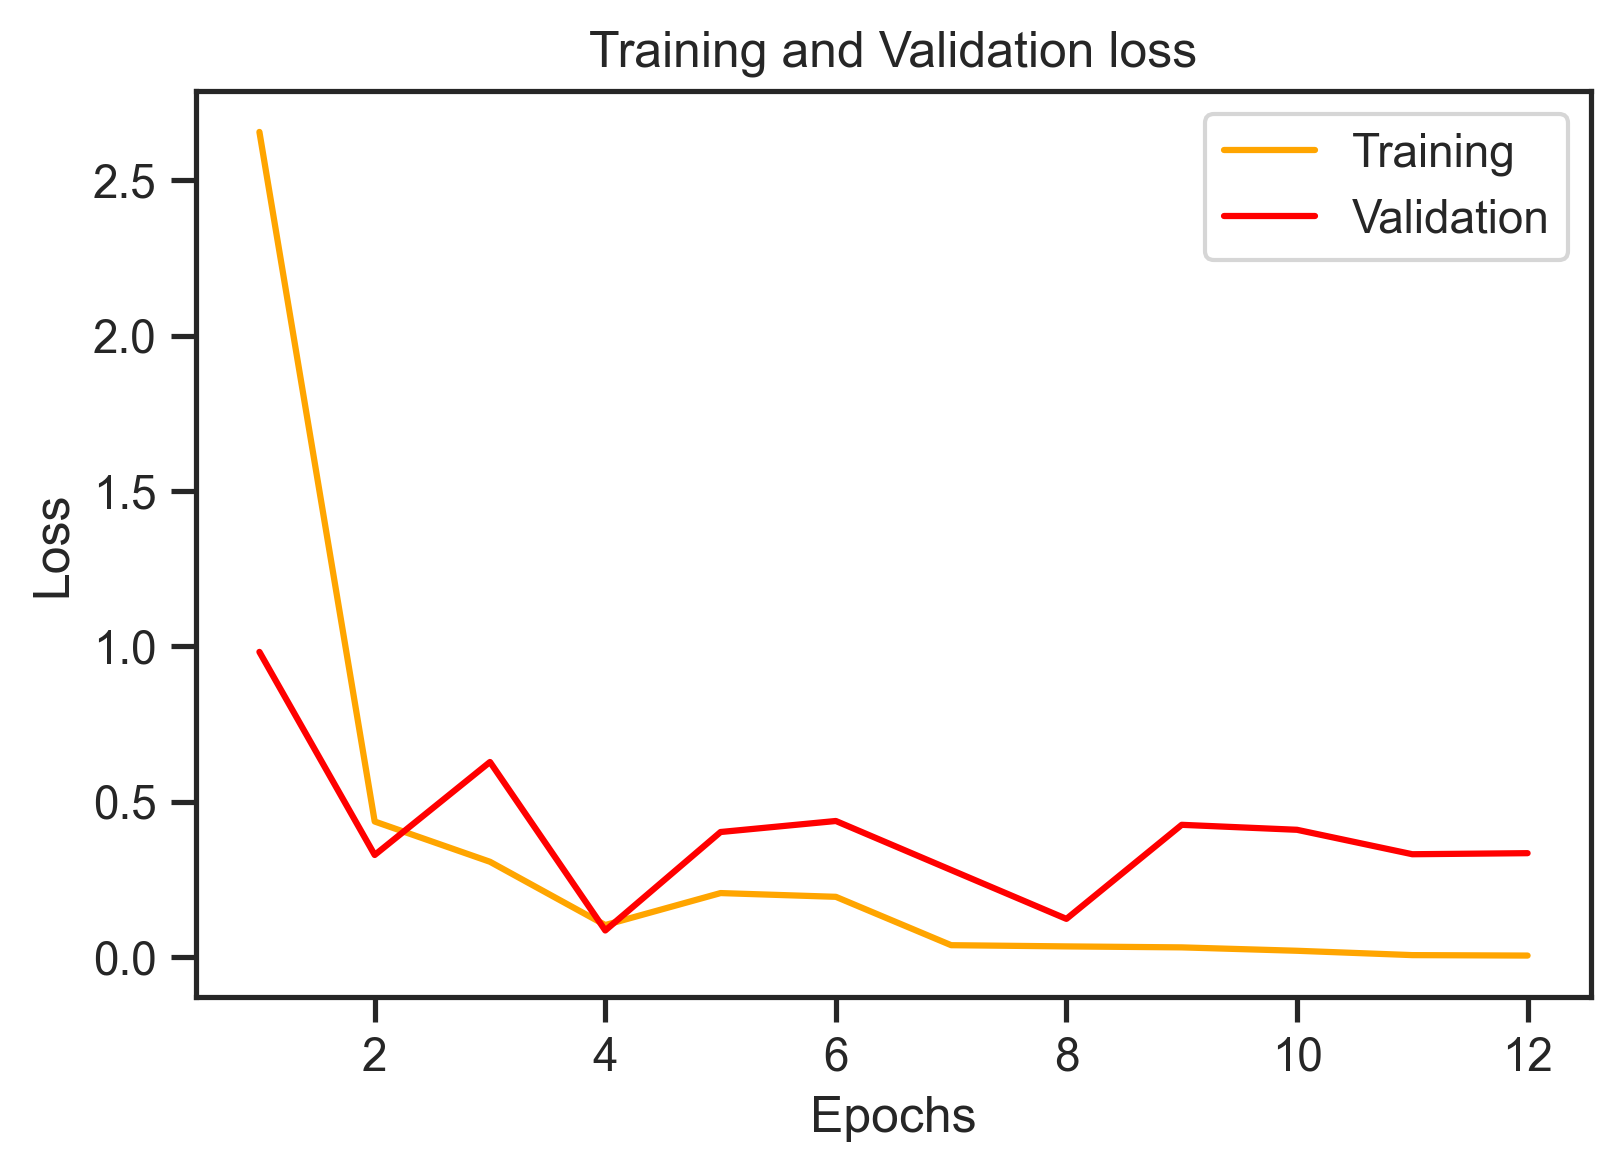

In [219]:
loss = model_cropped.history['loss']
val_loss = model_cropped.history['val_loss']
acc = model_cropped.history['accuracy']
val_acc = model_cropped.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [220]:
y_true = np.argmax(y_test_cr, axis = 1)[:]
pred = inception_v3_cropped.predict(X_test_cr, verbose = 0) # Predict prob and get Class Indices
y_pred= np.argmax(pred, axis = 1)[:]

# calculate accuracy
acc = accuracy_score(y_pred[:], y_true[:])

print("InceptionV3 Accuracy on cropped images: {:.2%}".format(acc))

InceptionV3 Accuracy on cropped images: 90.71%


## Testing the Results

### Testing the full images using the best model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


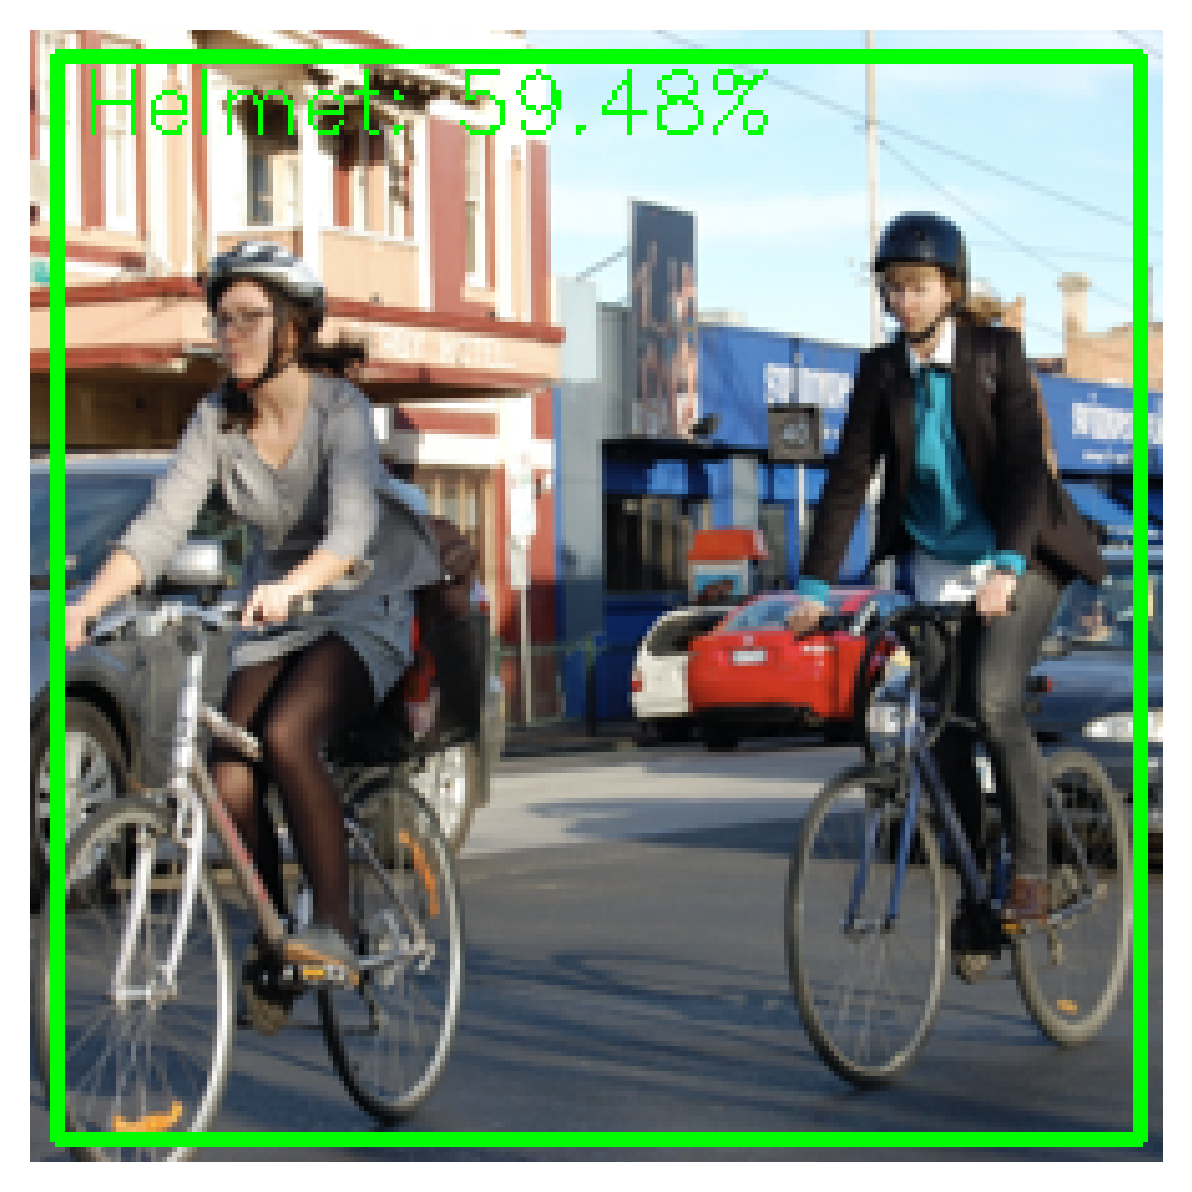

In [232]:
#need only as an input a picture
#extract from the test dataset

def Detect_Helmet_From_Dataset(i):
	
	image=X_test[i]
	#The bounding box for the labels
	startX=0
	startY=0
	endX=224
	endY=224

	# Run the image through the model to see whether it has a helmet on it or not.
	(WithouthHelmet, Helmet) = inception_v3.predict(X_test, verbose = 0)[i]

	# Choose a class mark and a color to use for the bounding box and text.
	label = "Helmet" if Helmet > WithouthHelmet else "No Helmet"
	color =  (0,255,0) if label == "Helmet" else (255,0,0)

	# Show the confidence (probability) in the label.
	label = "{}: {:.2f}%".format(label, max(Helmet, WithouthHelmet) * 100)

	# On the output panel, show the mark and bounding box rectangle.
	cv2.putText(image, label, (10, 20),
				cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 1)
				
	cv2.rectangle(image, (startX+5, startY+5), (endX-5, endY-5), color, 2)

	# # Display the final picture
	plt.figure(figsize=(5, 5))  
	plt.axis('off')
	plt.imshow(image)

Detect_Helmet_From_Dataset(60)

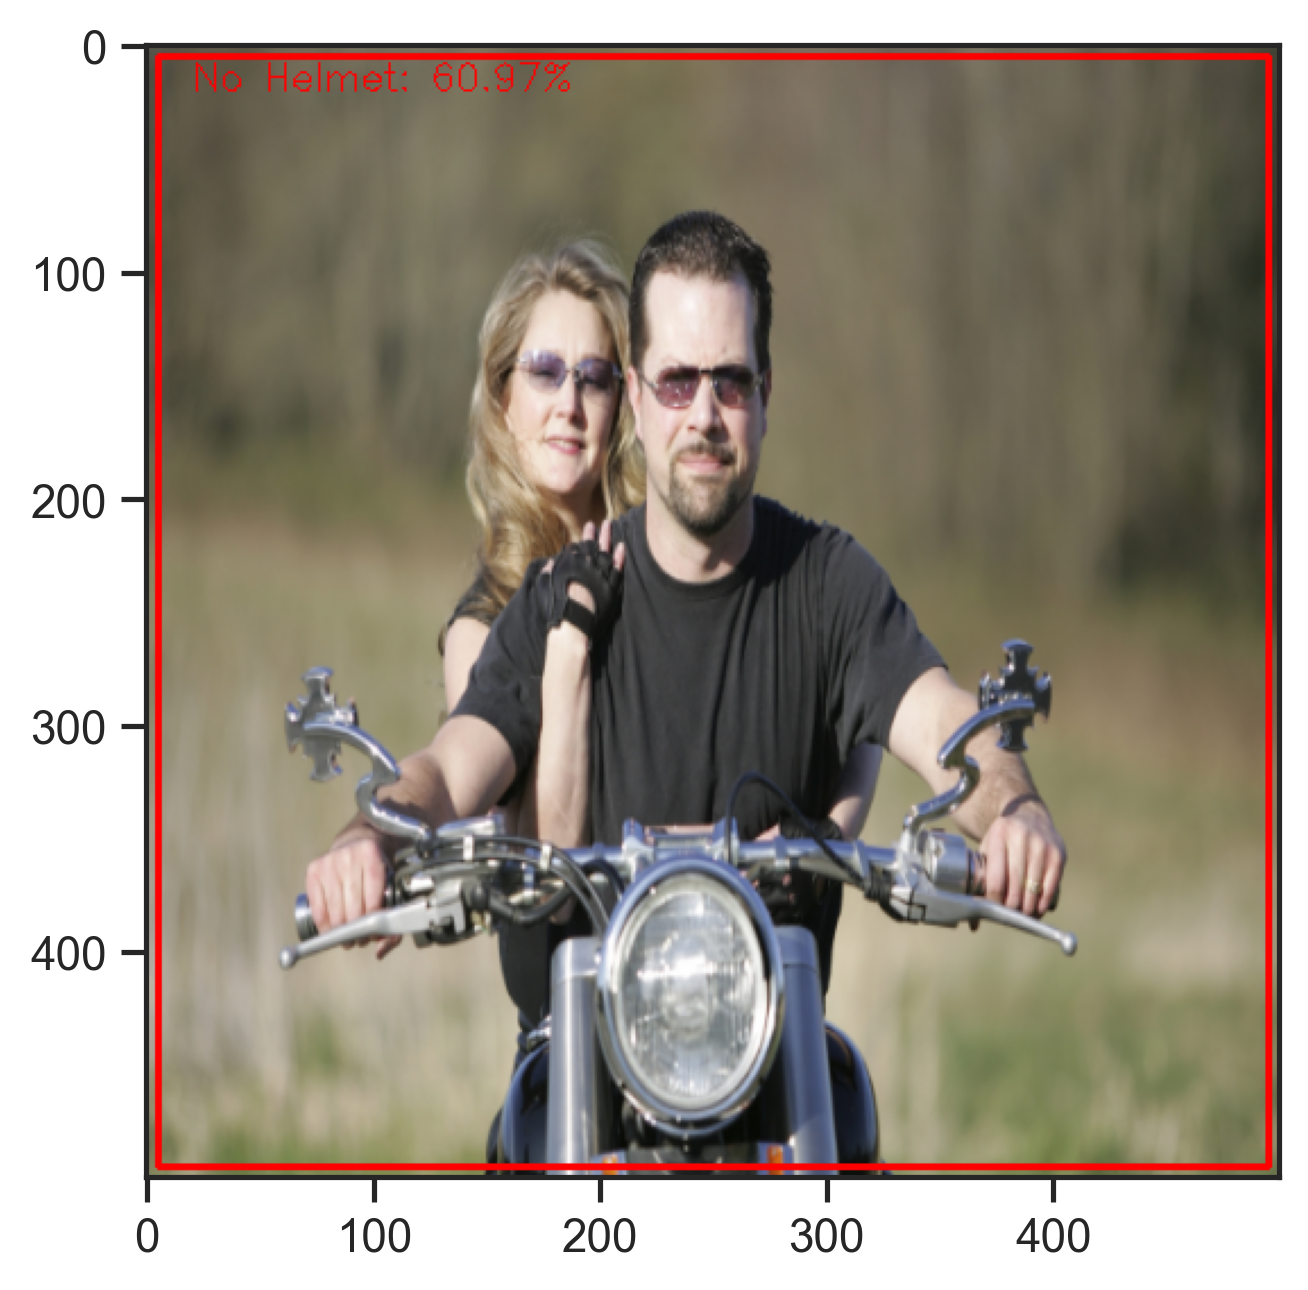

In [233]:

# url="https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/BikesHelmets78.png"
url="https://149361200.v2.pressablecdn.com/wp-content/uploads/2013/05/Motorcycle-couple-resized-600.png"

def Detect_helmet(image_url):

    response = requests.get(image_url)
    bytes_im = BytesIO(response.content)
    cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.INPAINT_TELEA)

    (startX, startY, endX, endY) = [0,244,0,244]

    cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.INPAINT_TELEA)
    face = cv_im[startY:endY, startX:endX]
    face = cv2.cvtColor(cv_im, cv2.INPAINT_TELEA)
    face = cv2.resize(face, (224, 224)) #inception_v3_cropped model for cropped has as input 120x120 shape
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)

    #make the prediction
    inception_v3.predict(face, verbose = 0)[0]

    # Run the image through the model to see whether it has a helmet on it or not.
    (WithouthHelmet, Helmet) = inception_v3.predict(face, verbose = 0)[0]

    # Choose a class mark and a color to use for the bounding box and text.
    label = "Helmet" if Helmet > WithouthHelmet else "No Helmet"
    color =  (0,255,0) if label == "Helmet" else (255,0,0)

    # Show the confidence (probability) in the label.
    label = "{}: {:.2f}%".format(label, max(Helmet, WithouthHelmet) * 100)

    cv_im = cv2.resize(cv_im, (500, 500))

    # On the output panel, show the mark and bounding box rectangle.
    cv2.putText(cv_im, label, (20, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 1)
                
    cv2.rectangle(cv_im, (5,5) , (495, 495), color, 2)

    # Display the final picture
    plt.figure(figsize=(5, 5))  
    # plt.axis('off')
    plt.imshow(cv_im)

Detect_helmet(url)

### Detect helmets using bounding box
Once we know where in the image the face is using the boundig box, we can extract the face . And from there, we apply the model for helmet detection, allowing us to predict the

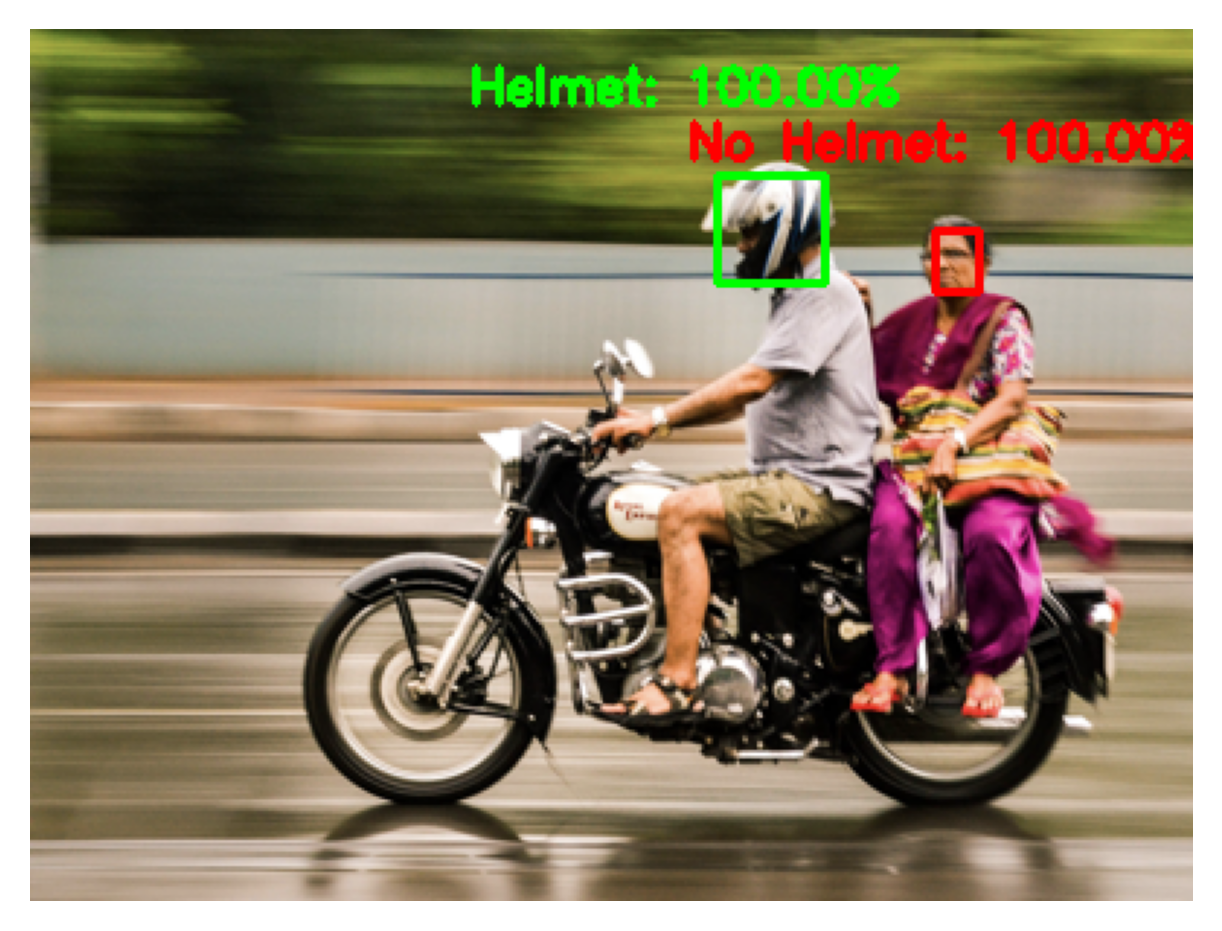

In [223]:
box=[[231,45,278,92],[306,64,331,95]]
url="https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/BikesHelmets73.png"

def detect_face_and_helmet(image_url,box):

	response = requests.get(image_url)
	bytes_im = BytesIO(response.content)
	cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.INPAINT_TELEA)

	
	for i in range(0,len(box)):
	# coordinates (x, y) of the object's bounding box.
		(startX, startY, endX, endY) = box[i]

		# Select the face ROI, adjust the channel ordering from BGR to RGB, and resize it to 120, 120 pixels., and preprocess it
		face = cv_im[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.INPAINT_TELEA)
		face = cv2.resize(face, (120, 120)) #inception_v3_cropped model for cropped has as input 120x120 shape
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		#make the prediction
		inception_v3_cropped.predict(face, verbose = 0)[0]
	
		# Run the image through the model to see whether it has a helmet on it or not.
		(WithouthHelmet, Helmet) = inception_v3_cropped.predict(face, verbose = 0)[0]

		# Choose a class mark and a color to use for the bounding box and text.
		label = "Helmet" if Helmet > WithouthHelmet else "No Helmet"
		color =  (0,255,0) if label == "Helmet" else (255,0,0)

		# Show the confidence (probability) in the label.
		label = "{}: {:.2f}%".format(label, max(Helmet, WithouthHelmet) * 100)

		# On the output panel, show the mark and bounding box rectangle.
		cv2.putText(cv_im, label, (startX-80, startY - 20),
					cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
		cv2.rectangle(cv_im, (startX+5, startY+5), (endX-5, endY-5), color, 2)

	# Display the final picture
	plt.figure(figsize=(5, 5))  
	plt.axis('off')
	plt.imshow(cv_im)
	# print(WithouthHelmet)

detect_face_and_helmet(url,box)
